# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Изучение общей информации о проекте.

#### Настройка параметров анализа.

<div style="border:solid blue 3px; padding: 20px, ">
<span style='color:blue '> Импортирую все необходимые библиотеки.    
    
<span style='color:blue '>  Указываю параметры диаграмм.        
 <span style='color:blue '> Все функции, использованные при анализе описаны в этом разделе проекта.</span>


In [1]:
from IPython.display import HTML
 
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Импортирую все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib

In [3]:
# выбираю четкость и стиль для диаграмм
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('seaborn-poster')

In [4]:
# Функция floor_type присваивания типа этажа
def floor_type(row):
    """
    Функция сравнивает данные столбцов  'floor' и 'floors_total', используя правила:
    - 'последний', если 'floor' и 'floors_total' совпадают;
    - 'первый', если 'floor' равно единице;
    - 'другой' во всех остальных случаях.
    """ 
    if row['floor'] == row["floors_total"]:
        return 'последний'
    if row["floor"] == 1:
        return 'первый'
    return 'другой'

In [5]:
# Функция build_hist для генерации гистограмм по указанным параметрам
def build_hist(data: pd.Series, xname: str, title=None,  xlabelsize=None, xrot=None, 
               ylabelsize=None, yrot=None, ax=None, sharex=False, figsize=(20, 8), bins=40, legend=True):
    data.hist(figsize=figsize, bins=bins, legend=legend)
    plt.xlabel(xname)
    plt.title(title)
    plt.ticklabel_format(style='plain')
    plt.show()

In [6]:
# Функция search_anomalies для поиска аномалий
def search_anomalies (
    data_filtered: pd.DataFrame, base_column: str,  large_dataframe_values: float, small_dataframe_values: float):
    '''
    Функция находит строки по заданным значениям выбранного столбца датафрейма 
    и возвращает датафрейм с такими значениями 
    '''
    return data_filtered.loc[
        (
            data_filtered[base_column] >= large_dataframe_values
        ) | (
            data_filtered[base_column] <= small_dataframe_values
        )
    ].sort_values(
        by=base_column
    )

In [7]:
# Функция filter_values для фильтрации датафрейма при выявлении аномалий.
def filter_values (
    data: pd.DataFrame, base_column: str,  large_dataframe_values: float, small_dataframe_values: float):
    '''
    Функция находит строки по заданным значениям выбранного столбца датафрейма 
    и возвращает датафрейм с такими значениями 
    '''
    return data.loc[
        ((
            data[base_column] == 'NaN'
        ) |
        (
            data[base_column] == 0
        )) | ((
            data[base_column] < large_dataframe_values
        ) & (
            data[base_column] > small_dataframe_values
        ))
    ].sort_values(
        by=base_column
    )

In [8]:
# Функция correct_ceiling_height исправляет предполагаемую ошибку в данных о высоте потолков.
def correct_ceiling_height(ceiling_height: str):
    if ceiling_height >= 20:
        return ceiling_height / 10
    return ceiling_height

In [9]:
# Функция display_pivot_table формирует сводные таблицы с неограниченным количеством параметров группировки
# по количеству, сумме и среднему показателю.
def display_pivot_table(data: pd.DataFrame, base_column: str, *index_names: list):
    
    '''
    Функция формирует и выводит сводную таблицу по одному из сегментов (столбцов данных), в которой отражает 
    количество объявлений, общее количество дней публикации и среднее значение дней публикации 
    каждого из населённых пунктов. 
    '''
    
    pivot_table = data.pivot_table(
        index=index_names, values=base_column, aggfunc=[
            'count', 'sum', 'mean'
        ]
    )
    
    pivot_table.columns = ['all_numbers', 'sum_values', 'average_value']
    display(pivot_table)

#### Знакомство с таблицами.

In [10]:
# открываем файл и выводим "хвост" датафрейма, изучаем структуру данных
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
data.tail(10)

total_images  last_price  total_area first_day_exposition  rooms  \
23689            13   3550000.0       35.30  2018-02-28T00:00:00      1   
23690             3   5500000.0       52.00  2018-07-19T00:00:00      2   
23691            11   9470000.0       72.90  2016-10-13T00:00:00      2   
23692             2   1350000.0       30.00  2017-07-07T00:00:00      1   
23693             9   4600000.0       62.40  2016-08-05T00:00:00      3   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23695            14   3100000.0       59.00  2018-01-15T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23697            13  11475000.0       76.75  2017-03-28T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
23689            2.86          15.0         16.3      4          NaN  ...   
23690             NaN           5.0         31.0      2          NaN  ...   
23691            2.75          25.0         40.3      7          NaN  ...   
23692             NaN           5.0         17.5      4          NaN  ...   
23693            2.60           9.0         40.0      8          NaN  ...   
23694            3.70           5.0         73.3      3          NaN  ...   
23695             NaN           5.0         38.0      4          NaN  ...   
23696             NaN           3.0         29.7      1          NaN  ...   
23697            3.00          17.0          NaN     12          NaN  ...   
23698            2.50           5.0         12.3      1          NaN  ...   

       kitchen_area  balcony        locality_name  airports_nearest  \
23689          9.10      2.0      Санкт-Петербург           17284.0   
23690          6.00      NaN      Санкт-Петербург           20151.0   
23691         10.60      1.0      Санкт-Петербург           19424.0   
23692          6.00      NaN               Тихвин               NaN   
23693          8.00      0.0             Петергоф           45602.0   
23694         13.83      NaN      Санкт-Петербург           24665.0   
23695          8.50      NaN                Тосно               NaN   
23696           NaN      NaN     село Рождествено               NaN   
23697         23.30      2.0      Санкт-Петербург           39140.0   
23698          9.00      NaN  поселок Новый Учхоз               NaN   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
23689             16081.0               1.0          353.0               2.0   
23690              6263.0               1.0          300.0               0.0   
23691              4489.0               0.0            NaN               1.0   
23692                 NaN               NaN            NaN               NaN   
23693             34104.0               1.0          352.0               1.0   
23694              4232.0               1.0          796.0               3.0   
23695                 NaN               NaN            NaN               NaN   
23696                 NaN               NaN            NaN               NaN   
23697             10364.0               2.0          173.0               3.0   
23698                 NaN               NaN            NaN               NaN   

       ponds_nearest  days_exposition  
23689          652.0             29.0  
23690            NaN             15.0  
23691          806.0            519.0  
23692            NaN            413.0  
23693          675.0            239.0  
23694          381.0              NaN  
23695            NaN             45.0  
23696            NaN              NaN  
23697          196.0            602.0  
23698            NaN              NaN  

[10 rows x 22 columns]

In [11]:
# выводим основную информацию датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

***Знакомство с данными:***  

В датафрейме представлены строковые, булевые и числовые данные.  
В некоторых столбцах указан тип данных `float64`, однако значения таких столбцов не предполагают дробной части (например, количество балконов). Такие типы данных будут исправлены на следующих этапах.  

Кроме того разное количество строк в столбцах говорит о наличии пропусков. Решение по заполнению пропусков в каждом из таких столбцов будет принято на этапе предобработки данных.  

Следующим шагом представлю количественные данные в виде гистограмм и оценю количественный и качественный "разброс значений".

#### Сетки гистограмм.

Построим гистограммы по всем числовым столбцам датафрейма

In [12]:
# Вывожу числовые столбцы датафрейма, которую будут отражены на гистограмме
data.select_dtypes(include=np.number).head()

total_images  last_price  total_area  rooms  ceiling_height  floors_total  \
0            20  13000000.0       108.0      3            2.70          16.0   
1             7   3350000.0        40.4      1             NaN          11.0   
2            10   5196000.0        56.0      2             NaN           5.0   
3             0  64900000.0       159.0      3             NaN          14.0   
4             2  10000000.0       100.0      2            3.03          14.0   

   living_area  floor  kitchen_area  balcony  airports_nearest  \
0         51.0      8          25.0      NaN           18863.0   
1         18.6      1          11.0      2.0           12817.0   
2         34.3      4           8.3      0.0           21741.0   
3          NaN      9           NaN      0.0           28098.0   
4         32.0     13          41.0      NaN           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

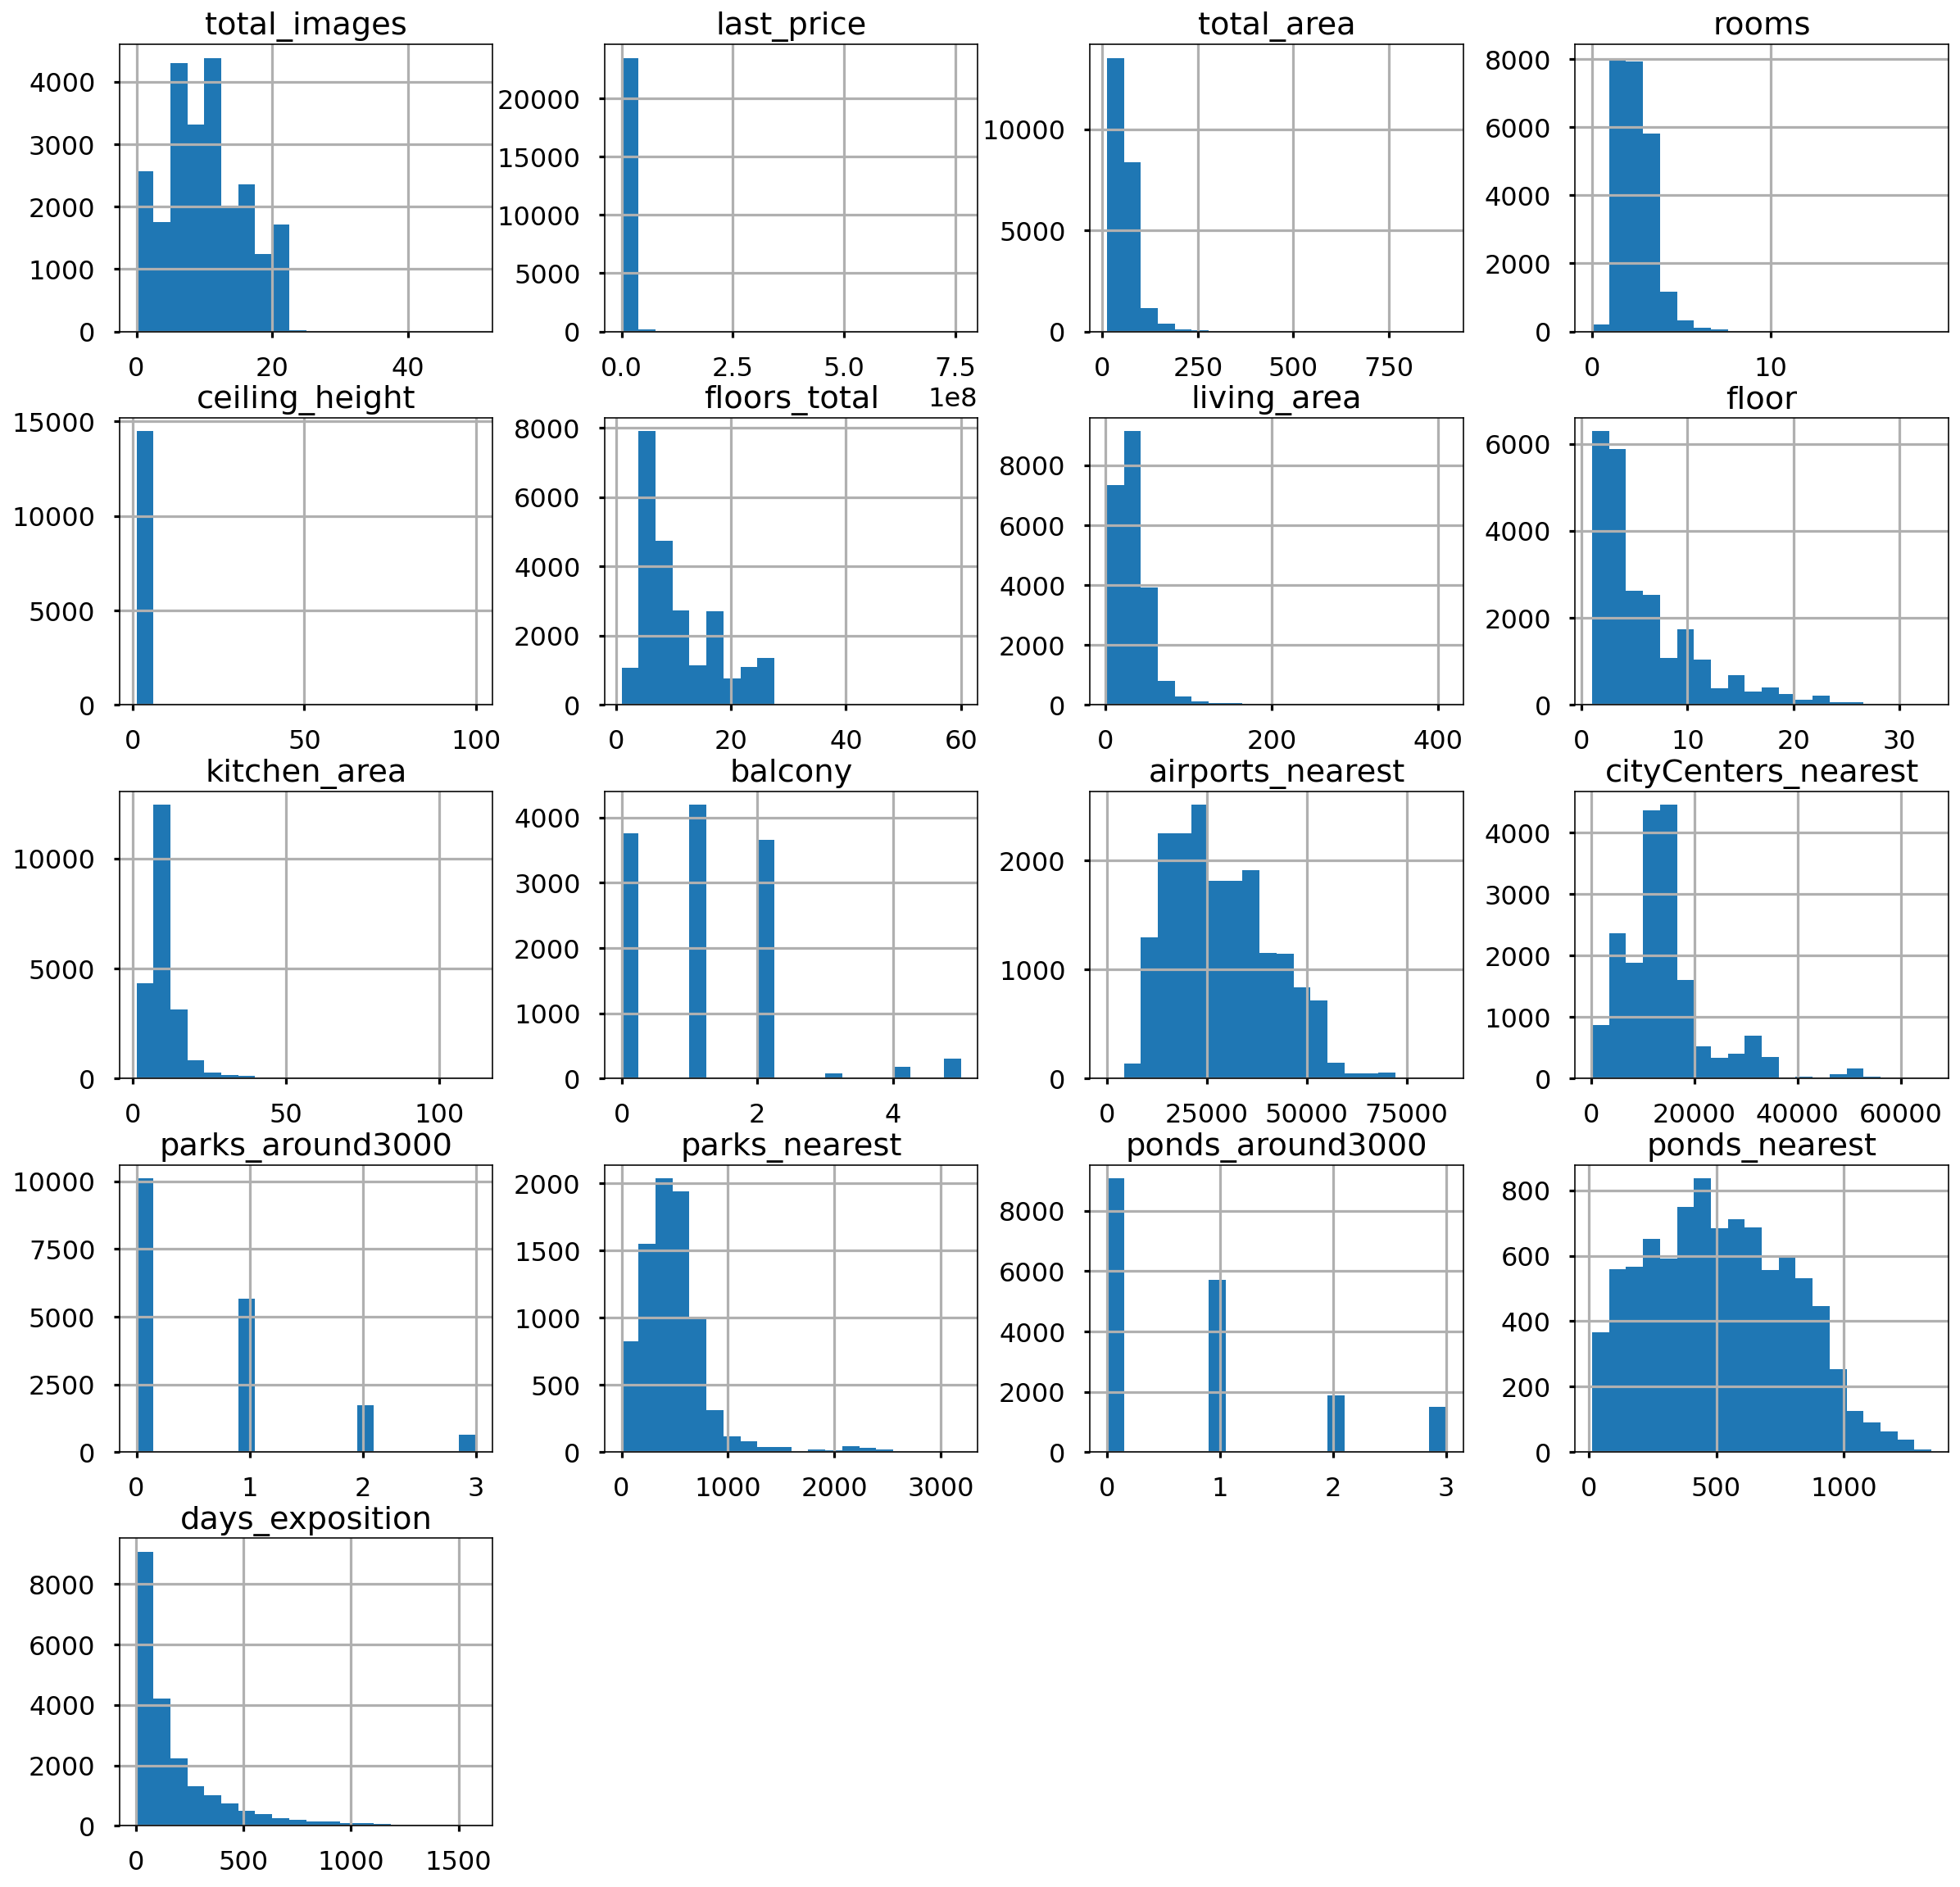

In [13]:
# Строю гистограммы по всем числовым столбцам
data.select_dtypes(include=np.number).hist(figsize = (20, 20), bins = 20)
plt.show()

***Вывод по общей информации датафрейма:***  

Просмотрев общую информацию датафрейма, можно сделать вывод о необходимости предобработки: заполнении пропусков, где это возможно; изменению типа данных, подробном изучении отдельных столбцов данных.  

Построенные гистограммы дают общее представление об объектах: площади, комнатности, этажности и т.д. 
Однако, каждый из признаков нужно анализировать отдельно, предварительно очистив данные от "мусора".  

### Предобработка данных.

#### Поиск пропусков.

Предобработку данных начинаю с изучения и заполнения пропусков в данных. С помощью комбинации методов вывожу количество пропусков в каждом столбце.

In [14]:
# считаю пропуски в каждом из столбцов датафрейма
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<div style="border:solid blue 3px; padding: 20px, ">

***Пропуски в данных обнаружены в переменных, внесённых пользователями, опишу как следует поступить с пропусками в каждом из параметров:**** 
– `ceiling_height` –  высота потолков (м) — может быть заполнена медианным значением высоты потолков после исключения аномалий   
– `floors_total` — всего этажей в доме  — доля пропусков незначимая, можно удалить объекты с пропусками   
– `living_area` — жилая площадь в квадратных метрах (м²)  – доля пропусков ~8,03% от общего количества значений датафрейма, пропуски могут быть удалены   
– `kitchen_area` — площадь кухни в квадратных метрах (м²) – доля пропусков ~9,61% от общего количества значений датафрейма, но эти пропуски следует игнорировать, так как в таких объектах как "студия" или "апартаменты" могут отсутствовать кухни.
    
***Пропуски могли быть допущены, в случае если параметр отсутствует. В таком случае вместо пропуска можно указать ноль:***
– `balcony` — число балконов — пропуски следует заполнить нулями, т.к. неуказание параметра скорее свидетельствует об отсутствии балкона.


***Часть пропусков допущена в данных полученных автоматически на основе картографических данных без участия пользователя:***   

***Столбцы с данными о расстоянии до аэропорта и центра города можно заполнить после группировки данных по наименованиям населённых пунктов при необходимости:***
– `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)  
– `cityCenters_nearest` — расстояние до центра города (м)  
– `parks_around3000` — количество парков в пределах 3 км   
– `parks_nearest` — расстояние до ближайшего парка (м)   
– `ponds_around3000` —  число водоёмов в радиусе 3 км   
– `ponds_nearest` — расстояние до ближайшего водоёма (м) </span>
 
***Пропуски в столбце с данными о времени размещения объявления могут говорить о том, что объявление было снято в день публикации по каким-то причинам. Пока пропуски заполним нулями и изучим эту группу данных подробнее.***  

– `days_exposition` — сколько дней было размещено объявление (от публикации до снятия) - заполнить нулями, изучить.   


***Часть пропусков обнаружены в категориальных данных:***   
– `is_apartment` — апартаменты (булев тип)  - изучить, скорее при отсутствии данных можно обозначить как False - не является апартаментами  
– `locality_name` — название населённого пункта (изучить подробнее возможные варианты)  

Начну с проверки и заполнения пропусков в столбце `is_apartment`.

#### Обработка пропусков и дубликатов в данных.

Начинаю предобработку с удаления и корректировки пропусков, где это возможно </span>


In [15]:
# Знакомство с данными о высоте потолков 
print(data['ceiling_height'].describe())
data['ceiling_height'].isna().sum()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


9195

В столбце `ceiling_height` — 9195 пропуска и явные аномалии (максимальная высота 100 м). Пропуски в этом параметре заполню после подробного исследования и обработки.

In [16]:
# удаляю пропуски в столбце количества этажей домов, в которых расположены анализируемые объекты
data = data.dropna(subset=['floors_total'])
data['floors_total'].isna().sum()

0

In [17]:
# удаляю пропуски в столбце с жилой площадью
data = data.dropna(subset=['living_area'])
data['living_area'].isna().sum()

0

In [18]:
# сколько квартир с типом 'апартаменты'
data['is_apartment'].value_counts()

False    2613
True       42
Name: is_apartment, dtype: int64

Соотношение True и False более чем в 50 раз. При этом в датафрейме 20 924 пропущенных значений.  
Предположительно в большинстве случаев продавец не заполняет этот параметр, если недвижимость не имеет статуса "апартаменты".  
Пропуски в таком случае можно заполнить значением False.   

После замены ещё раз считаю количество каждого уникального значения столбца для проверки преобразования.

In [19]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

Следующим шагом заменяю пропуски в данных столбца 'balcony' на нули — предположительно продавец не указывает количество балконов, если они отсутствуют.  

После замены изменим тип данных на целочисленный и выведем количество уникальных значений для проверки отсутствия пропусков.

In [20]:
# заполняем пропуски в столбце 'balcony' нулями и меняем тип данных на целочисленный
data['balcony'] = data['balcony'].fillna(0).astype('int64')
data['balcony'].isna().sum()

0

Также поступаю с группой данных, полученных автоматически на основе картографических данных без участия пользователя — заполняем пропуски нулями.   

После замены меняю тип данных на целочисленный и вывожу количество уникальных значений для проверки отсутствия пропусков.

In [21]:
# заполняю пропуски в столбце 'days_exposition' нулями и меняю тип данных на целочисленный
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int64')
data['days_exposition'].isna().sum()

0

Для дальнейшей их обработки группирую данные по локации.
Считаю и вывожу все доступные локации в столбце `locality_name` датафрейма методами `nunique()` и `unique()`.

In [22]:
print(data['locality_name'].nunique())
data['locality_name'].unique()

348


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'село Путилово', 'Ивангород', 'Мурино',
       'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское', 'Зеленогорск',
       'Сосновый Бор',

Видно, что из 348-и локаций в дата-фрейме есть повторы – одни и те же населённые пункты отражены по-разному (посёлок Мурино, поселок Мурино и Мурино, например).   

Для приведения к общим названиям необходимо удалить все варианты статусов населённых пунктов, а также заменить возможные варианты разночтений одинаковых названий.  

Воспользуемся методом `replace()`. После изменения названий ещё раз выведем количество и все варианты названий.

In [23]:
# Избавляемся от всех неочевидных дублей
data['locality_name'] = (
    data['locality_name']
    .str.lower()
    .str.replace('ё', 'е')
    .str.replace('""', '')
    .str.replace('''''', '')
    .str.replace('-', '')
    .str.replace('%', '')
    .replace({'поселок': '', \
              'деревня': '', 'село': '', 'городского типа': '', 'садовое товарищество': '',\
              'городской': '', 'станции': '', 'при железнодорожной': '', 'имени': '',\
             'садоводческое некоммерческое товарищество': '', 'коттеджный': ''}, regex=True)
    .str.strip())

print(data['locality_name'].nunique())
data['locality_name'].unique()

289


array(['санктпетербург', 'шушары', 'янино1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'колпино', 'гатчина', 'федоровское', 'выборг', 'кронштадт',
       'кировск', 'новое девяткино', 'металлострой', 'лебяжье',
       'сиверский', 'молодцово', 'кузьмоловский', 'новая ропша',
       'павловск', 'пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'куттузи', 'аннино', 'заклинье',
       'торковичи', 'первомайское', 'красное', 'понтонный', 'старая',
       'лесколово', 'путилово', 'ивангород', 'сланцы', 'шлиссельбург',
       'сясьстрой', 'никольское', 'зеленогорск', 'сосновый бор',
       'новый свет', 'оржицы', 'кальтино', 'романовка', 'бугры', 'рощино',
       'кириши', 'луга', 'волосово', 'отрадное', 'павлово', 'оредеж',
       'красный бор', 'коммунар', 'молодежное', 'нурма', 'синявино',
       'тосно', 'стрельна', 'бокситогорск', 'александровская',
       'лопухинка', 'терволово', 'советский', 'подп

***Вывод по предобработке данных:***  

Предобработка обнаружила три проблемы в данных:

- пропущенные значения,
- дубликаты,
- некорректный тип данных.


В датафрейме исправлен тип данных некоторых столбцов исходя из логики данных – тип `float64` заменён на целочисленный. 

Строки с долей пропусков меньше 5% были удалены, так как не влияют значительно на результаты анализа.. 
    
Обнаружено большое количество пропусков в столбце `ceiling_height`.  Удалить такие объекты нельзя из-за большого количества (до ~38.79%). Их следует исследовать подробнее и принять решение только после этого.  

Удалены неявные дубликаты в столбце `locality_name` – список вариантов локаций сократился до 289.  

***На следующем этапе добавим столбцы для расчёта стоимостных показателей объектов и продолжим исследовательский анализ.***

### Добавление дополнительных показателей сравнения объектов.

**Для проведения анализа необходимо рассчитать некоторые дополнительные показатели для сравнения.**  

На этом этапе следует добавить в датафрейм столбцы:  
- с расчётными данными о цене одного квадратного метра каждого из объектов;
- дне недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).  

**После добавления столбца *'price_per_meter'* с ценой квадратного метра объекта ещё раз просмотрим информацию и выведем первые 10 строк датафрейма.**

In [24]:
# добавляем столбец со стоимостью квадратного метра
data['price_per_meter'] = pd.to_numeric(data['last_price'] / data['total_area']).round(2)

# преобразуем формат даты для удобства
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')

# добавляем столбцы с информацией о дне неделе, месяце и годе публикации объявления
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

# выводим первые 5 строк датафрейма для проверки
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
4             2  10000000.0       100.0           2018-06-19      2   
5            10   2890000.0        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1             NaN          11.0         18.6      1         False  ...   
2             NaN           5.0         34.3      4         False  ...   
4            3.03          14.0         32.0     13         False  ...   
5             NaN          12.0         14.4      5         False  ...   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
4               8098.0               2.0          112.0               1.0   
5                  NaN               NaN            NaN               NaN   

  ponds_nearest  days_exposition  price_per_meter  day_of_week_exposition  \
0         755.0                0        120370.37                       3   
1           NaN               81         82920.79                       1   
2         574.0              558         92785.71                       3   
4          48.0              121        100000.00                       1   
5           NaN               55         95065.79                       0   

   month_exposition  year_exposition  
0                 3             2019  
1                12             2018  
2                 8             2015  
4                 6             2018  
5                 9             2018  

[5 rows x 26 columns]

Для добавления столбца с типом этажа квартиры воспользуюсь функцией `floor_type`, которая присваивает тип в зависимости от результатов сравнения данных столбца `floor` и `floors_total`.  

Применяю функцию к датафрейму и добавляю результаты в новый столбец `apartment_floor_type` датафрейма. 

In [25]:
# С помощью метода apply() применяю функцию к датафрейму и присваиваю типы этажей каждому объекту датафрейма
# Для проверки вызываю метод describe()
data['floor_type'] = data[['floor', 'floors_total']].apply(floor_type, axis=1)
data['floor_type'].describe()

count      21743
unique         3
top       другой
freq       15997
Name: floor_type, dtype: object

Добавляю столбец с расстоянием до центра города в километрах на основании данных столбца `cityCenters_nearest`.  
В дальнейшем эти данные можно использовать для группировки по расстоянию.  
Вывожу первые 10 строк датафрейма для проверки вычислений. 

In [26]:
data['cityCenters_nearest_km'] = pd.to_numeric(data['cityCenters_nearest'] / 1000).round(0)
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
4             2  10000000.0       100.0           2018-06-19      2   
5            10   2890000.0        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1             NaN          11.0         18.6      1         False  ...   
2             NaN           5.0         34.3      4         False  ...   
4            3.03          14.0         32.0     13         False  ...   
5             NaN          12.0         14.4      5         False  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0                0   
1            NaN               0.0            NaN               81   
2           90.0               2.0          574.0              558   
4          112.0               1.0           48.0              121   
5            NaN               NaN            NaN               55   

  price_per_meter  day_of_week_exposition  month_exposition  year_exposition  \
0       120370.37                       3                 3             2019   
1        82920.79                       1                12             2018   
2        92785.71                       3                 8             2015   
4       100000.00                       1                 6             2018   
5        95065.79                       0                 9             2018   

   floor_type  cityCenters_nearest_km  
0      другой                    16.0  
1      первый                    19.0  
2      другой                    14.0  
4      другой                     8.0  
5      другой                     NaN  

[5 rows x 28 columns]

***Вывод по добавлению новых столбцов:***  

Для проведения исследовательского анализа добавила столбцы:

- цена одного квадратного метра каждого из объектов;
- день недели публикации объявления;
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах.  

Обращаю внимание, что в датафрейме всё ещё есть пропущенные значения.  
На следующем этапе проверю  данные на наличие аномалий и проведу исследовательский анализ данных.

### Исследовательский анализ данных.

#### Исследование основных параметров объектов.

На начальном этапе были построены общие гистограммы по числовым значениям датафрейма. 

Но каждый из следующих параметров следует проверить на наличие аномалий, удалить их; агрегировать полученные нормальные значения и построить гистограммы.

**Список параметров:**  

- общая площадь `total_area`;
- жилая площадь `living_area`;
- площадь кухни `kitchen_area`;
- цена объекта `last_price`;
- количество комнат `rooms`;
- высота потолков `ceiling_height`;
- тип этажа квартиры («первый», «последний», «другой») `floor_type`;
- общее количество этажей в доме `floors_total`;
- расстояние до центра города в метрах `cityCenters_nearest`;
- расстояние до ближайшего парка `parks_nearest`.  

Построю гистограммы по каждому из параметров, поищу аномалии и удалю их.

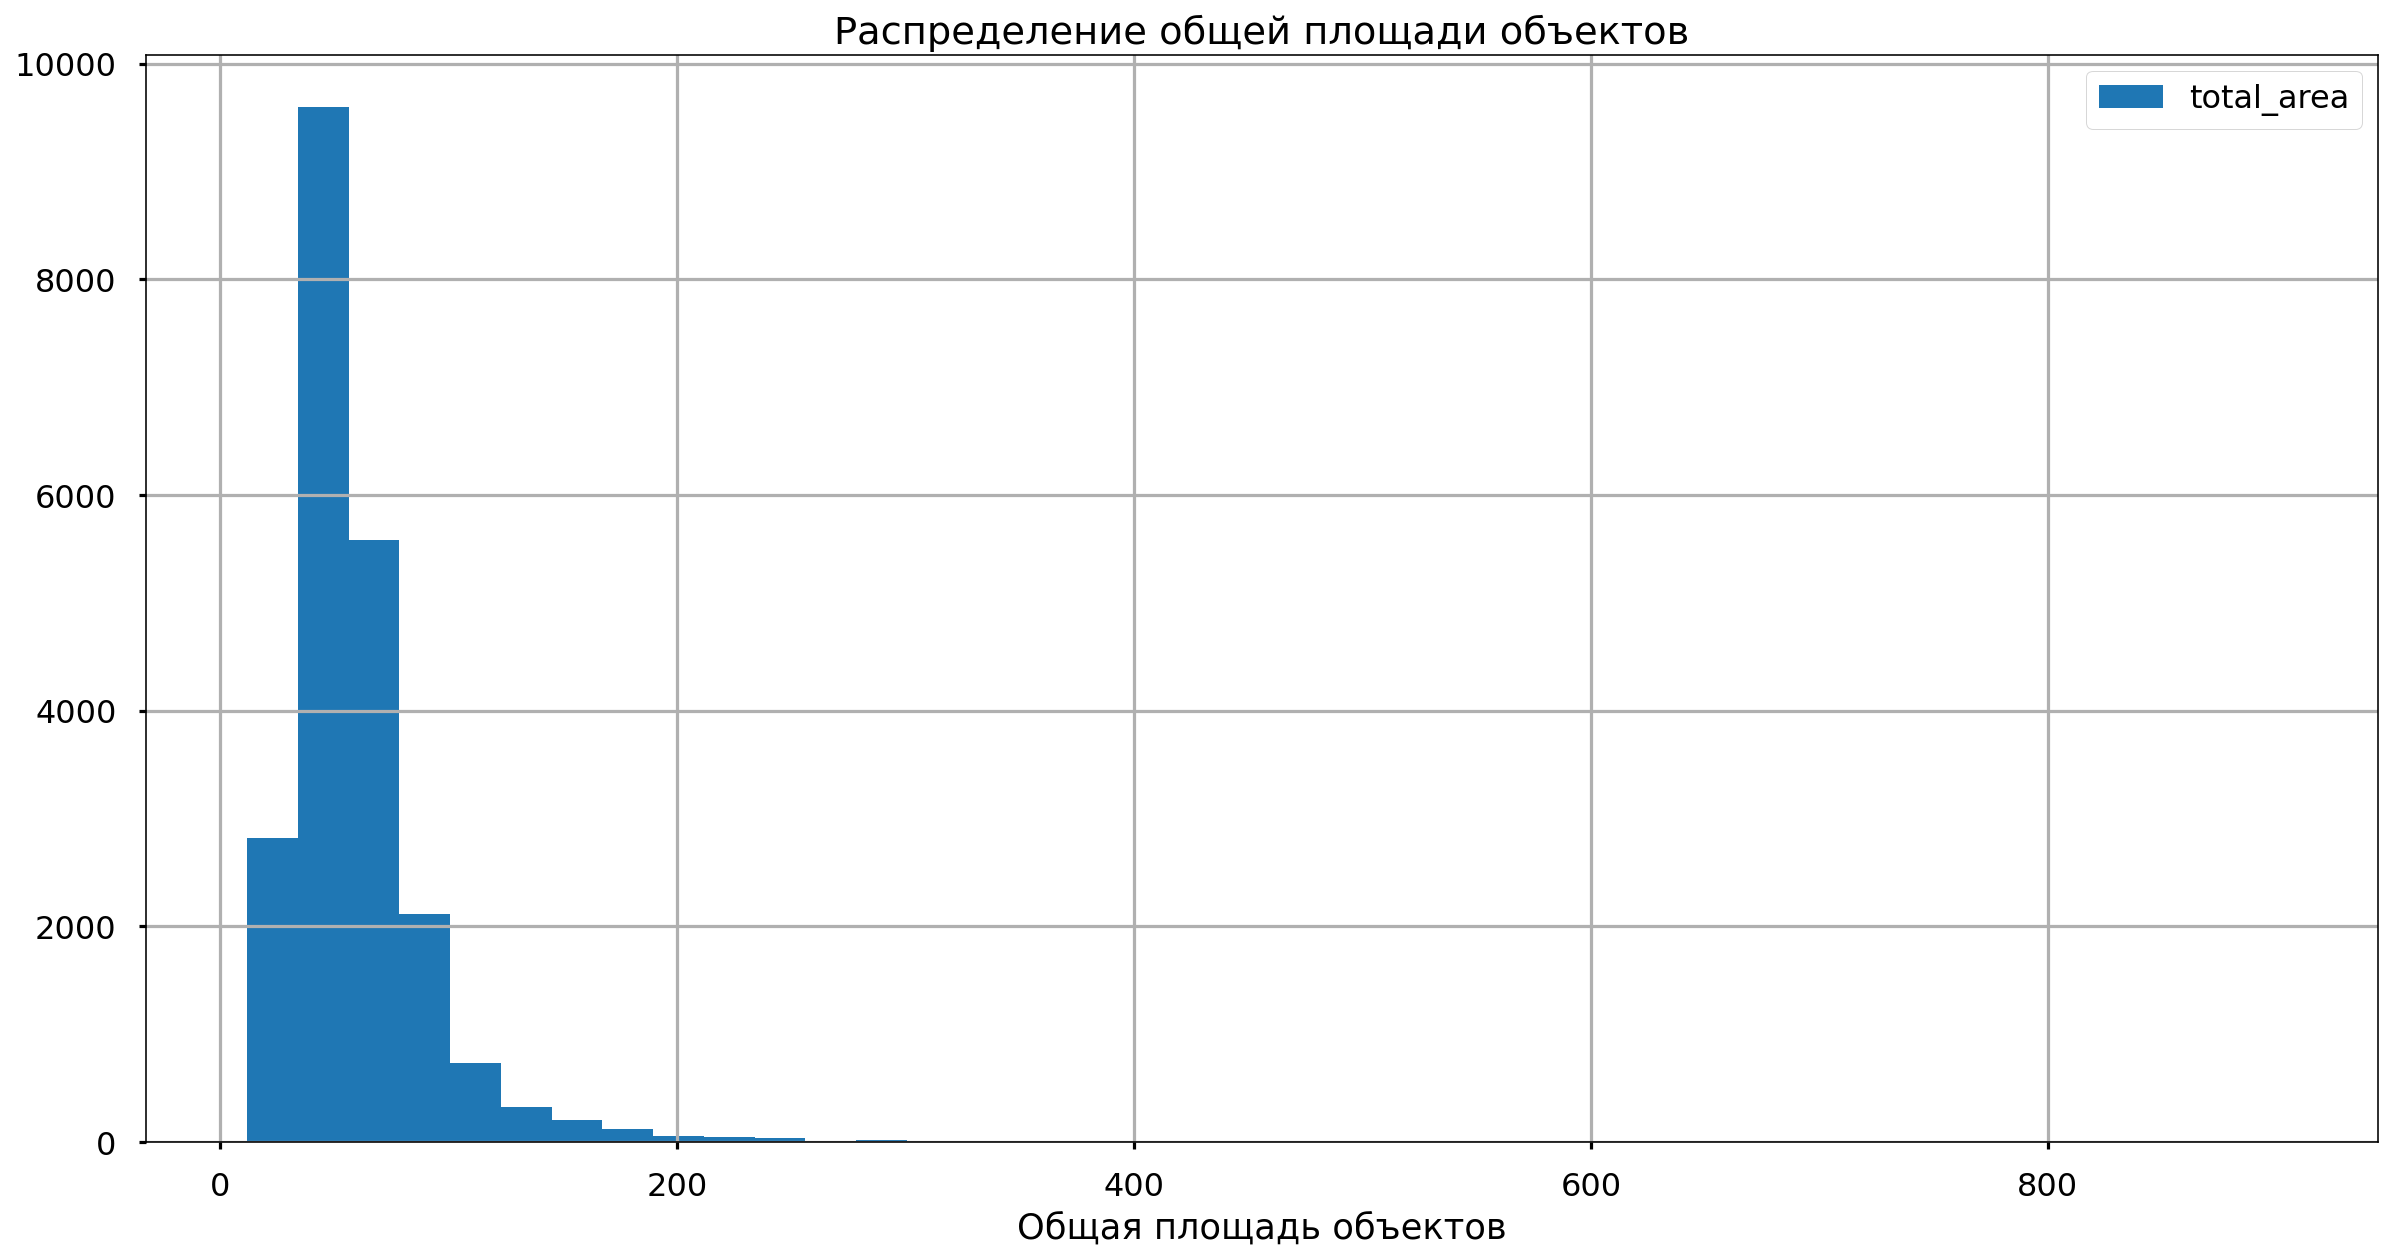

count    21743.000000
mean        60.075015
std         34.685768
min         12.000000
25%         40.000000
50%         52.000000
75%         69.500000
max        900.000000
Name: total_area, dtype: float64

In [27]:
build_hist(data.total_area, 'Общая площадь объектов', 'Распределение общей площади объектов', figsize=(20, 10))
data['total_area'].describe()

Параметр общей площади имеет большой размах и явные вбросы, судя по гистограмме. Изучу их подробнее. 

In [28]:
# применяю функцию search_anomalies с ограничивающими параметрами больше 300 кв. м. и меньше 15 кв.м.
search_anomalies(data, "total_area", 300, 15)

total_images   last_price  total_area first_day_exposition  rooms  \
19904             4    2400000.0        12.0           2017-07-19      1   
19807             0    3800000.0        13.0           2018-07-04      1   
19642             5    1190000.0        14.0           2018-07-29      1   
20919            20   54000000.0       300.0           2019-03-21      6   
8038             20   64500000.0       300.0           2017-09-29      6   
19221             0   30000000.0       301.9           2018-02-01      6   
7543             20  130000000.0       307.8           2016-04-24      5   
13397            14   19500000.0       309.7           2016-02-03      9   
793              20  135000000.0       310.0           2018-05-22      4   
1026             20  155000000.0       310.0           2018-10-12      5   
9561              2   24900000.0       312.0           2015-11-27      5   
7939             12   39000000.0       312.0           2017-07-27      6   
9550             10   23500000.0       313.0           2017-02-13      9   
7664             20   40000000.0       315.0           2017-04-20      5   
11436             4   24000000.0       316.3           2015-03-25      8   
155               8   96000000.0       317.0           2017-07-07      4   
11087             3   14000000.0       320.0           2017-09-27      6   
1085             16   75000000.0       323.0           2017-07-10      5   
14591            20   29000000.0       327.2           2017-11-15      6   
16179            11   28000000.0       336.0           2017-09-27      5   
2580              6   30900000.0       338.6           2017-10-16      7   
20820             7   73900000.0       342.0           2015-06-18      5   
19865            20  180000000.0       347.0           2015-01-21      8   
10569            13   36900000.0       347.5           2017-09-14      8   
15607             5   34000000.0       356.0           2017-09-12      7   
866               5   25000000.0       363.0           2017-12-23     14   
1494             10   65000000.0       364.0           2018-11-27      7   
19961            20   32350000.0       365.0           2016-10-10      5   
21990            20   68000000.0       373.1           2018-09-08      8   
20314             8   42000000.0       374.0           2017-04-09      7   
14498             6   32250000.0       374.6           2018-06-09     19   
5042             20   35000000.0       380.0           2017-08-17      6   
7674             20  131000000.0       380.0           2016-09-23      5   
8822             14   49968900.0       398.0           2017-07-12      9   
15151            15   88000000.0       400.0           2019-03-27      9   
12971            19  763000000.0       400.0           2017-09-30      7   
14706            15  401300000.0       401.0           2016-02-20      5   
14088             8   51000000.0       402.0           2017-02-07      6   
13749             7  240000000.0       410.0           2017-04-01      6   
14991            19   45000000.0       413.5           2018-09-20      7   
21955            19  130000000.0       431.0           2017-10-02      7   
20273            12   20000000.0       460.8           2019-03-20      6   
6221              8   34000000.0       470.3           2018-01-14      4   
660               3   49950000.0       483.9           2017-10-04      7   
6621             20   99000000.0       488.0           2017-04-09      5   
22494             7   91075000.0       491.0           2017-05-27      5   
12401            20   91500000.0       495.0           2017-06-19      7   
8018             20   84000000.0       507.0           2015-12-17      5   
4237              1   50000000.0       517.0           2017-10-14      7   
5358             20   65000000.0       590.0           2019-02-14     15   
15651            20  300000000.0       618.0           2017-12-18      7   
12859            20  140000000.0       631.2           

Обращаю внимание, что у объектов с аномальными площадями большой разброс стоимости квадратного метра, то есть они вряд ли сопоставимы для группового анализа.  
Можно удалить их из датафрейма. Воспользуюсь для этого функцией `filter_values()` и удалю с её помощью аномалии.

In [29]:
# Избавляюсь от аномалий с помощью функции filter_values, оставляя объекты только площадью не более 300 кв.м. и не менее 15 кв.м. 
data = filter_values(data, "total_area", 300, 15)
data['total_area'].describe()

count    21690.000000
mean        59.300538
std         30.210718
min         15.500000
25%         40.000000
50%         52.000000
75%         69.200000
max        297.500000
Name: total_area, dtype: float64

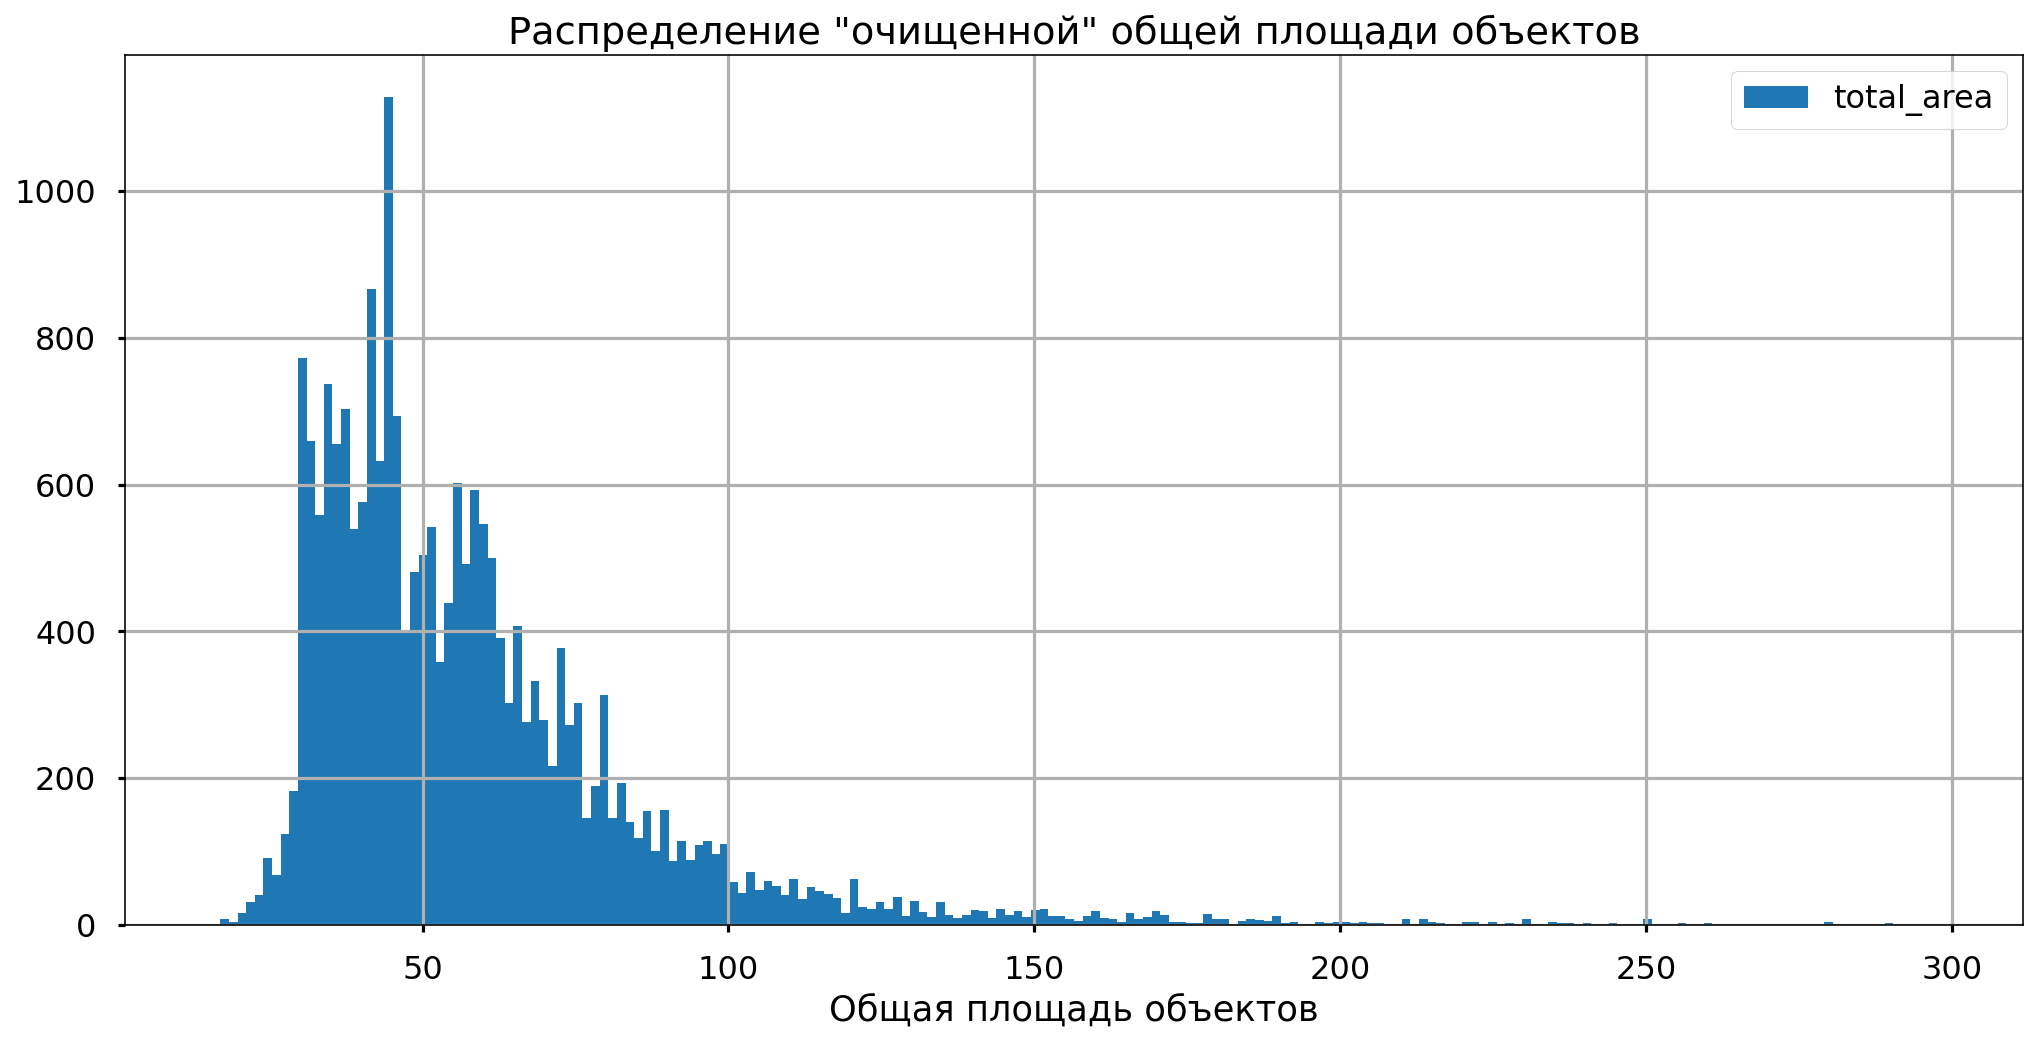

In [30]:
build_hist(data.total_area, 'Общая площадь объектов', 'Распределение "очищенной" общей площади объектов',
           figsize=(17, 8), bins=200)

***Вывод по анализу общей площади объектов:***  
    
Гистограмма и вызов метода `describe()` отражают большое количество объектов со средней площадью около 50 кв.м., также заметны "пики" на площади около 30 кв.м. и 70 кв.м. Скорее всего они связаны с параметром количества комнат.   

Далее последовательно применяю созданные функции к датафрейму по каждому из параметров для построения гистограмм `build_hist()` поиска `search_anomalies()` и удаления аномалий `filter_values()`.

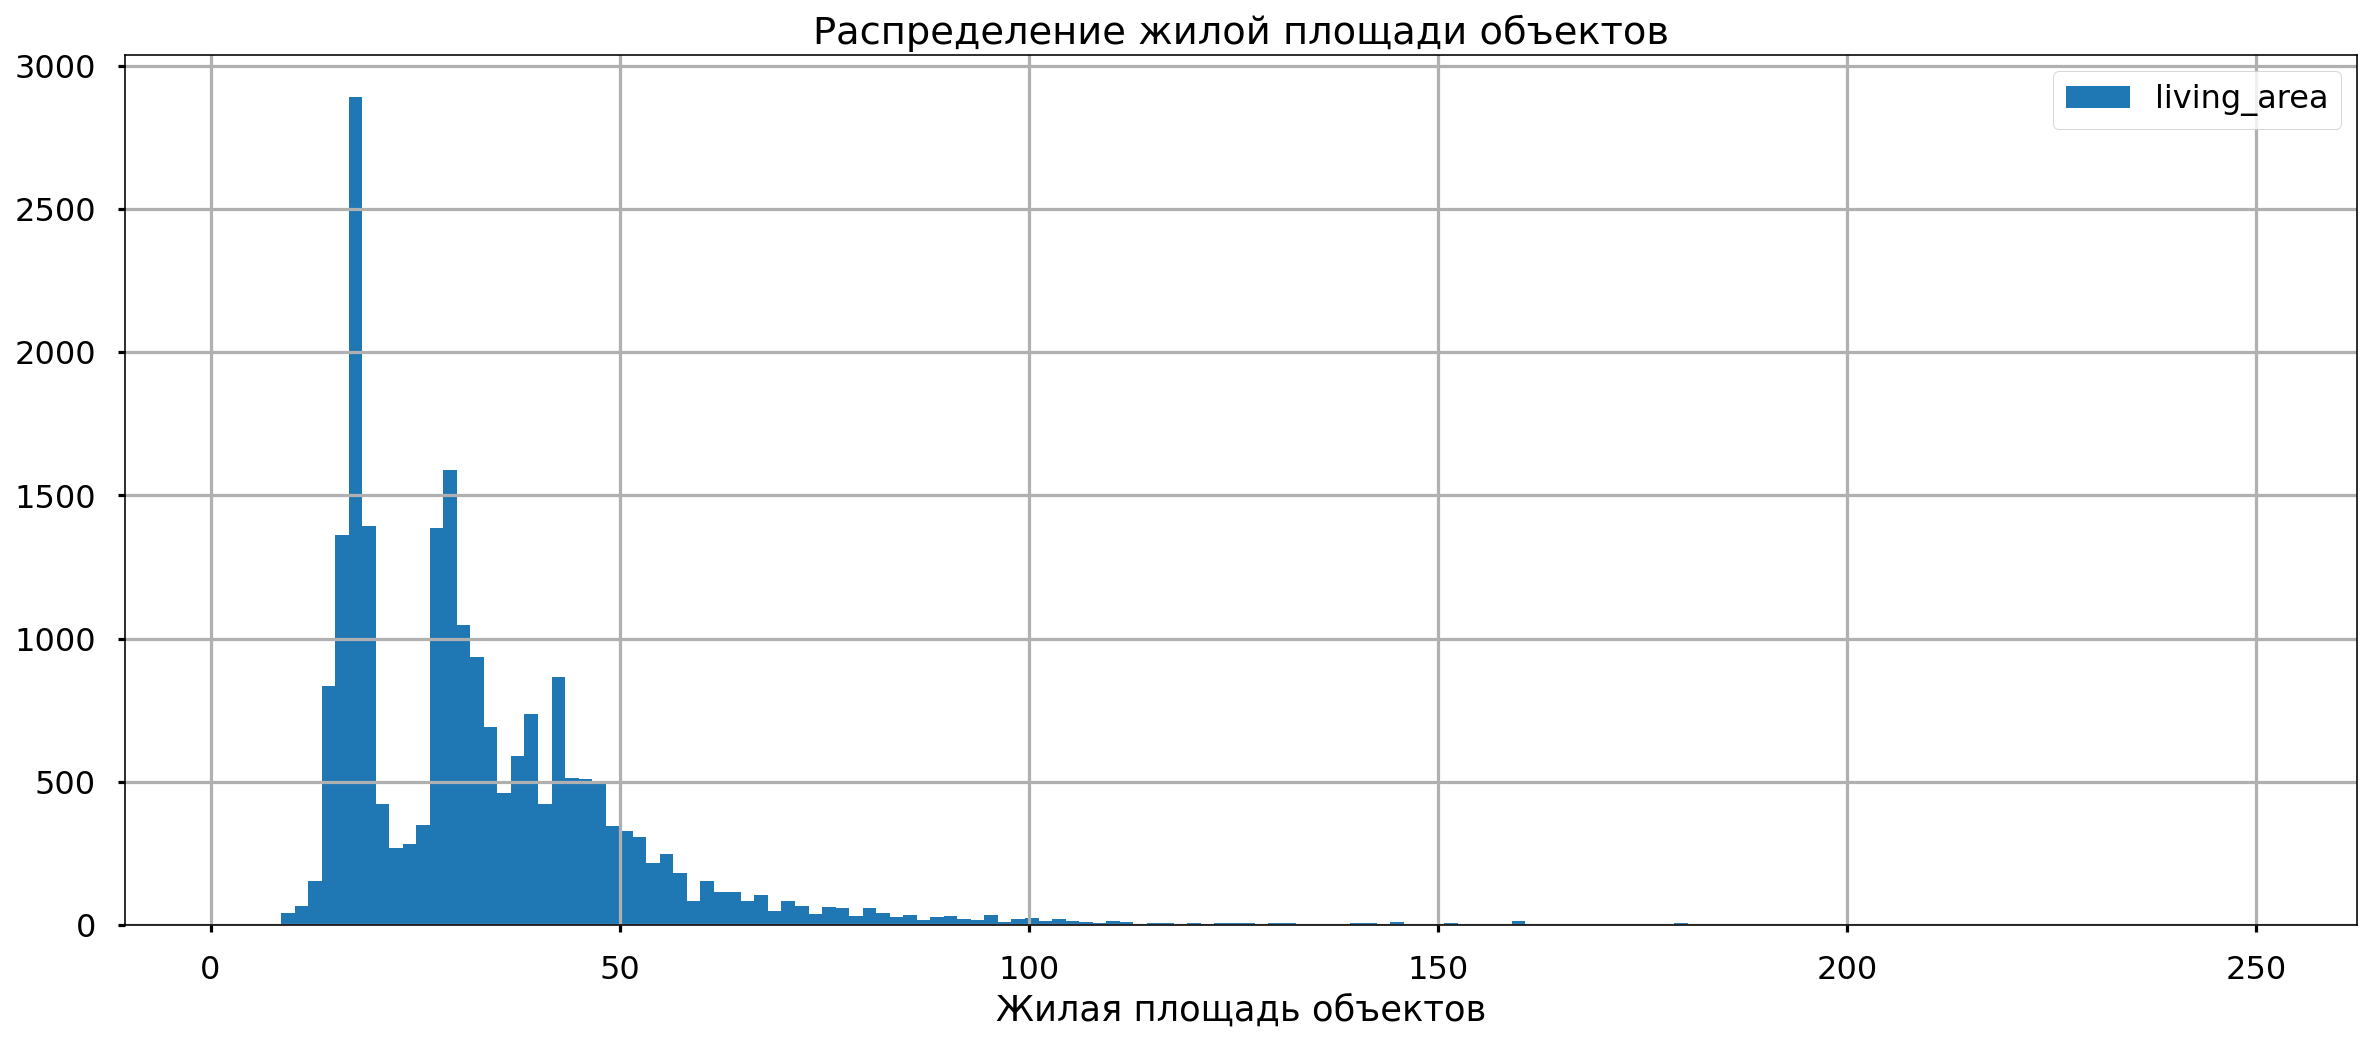

count    21690.000000
mean        34.030805
std         19.825408
min          2.000000
25%         18.600000
50%         30.000000
75%         42.200000
max        250.000000
Name: living_area, dtype: float64


0

In [31]:
# Строю гистограмму по данным о жилой площади квартир
build_hist(data.living_area, 'Жилая площадь объектов', 'Распределение жилой площади объектов', bins=150)
print(data['living_area'].describe())
data['living_area'].isna().sum()

Из гистограммы видно вбросы, вывожу срез данных с ненормальным значением жилой площади.

In [32]:
# Ищу аномалии – объекты с нехарактерными размерами жилой площади
search_anomalies(data, 'living_area', 210, 10)

total_images   last_price  total_area first_day_exposition  rooms  \
21758             0    2330000.0       23.00           2018-01-01      0   
13915            20    6350000.0       52.00           2018-02-06      2   
3242              7    4440000.0       41.00           2017-07-02      1   
23574            14   64990000.0      139.00           2015-11-24      3   
17582            11    2680000.0       22.00           2018-08-11      0   
21943            15    6100000.0       77.60           2019-02-28      4   
16431            13    3799000.0       31.00           2018-04-12      1   
19251            19    4050000.0       33.00           2018-10-15      1   
23208            12    4800000.0       37.00           2016-02-24      1   
20994             7    8900000.0       50.60           2018-10-22      2   
114               5    4000000.0       21.40           2019-02-07      1   
2309             10    4200000.0       62.40           2017-06-15      2   
21505             9    4100000.0       35.30           2018-01-10      1   
17248            20    5300000.0       33.00           2017-04-14      1   
19620            10    4300000.0       33.00           2018-02-01      1   
4100             17    5300000.0       34.80           2017-06-19      1   
15833            20    4600000.0       33.00           2017-01-01      1   
680              14    7200000.0       43.00           2017-10-31      1   
22252             4    3340000.0       37.40           2018-02-08      1   
7312              8    3400000.0       27.00           2018-02-21      2   
8325              9    4800000.0       52.00           2017-10-25      2   
1326              8    8100000.0       52.00           2017-01-29      2   
4542             12    3300000.0       18.00           2018-11-07      1   
22473             0    3490304.0       33.26           2015-12-22      2   
21908             9    5300000.0       46.30           2018-03-20      1   
21393            18    2560000.0       43.00           2017-01-26      1   
19468             4    2450000.0       43.60           2017-09-22      1   
615              15    4100000.0       43.00           2017-06-30      1   
2654              4    3936700.0       42.80           2018-01-02      1   
7460             18    8000000.0       40.00           2018-07-22      1   
19253             6    4990000.0       38.00           2017-08-07      1   
8086              4    3100000.0       38.00           2017-05-22      1   
10439             9    5900000.0       43.00           2018-11-02      1   
8886             10    2450000.0       15.50           2018-08-22      0   
15555            10    3024353.0       35.29           2018-11-04      1   
2699             14    3850000.0       37.10           2017-10-24      1   
19311            12    2190000.0       18.00           2015-03-29      1   
1816              3    1650000.0       22.00           2016-09-19      1   
7829              9    3390000.0       23.00           2019-02-21      1   
1947             11    1400000.0       24.00           2018-06-15      1   
5531              7    1800000.0       26.00           2015-04-07      1   
10291            10    3300000.0       28.00           2019-04-08      1   
248               7    4100000.0       31.00           2015-08-02      1   
12177             5    5299000.0       37.30           2019-03-12      1   
5019             19    4490000.0       32.40           2018-09-19      1   
10520             1    2600000.0       32.00           2018-03-06      1   
21368             8    2950000.0       33.00           2016-10-06      1   
12387            15    4000000.0       33.00           2019-03-16      1   
14103             4    3650000.0       34.00           2017-08-15      1   
4797             10    3638724.0       34.36           2018-10-11      1   
7700             10    3001767.0       35.29           2018-10-01      1   
23359            10    3114406.0       36.13           

In [33]:
data = filter_values(data, 'living_area', 210, 10)
search_anomalies(data, 'living_area', 210, 10)

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_meter, day_of_week_exposition, month_exposition, year_exposition, floor_type, cityCenters_nearest_km]
Index: []

[0 rows x 28 columns]

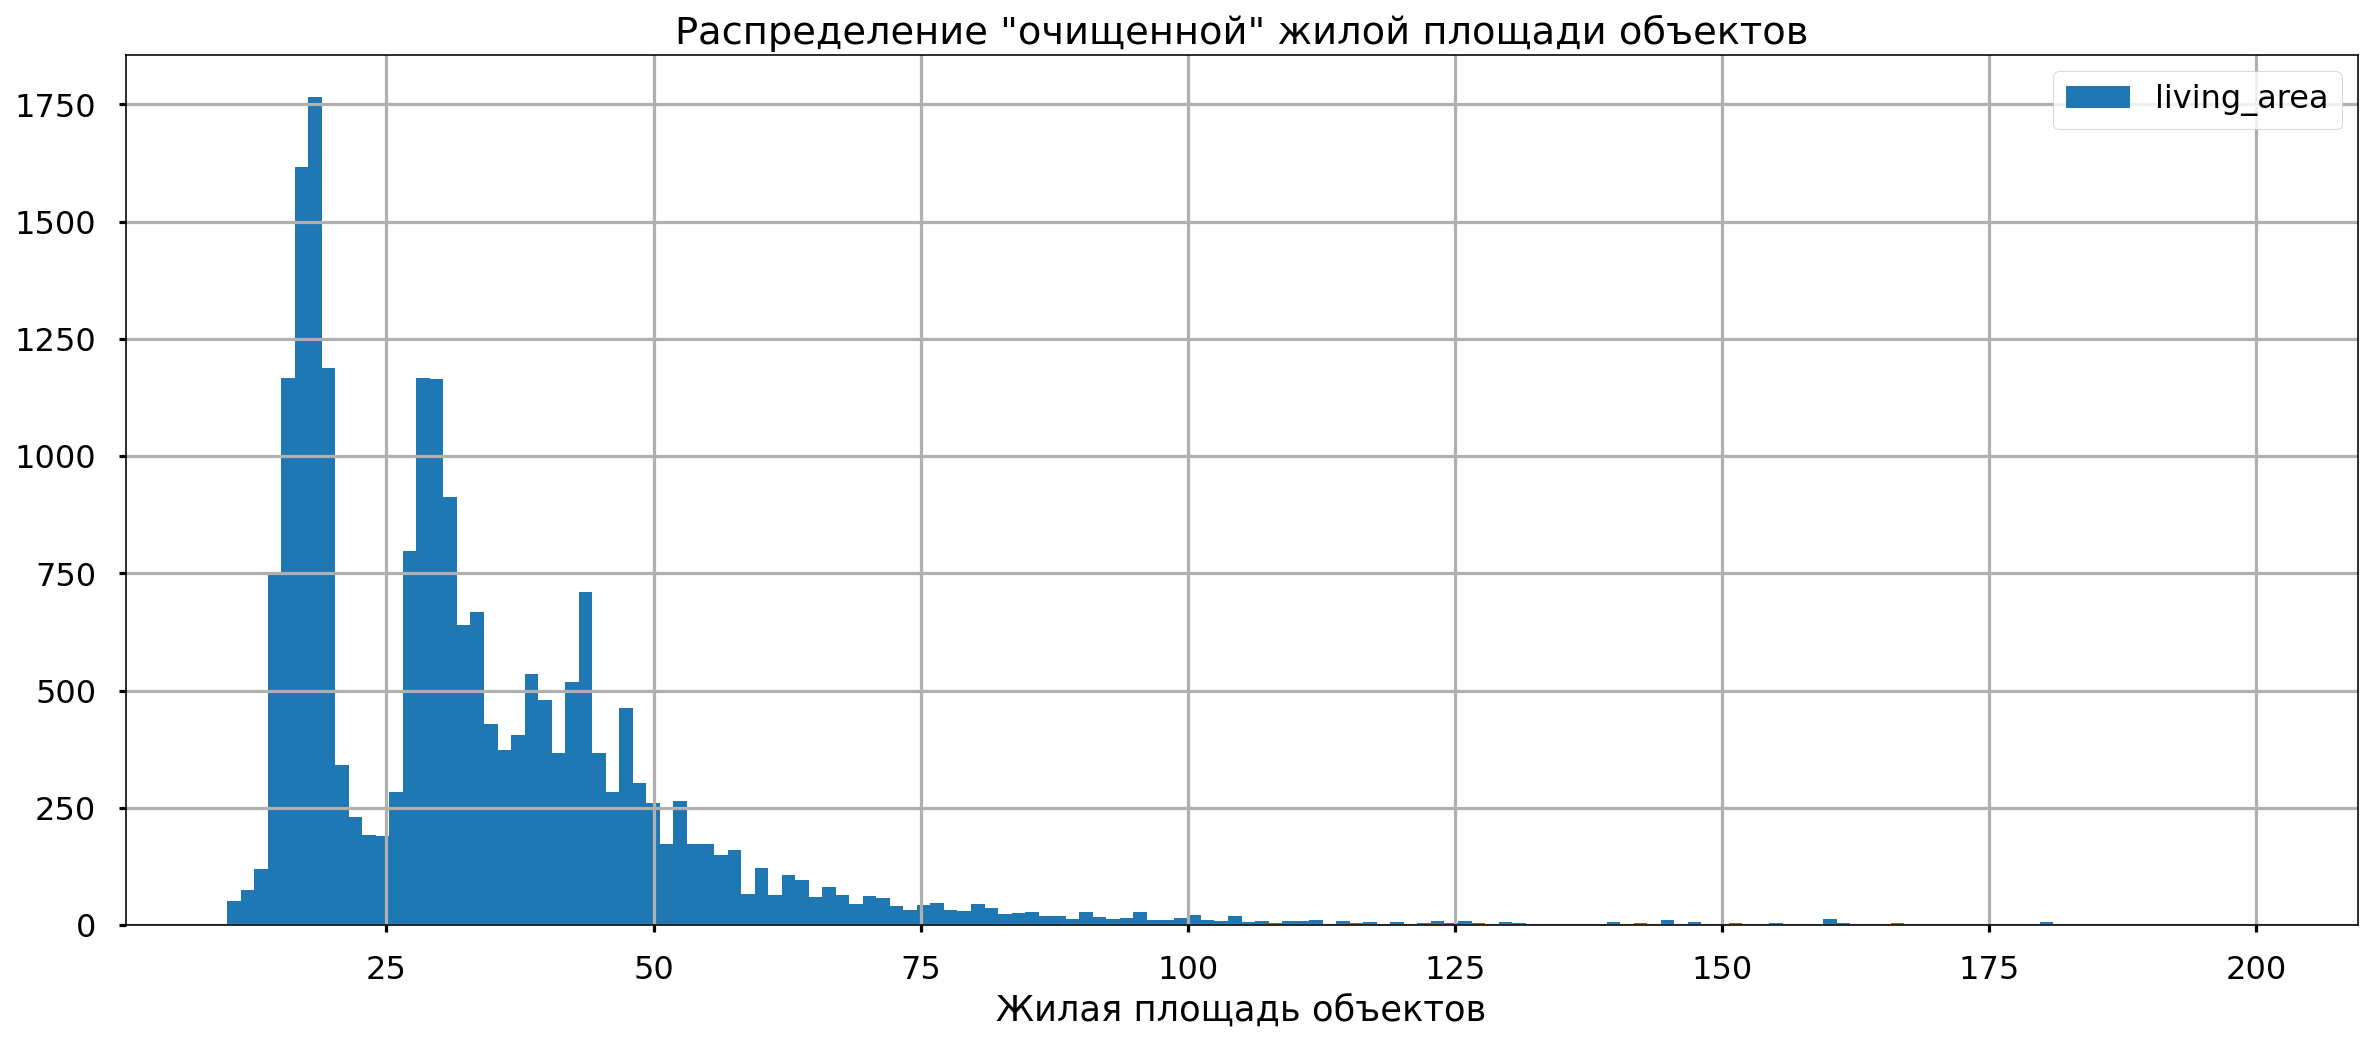

count    21632.000000
mean        34.058263
std         19.636426
min         10.080000
25%         18.607500
50%         30.000000
75%         42.200000
max        200.000000
Name: living_area, dtype: float64

In [34]:
# Строю гистограмму по данным о жилой площади квартир
build_hist(data.living_area, 'Жилая площадь объектов', 'Распределение "очищенной" жилой площади объектов', bins=150)
data['living_area'].describe()

На гистограмме заметный всплеск по количеству объектов около 18 кв.м. и мЕньшие на площади около 30 кв.м. и 45 кв.м.   
    
Проанализирую параметр площади кухни и построю график распределения для этих трёх площадей между собой.

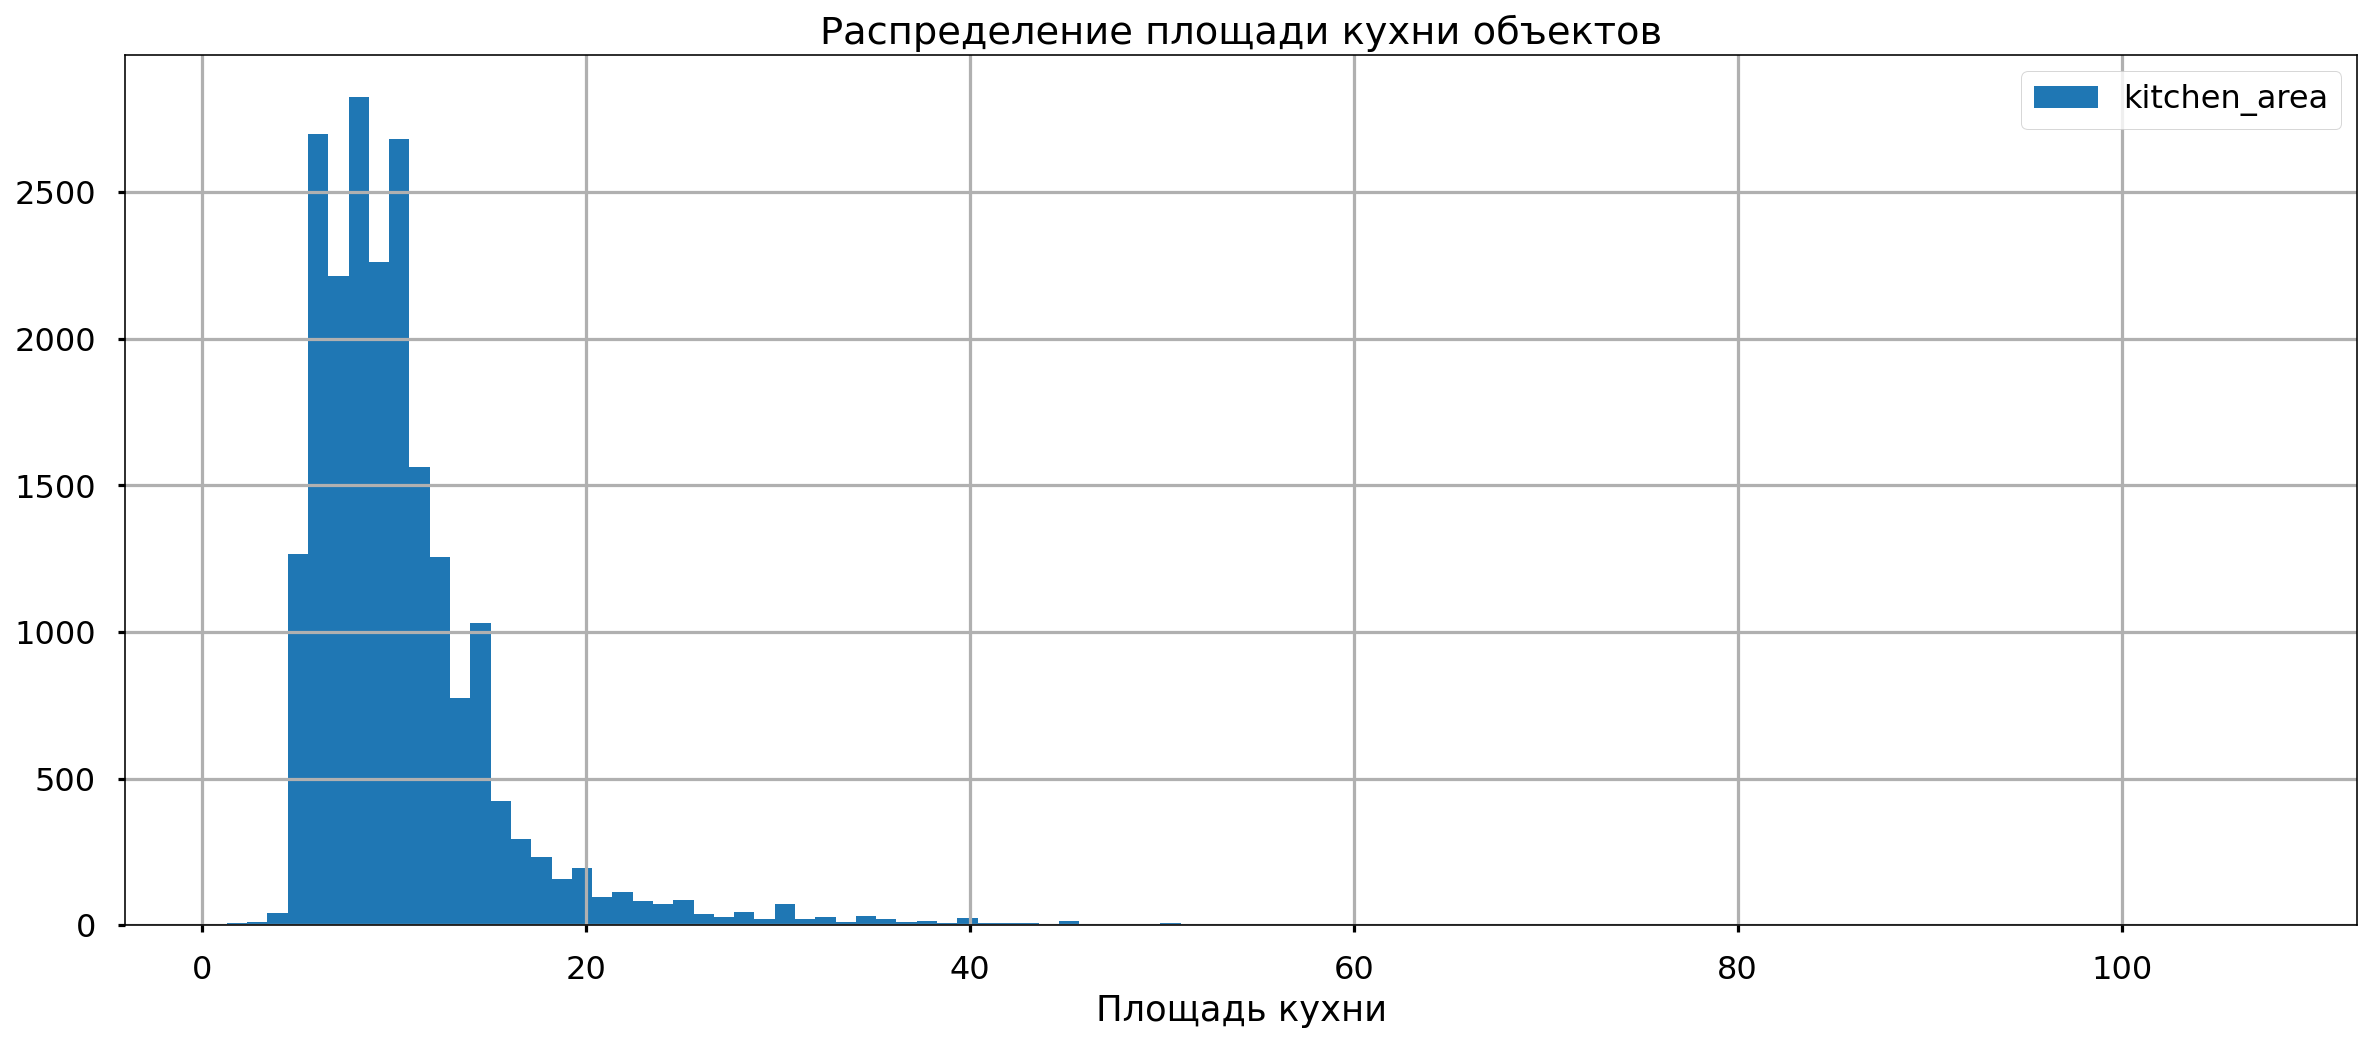

count    20851.000000
mean        10.437344
std          5.603938
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64


781

In [35]:
# Строю гистограмму по данным о площади кухни квартир
build_hist(data.kitchen_area, 'Площадь кухни', 'Распределение площади кухни объектов', bins=100)
print(data['kitchen_area'].describe())
data['kitchen_area'].isna().sum()

Из гистограммы по `kitchen_area` видны вбросы — небольшое количество объектов с площадью около 3 кв.м. и свыше 60 кв.м.   
Последовательный вызов методов `isna()` и `sum()` показывает 781 строку с пропусками в значении площади кухни. Это могут быть студии, квартиры без выделенной кухни или пропуском при заполнении. Во избежание потери этих данных заполню их нулями и исключу при анализе.  
Выведу срезы по этим вбросам и избавлюсь от аномалий.

In [36]:
# Заполняю пропуски по площади кухни нулями
data['kitchen_area'].fillna(0, inplace=True)
# вывожу строки с аномальными значениями площади кухни
search_anomalies(data,'kitchen_area', 60, -1)

total_images   last_price  total_area first_day_exposition  rooms  \
13845            12   65000000.0       250.0           2014-12-09      5   
3561              5   12300000.0       115.0           2017-08-09      3   
13139            20   55000000.0       288.0           2017-11-14      5   
14900            20   25900000.0       125.6           2018-08-14      2   
19130            11   40000000.0       153.0           2017-09-02      3   
17912            17  135000000.0       166.0           2019-02-07      3   
19499            10    8000000.0       118.0           2017-08-31      3   
15780             9   12990000.0       119.6           2017-03-13      3   
22980            19   24500000.0       155.4           2017-10-10      3   
18447            17   21800000.0       187.0           2018-01-14      5   
6193             19   24300000.0       230.0           2016-06-03      4   
16647            15  122000000.0       145.0           2017-04-25      3   
14644            17   47000000.0       150.0           2017-02-28      4   
492              18   95000000.0       216.0           2017-12-05      4   
4394             20   57000000.0       174.0           2015-11-09      3   
10867             1   56844500.0       177.9           2015-01-15      3   
16797             9   65850000.0       146.0           2017-07-14      2   
16239             5   82400000.0       181.1           2017-05-24      3   
2489              9   12500000.0       255.0           2017-04-21      3   
20215             2   85000000.0       249.7           2018-02-01      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
13845            3.10           5.0        167.0      5         False  ...   
3561             2.70          20.0         45.0     16         False  ...   
13139            3.51           6.0        100.7      2         False  ...   
14900            4.00           4.0         42.7      4         False  ...   
19130            3.30          10.0         45.2      7         False  ...   
17912            3.30           7.0         52.0      1         False  ...   
19499            3.00           5.0         36.0      4         False  ...   
15780            3.00           5.0         36.4      4         False  ...   
22980            3.00           4.0         72.0      2         False  ...   
18447             NaN           4.0        120.0      4         False  ...   
6193              NaN           3.0         90.0      2         False  ...   
16647            3.30           6.0         36.0      2         False  ...   
14644            3.70           6.0         58.0      5         False  ...   
492              3.00           5.0         86.0      4         False  ...   
4394             3.20          10.0         95.0      6         False  ...   
10867             NaN           6.0         87.2      5          True  ...   
16797             NaN           9.0         40.0      3         False  ...   
16239            3.90           9.0         58.2      4         False  ...   
2489              NaN           2.0        153.9      2         False  ...   
20215             NaN          10.0         72.0      9         False  ...   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
13845          286.0               3.0          577.0              714   
3561             NaN               0.0            NaN               63   
13139          175.0               1.0          682.0              338   
14900            NaN               0.0            NaN              194   
19130            NaN               NaN            NaN              455   
17912          230.0               3.0          215.0                0   
19499          569.0               0.0            NaN                7   
15780          569.0               0.0            NaN                0   
22980          756.0               2.0          278.0              325   
18447          756.0           

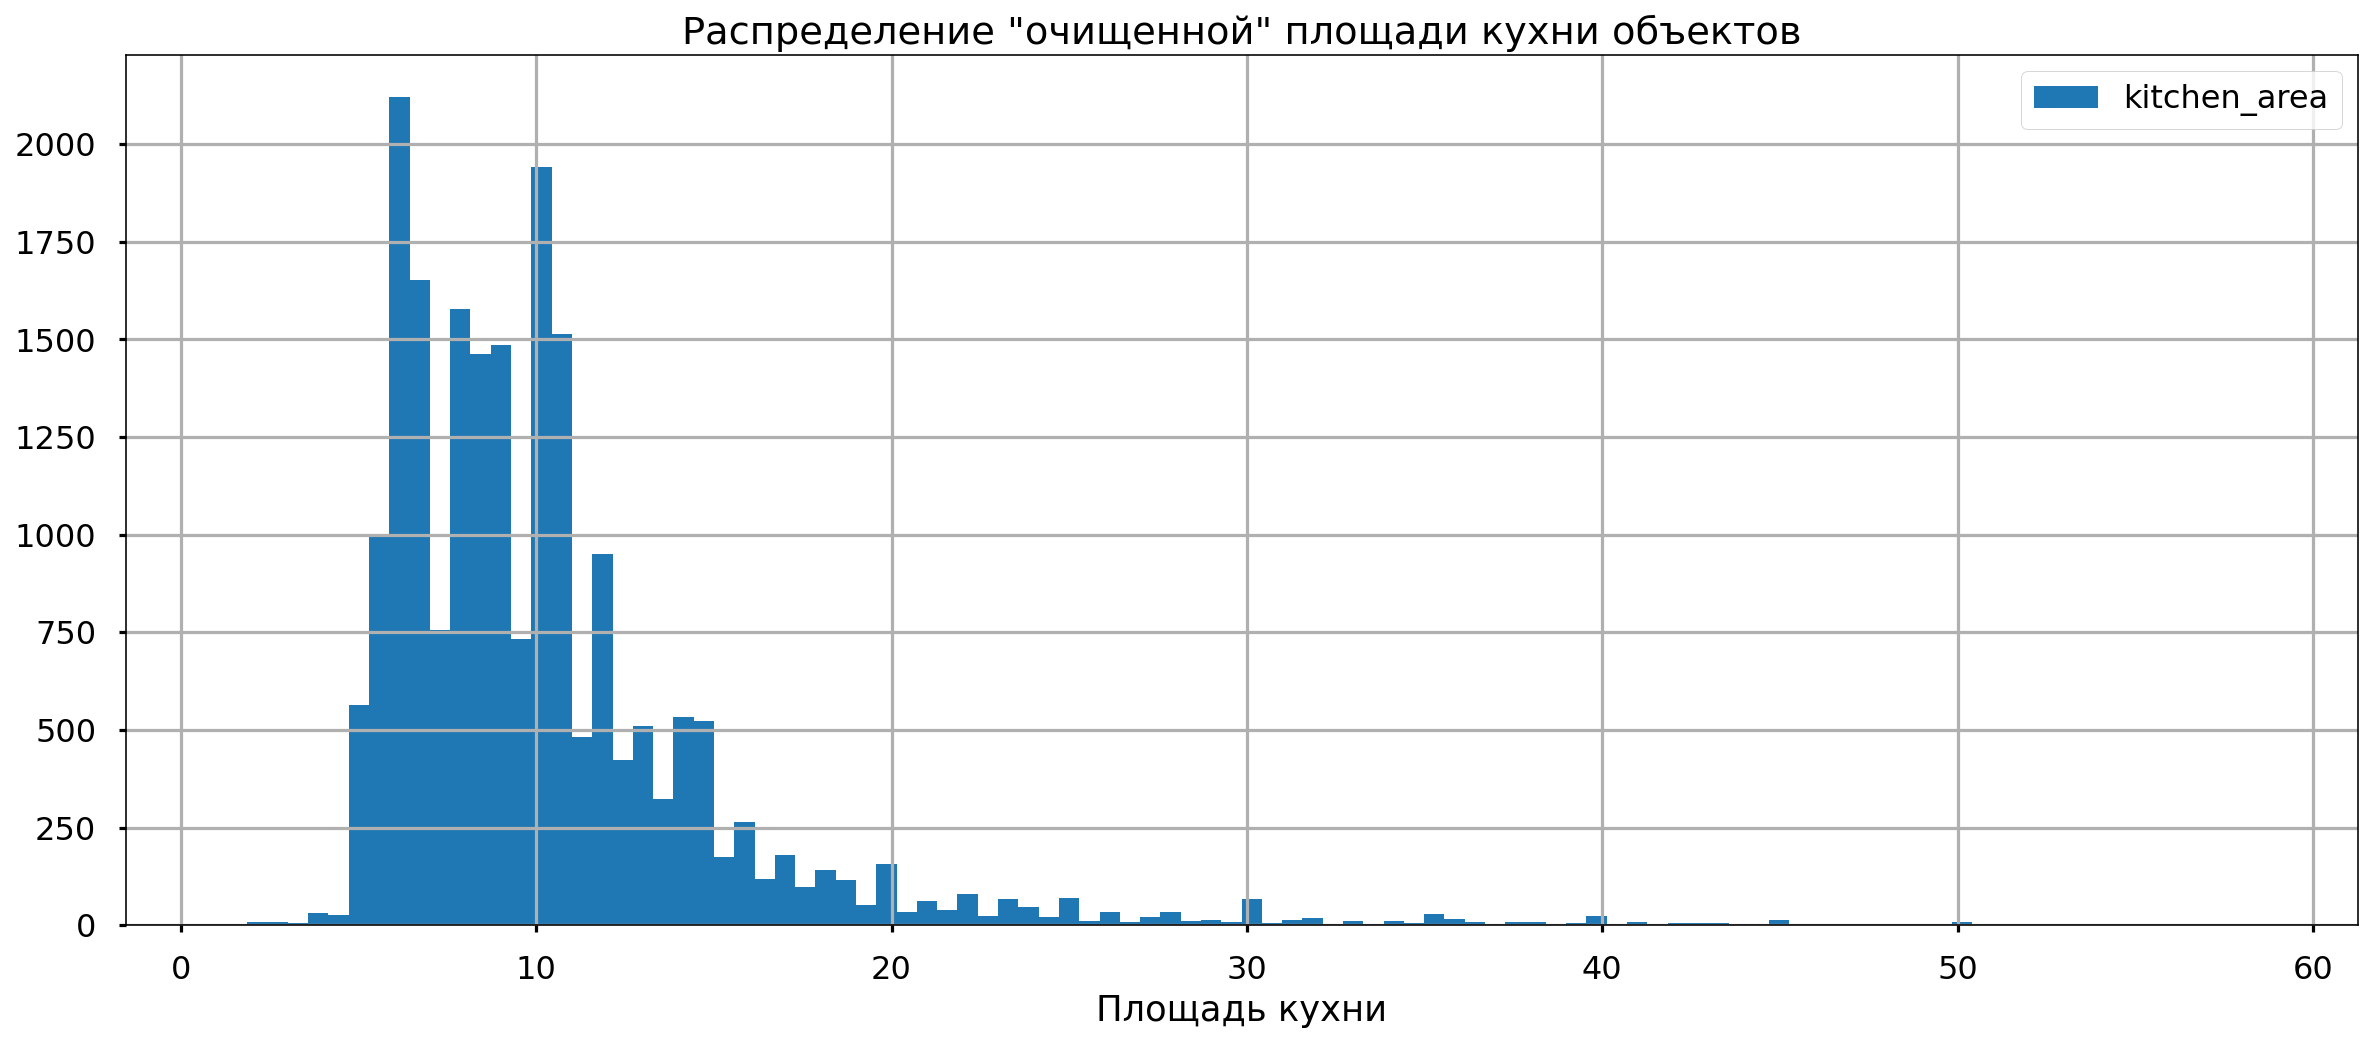

count    21612.000000
mean        10.001271
std          5.487410
min          0.000000
25%          7.000000
50%          9.000000
75%         11.600000
max         58.400000
Name: kitchen_area, dtype: float64


0

In [37]:
data = filter_values(data, 'kitchen_area', 60, -1)
# Строю гистограмму по данным о площади кухни квартир и вывожу агрегированные данные по параметру
build_hist(data[data['kitchen_area'] != 0].kitchen_area, 'Площадь кухни', 'Распределение "очищенной" площади кухни объектов', bins=100)
print(data['kitchen_area'].describe())
data['kitchen_area'].isna().sum()

Медианное значение площади кухни на исследуемых объектах – 9 кв.м., "пики" отмечены около 7 кв.м., 10 кв.м., 11 кв.м. Нулевые значения из графика удалила, далее оценю соотношение распределения трёх площадей между собой.
    
Гистограммы построенные на основании данных площадей объектов визуально отражают существенные разбросы значений.   
    
Для сравнения нюансов распределения значений воспользуемся методом `boxplot()`.

(-10.0, 300.0)

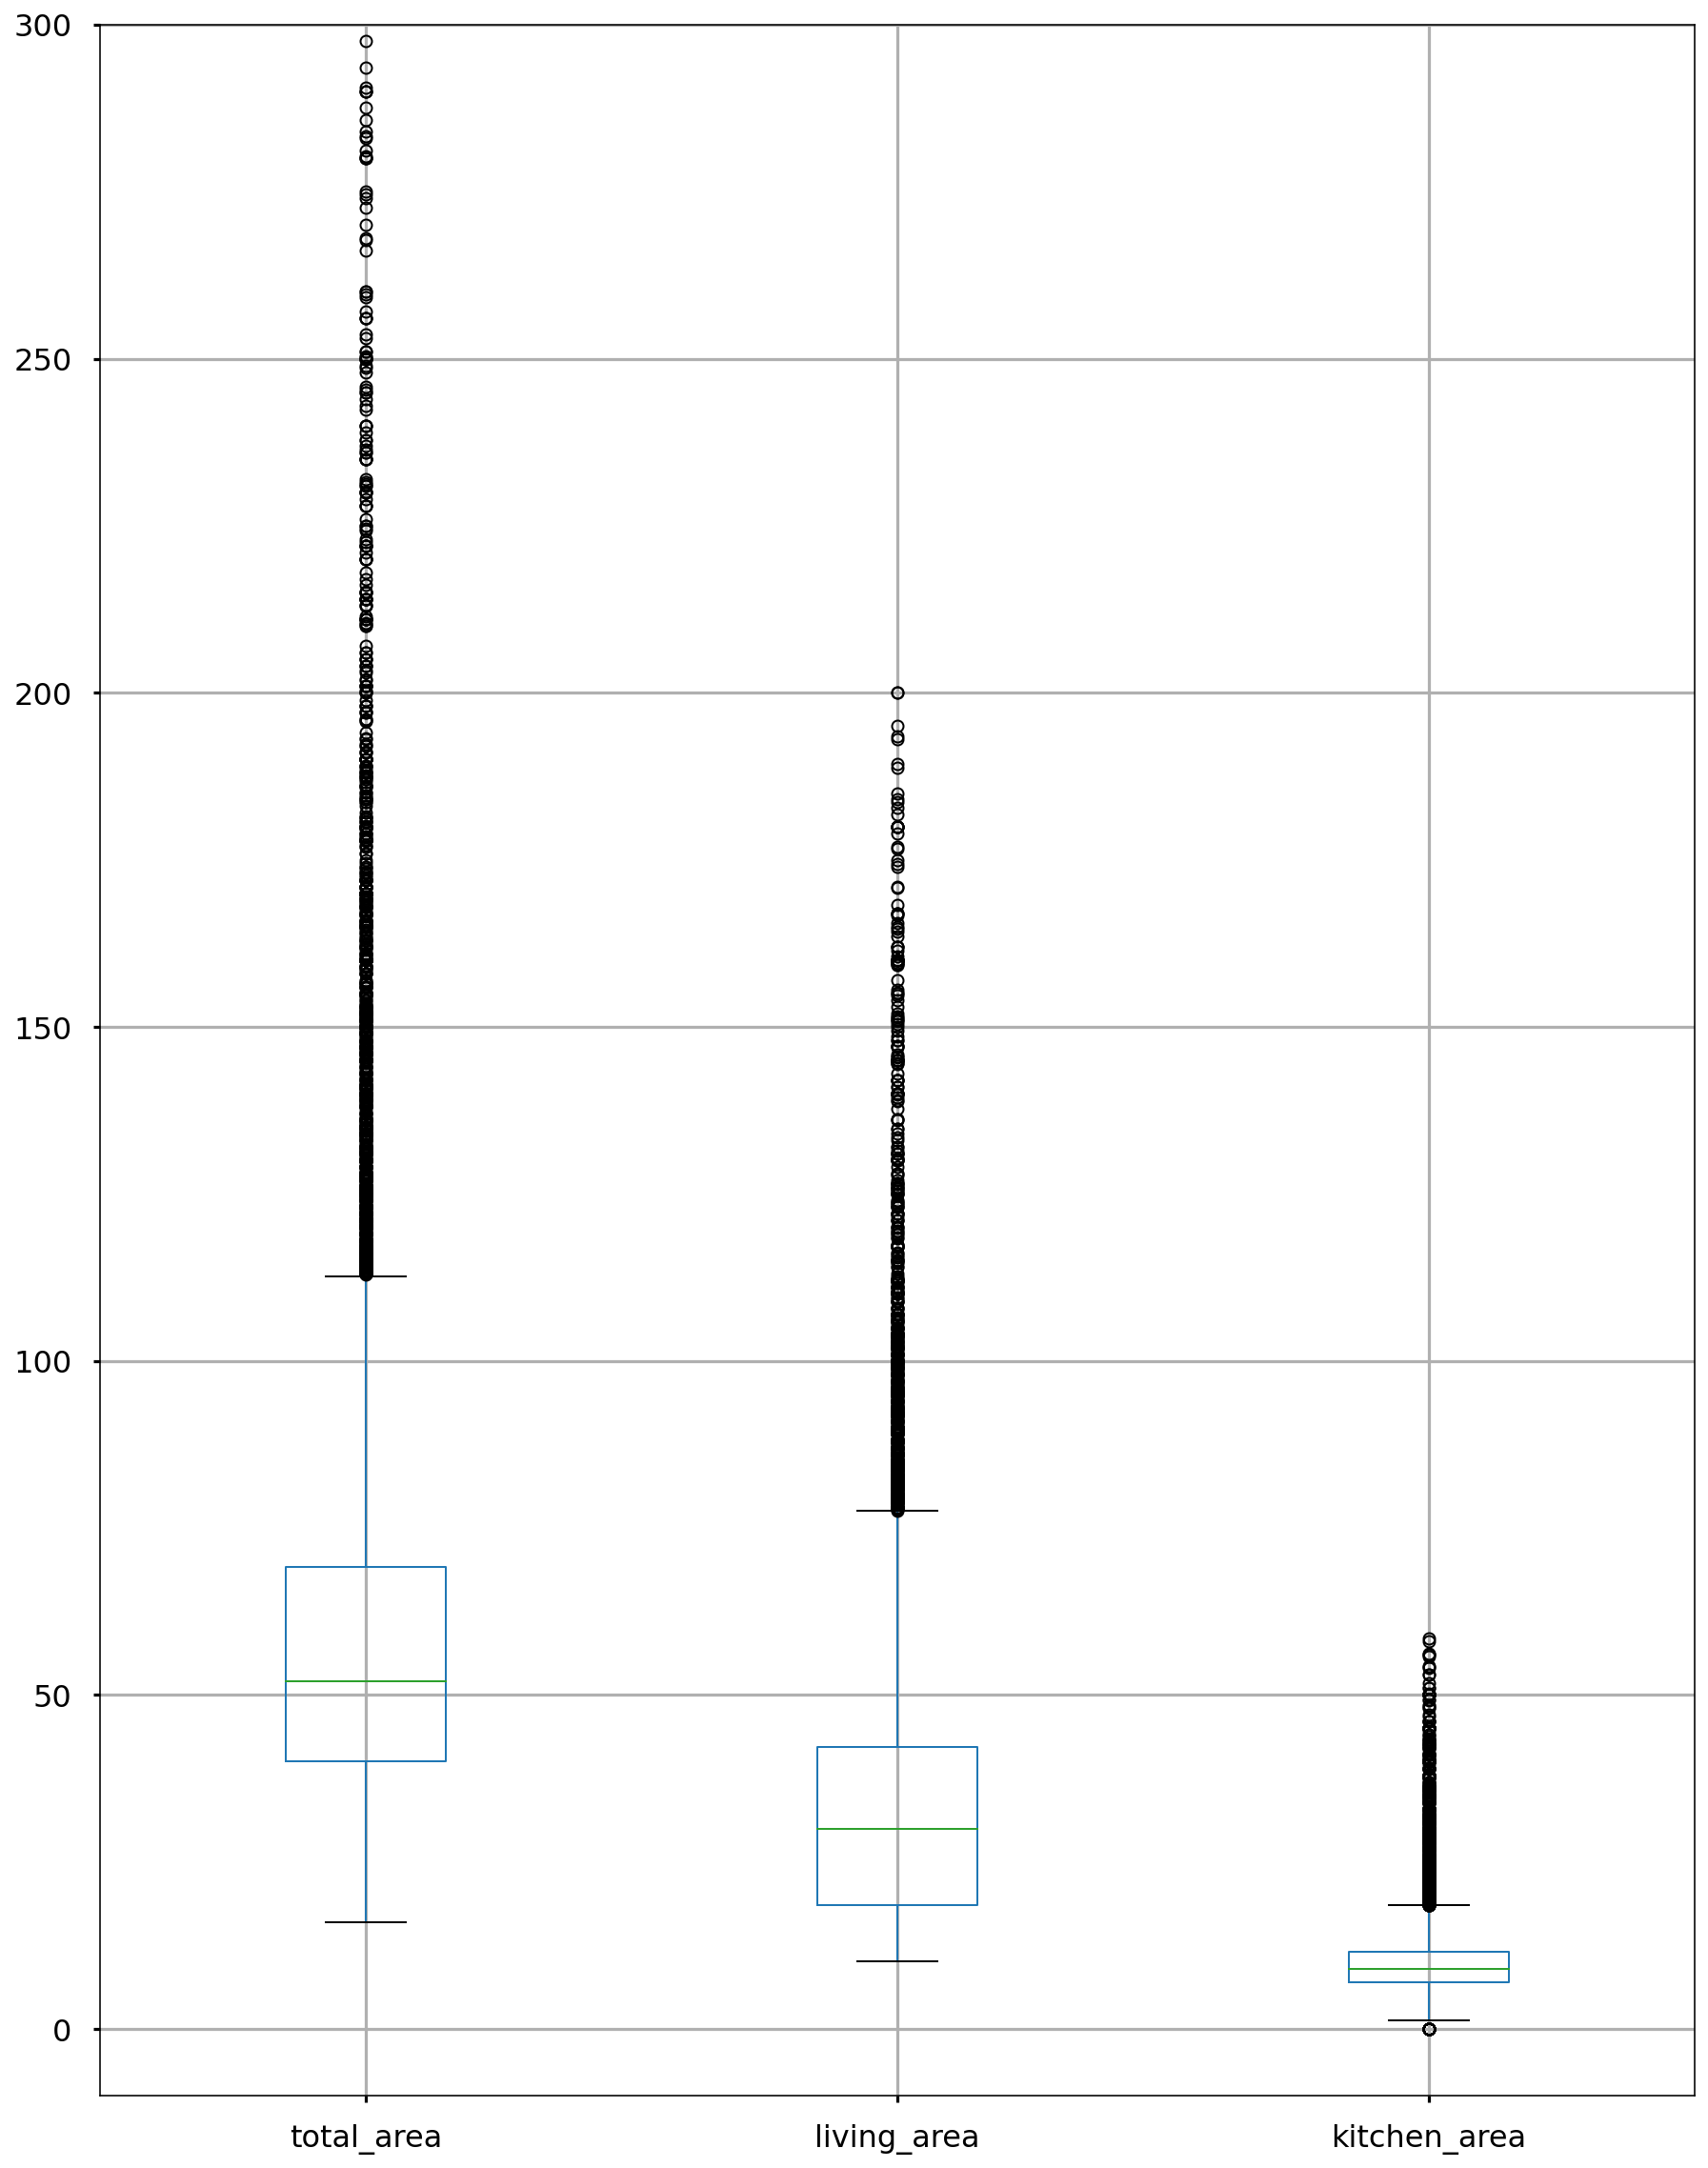

In [38]:
data_area=data[['total_area', 'living_area', 'kitchen_area']]

data_area.boxplot(figsize=(15, 20), grid=True)
plt.ylim(-10,300)

`boxplot` отражает разброс, квартили распределения, медианные значения по каждому из параметров отмечены зелёной чертой.   

Следует также учитывать, что нулевой вброс по кухне, отмеченный на графике влияет на среднее и медианное значение.  

In [39]:
data_area.describe()

total_area   living_area  kitchen_area
count  21612.000000  21612.000000  21612.000000
mean      59.203082     34.020685     10.001271
std       29.825839     19.573560      5.487410
min       16.000000     10.080000      0.000000
25%       40.000000     18.600000      7.000000
50%       52.000000     30.000000      9.000000
75%       69.100000     42.200000     11.600000
max      297.500000    200.000000     58.400000

Диаграмма размаха `boxplot` визуально демонстрирует разброс значений после очистки от явных вбросов. А вызов метода `describe()` отражает нюансы распределения значений: среднее, медиану, максимальное и минимальное значения, стандартное отклонение, количество наблюдений в выборке, разброс их значений и т.п. 

*Вияние этих и других параметров на цену объекта, скорость продажи и другие интересующие нас показатели проанализируем позднее.*

Теперь построю гистограмму по цене продажи.

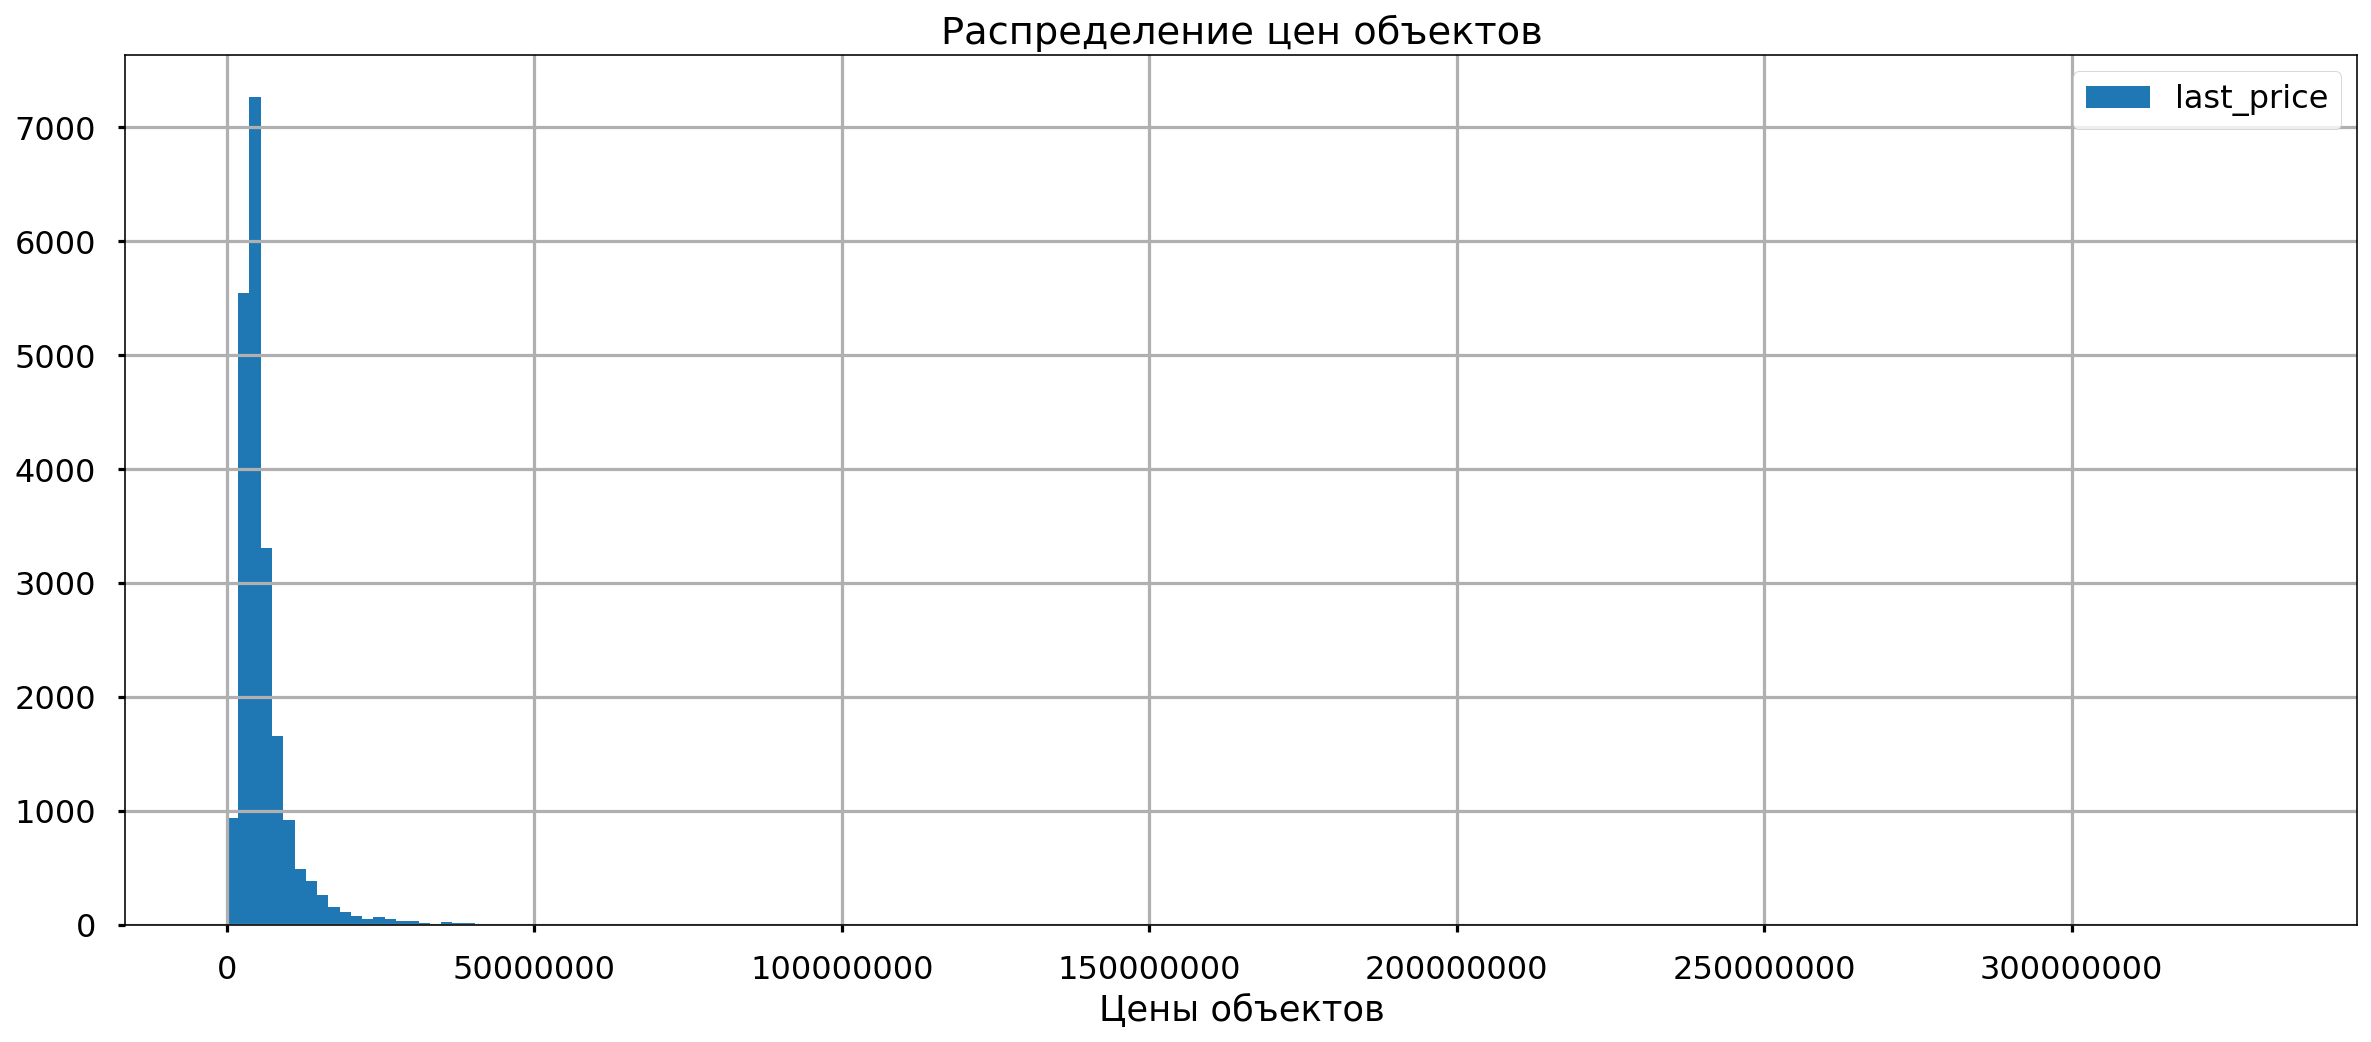

In [40]:
# Строю гистограмму и вывожу нюансы распределения по данным о ценах на квартиры 
build_hist(data.last_price, 'Цены объектов', 'Распределение цен объектов', figsize=(20, 8), bins=180)

Гистограмма и вызов метода `describe()` указывают на наличие вбросов.  
Фильтрую самые низкие и высокие цены для изучения аномалий.

In [41]:
# Ищу аномалии в ценах объектов
search_anomalies(data, 'last_price', 50000000, 100000)
# Значения со слишком большой ценой можно не анализировать, из-за достаточного количества сопоставимых данных

total_images   last_price  total_area first_day_exposition  rooms  \
8793              7      12190.0       109.0           2019-03-20      2   
2356             11   50000000.0       128.0           2016-06-24      3   
674              11   50000000.0       131.1           2019-02-11      4   
4910             14   50000000.0       166.0           2016-02-01      4   
7726             20   50000000.0        93.0           2019-04-18      2   
...             ...          ...         ...                  ...    ...   
19155            20  160000000.0       243.0           2018-11-12      5   
8900             13  190870000.0       268.0           2016-03-25      3   
16461            17  245000000.0       285.7           2017-04-10      6   
22831            18  289238400.0       187.5           2019-03-19      2   
1436             19  330000000.0       190.0           2018-04-04      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
8793             2.75          25.0         32.0     25         False  ...   
2356              NaN           9.0         42.0      1         False  ...   
674              3.00          12.0         80.8      6         False  ...   
4910              NaN           7.0        110.0      6         False  ...   
7726              NaN           7.0         40.0      4         False  ...   
...               ...           ...          ...    ...           ...  ...   
19155             NaN           5.0        145.0      4         False  ...   
8900              NaN           8.0        132.0      7         False  ...   
16461            3.35           7.0        182.8      4         False  ...   
22831            3.37           6.0         63.7      6         False  ...   
1436             3.50           7.0         95.0      5         False  ...   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
8793           805.0               0.0            NaN                8   
2356           625.0               1.0          283.0               27   
674              NaN               3.0          121.0                0   
4910           376.0               1.0          823.0                0   
7726           160.0               3.0          569.0                0   
...              ...               ...            ...              ...   
19155          285.0               1.0          200.0               18   
8900             NaN               2.0          198.0              901   
16461          400.0               3.0          140.0              249   
22831          386.0               3.0          188.0                0   
1436           519.0               3.0          285.0              233   

      price_per_meter  day_of_week_exposition  month_exposition  \
8793           111.83                       2                 3   
2356        390625.00                       4                 6   
674         381388.25                       0                 2   
4910        301204.82                       0                 2   
7726        537634.41                       3                 4   
...               ...                     ...               ...   
19155       658436.21                       0                11   
8900        712201.49                       4                 3   
16461       857542.88                       0                 4   
22831      1542604.80                       1                 3   
1436       1736842.11                       2                 4   

       year_exposition  floor_type  cityCenters_nearest_km  
8793              2019   последний                     9.0  
2356              2016      первый                     6.0  
674               2019      другой                     7.0  
4910              2016      другой                     5.0  
7726              2019      другой                     0.0  
...                ...         ...                     ...  
19155             2018      другой  

In [42]:
# Вывожу особенности распределения методом `describe()`
data['last_price'].describe().astype(int)

count        21612
mean       6234029
std        7478233
min          12190
25%        3450000
50%        4650000
75%        6700000
max      330000000
Name: last_price, dtype: int64

Обнаружено 82 вброса, среди них одно значение с ненормально низкой ценой объекта. 

Обращаю внимание, что площадь объекта — 109 кв.м. Предполагаю, что при указании цены автор объявления подразумевал "тыс. руб." Преобразую данные столбца, умножив значения на 1000, также преобразую столбец с ценой квадратного метра 'price_per_meter'.

Строки с очень высокими ценами удаляю из датафрейма. При необходимости сможем вернуться к датафрейму и data_abnormal_last_price и проанализировать их

In [43]:
# заменяем в датафрейме вбросы по цене с ошибкой
data['last_price'].replace(12190, 12190000, inplace=True)
data['price_per_meter'].replace(111.83, 111830, inplace=True)
search_anomalies(data, 'last_price', 50000000, 100000) # Проверяю, что строка исправлена

total_images   last_price  total_area first_day_exposition  rooms  \
7726             20   50000000.0        93.0           2019-04-18      2   
2356             11   50000000.0       128.0           2016-06-24      3   
4910             14   50000000.0       166.0           2016-02-01      4   
3017              6   50000000.0       145.0           2018-08-10      5   
674              11   50000000.0       131.1           2019-02-11      4   
...             ...          ...         ...                  ...    ...   
19155            20  160000000.0       243.0           2018-11-12      5   
8900             13  190870000.0       268.0           2016-03-25      3   
16461            17  245000000.0       285.7           2017-04-10      6   
22831            18  289238400.0       187.5           2019-03-19      2   
1436             19  330000000.0       190.0           2018-04-04      3   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
7726              NaN           7.0         40.0      4         False  ...   
2356              NaN           9.0         42.0      1         False  ...   
4910              NaN           7.0        110.0      6         False  ...   
3017             2.75           9.0         72.0      8         False  ...   
674              3.00          12.0         80.8      6         False  ...   
...               ...           ...          ...    ...           ...  ...   
19155             NaN           5.0        145.0      4         False  ...   
8900              NaN           8.0        132.0      7         False  ...   
16461            3.35           7.0        182.8      4         False  ...   
22831            3.37           6.0         63.7      6         False  ...   
1436             3.50           7.0         95.0      5         False  ...   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
7726           160.0               3.0          569.0                0   
2356           625.0               1.0          283.0               27   
4910           376.0               1.0          823.0                0   
3017           479.0               3.0          283.0              128   
674              NaN               3.0          121.0                0   
...              ...               ...            ...              ...   
19155          285.0               1.0          200.0               18   
8900             NaN               2.0          198.0              901   
16461          400.0               3.0          140.0              249   
22831          386.0               3.0          188.0                0   
1436           519.0               3.0          285.0              233   

      price_per_meter  day_of_week_exposition  month_exposition  \
7726        537634.41                       3                 4   
2356        390625.00                       4                 6   
4910        301204.82                       0                 2   
3017        344827.59                       4                 8   
674         381388.25                       0                 2   
...               ...                     ...               ...   
19155       658436.21                       0                11   
8900        712201.49                       4                 3   
16461       857542.88                       0                 4   
22831      1542604.80                       1                 3   
1436       1736842.11                       2                 4   

       year_exposition  floor_type  cityCenters_nearest_km  
7726              2019      другой                     0.0  
2356              2016      первый                     6.0  
4910              2016      другой                     5.0  
3017              2018      другой                     5.0  
674               2019      другой                     7.0  
...                ...         ...                     ...  
19155             2018      другой  

In [44]:
# Значения со слишком большой ценой можно не анализировать, так как нет достаточного количества сопоставимых данных
data = filter_values(data, 'last_price', 50000000, 100000)
# Проверяю, что датафрейм больше не содержит аномалий
search_anomalies(data, 'last_price', 50000000, 100000)

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_meter, day_of_week_exposition, month_exposition, year_exposition, floor_type, cityCenters_nearest_km]
Index: []

[0 rows x 28 columns]

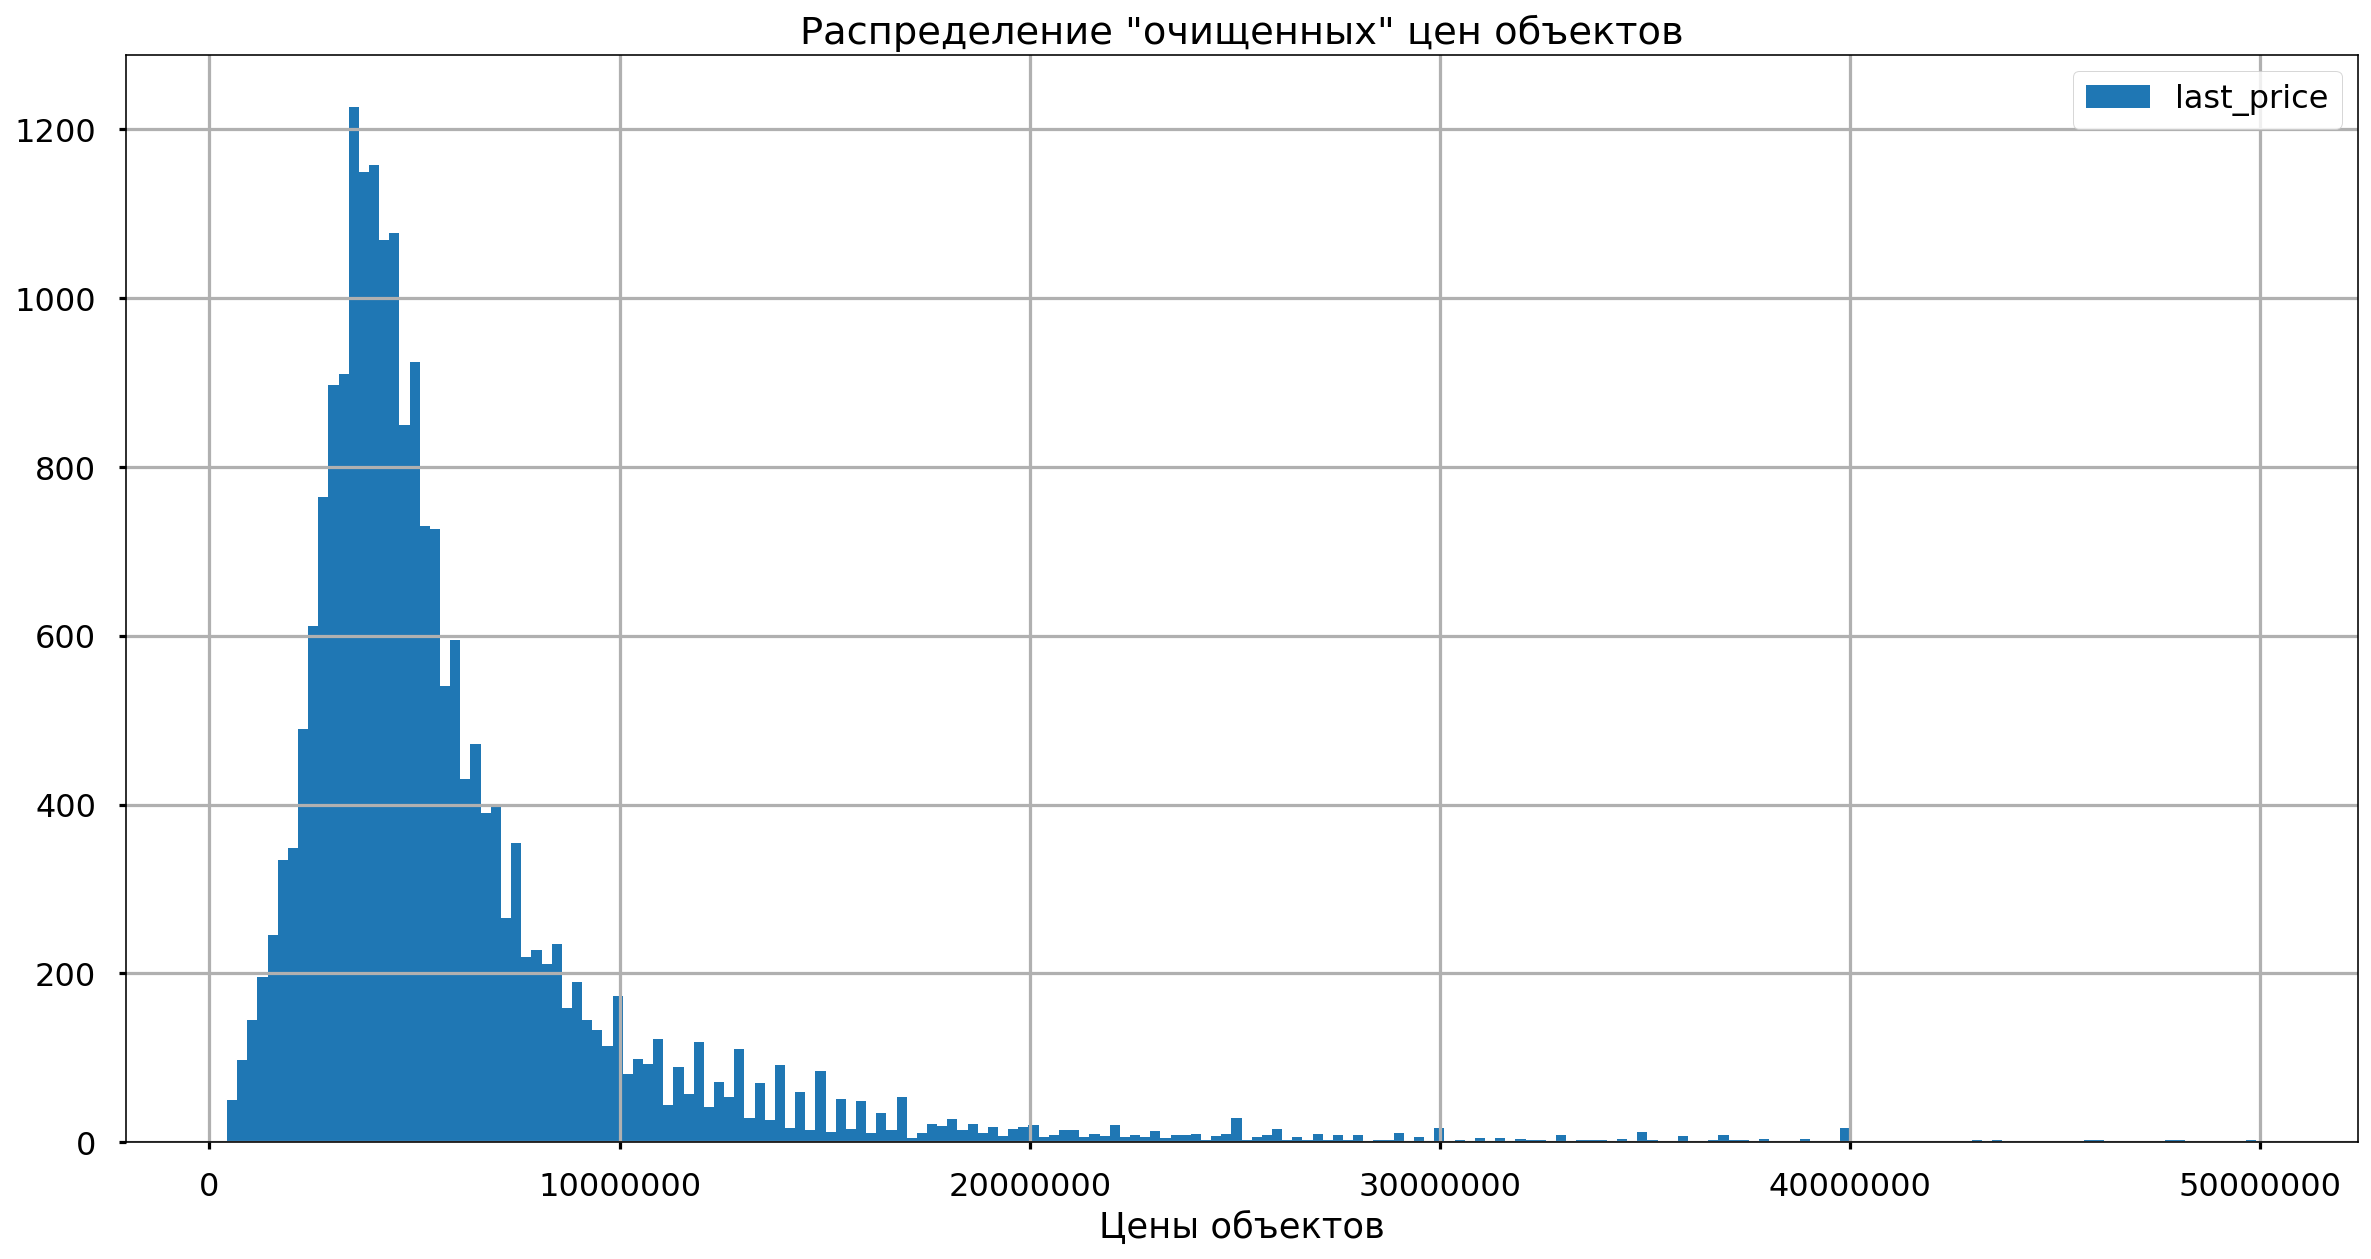

count       21531
mean      5933153
std       4725691
min        430000
25%       3450000
50%       4630000
75%       6700000
max      49900000
Name: last_price, dtype: int64

In [45]:
# Строю гистограмму после очистки данных от аномалий
build_hist(data.last_price, 'Цены объектов', 'Распределение "очищенных" цен объектов', figsize=(20, 10), bins=200)
data['last_price'].describe().astype(int)

Исследуя цены объектов датафрейма после чистки от аномалий получены:   
- среднее значение — 5 933 153 руб. при стандартном отклонении 4 725 691 руб.
- медианное значение цены объекта 4 630 000 руб. 
    
Цены могут существенно отличаться в зависимости от различных параметров или их комплекса. На следующих этапах исследуем зависимость цены от локации и прочих параметров.

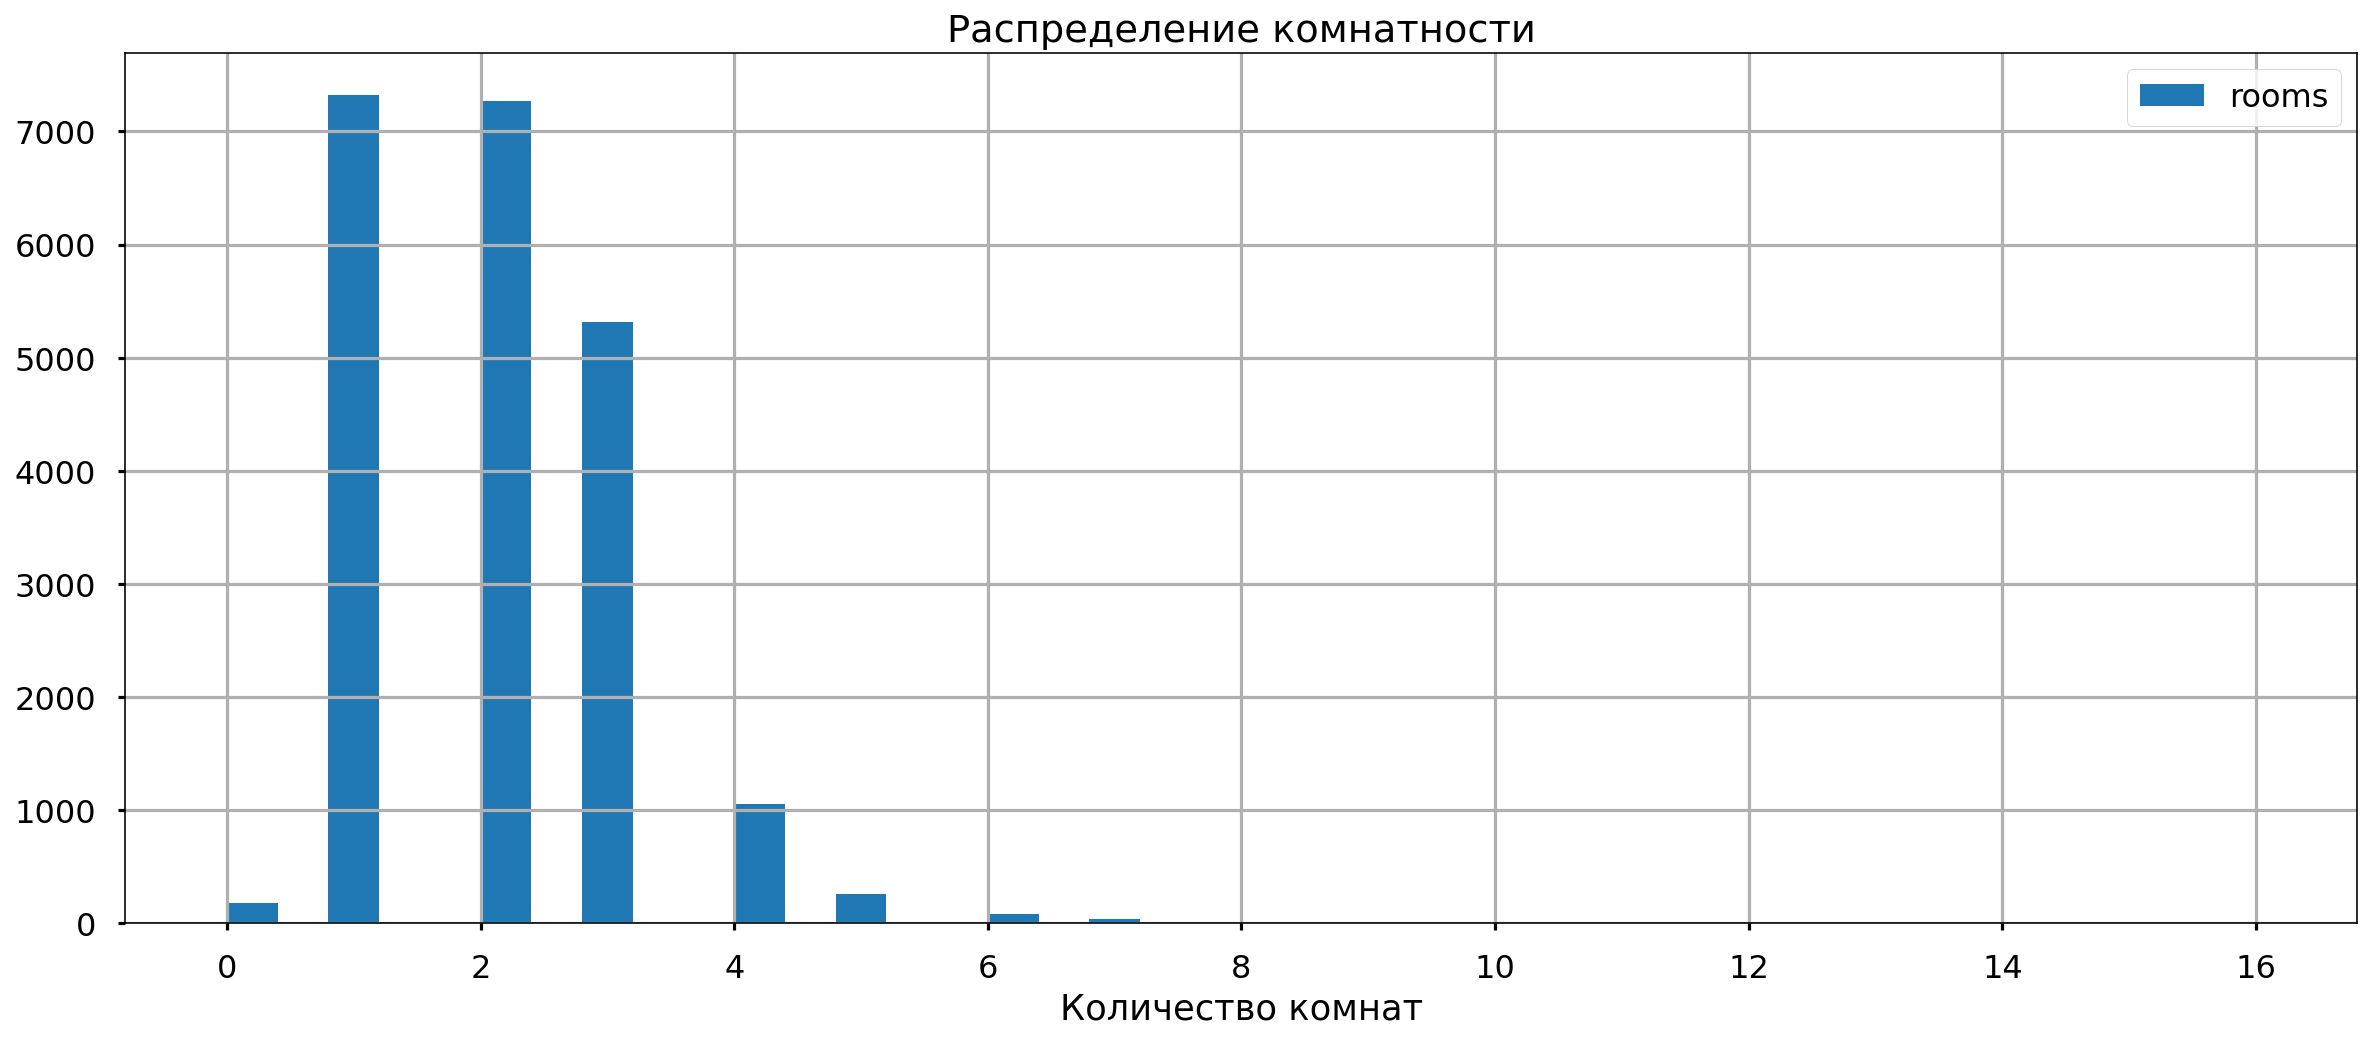

count    21531.000000
mean         2.053226
std          1.035438
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64


0

In [46]:
# Вывожу нюансы распределения 'rooms', а также строю гистограмму по данным о количестве комнат
build_hist(data.rooms, 'Количество комнат', 'Распределение комнатности')
print(data['rooms'].describe())
data['rooms'].isna().sum()

Максимальное количество комнат - 16, проверю сколько таких значений.

In [47]:
# Ищем аномалии в количестве комнат, для удобства "перевернула" таблицу
search_anomalies(data, 'rooms', 6, -1).T

7756                 16656  \
total_images                              1                   19   
last_price                        4390000.0           20000000.0   
total_area                            151.8                198.1   
first_day_exposition    2017-04-28 00:00:00  2018-05-05 00:00:00   
rooms                                     6                    6   
ceiling_height                          3.5                  2.8   
floors_total                            6.0                 12.0   
living_area                           106.5                118.4   
floor                                     6                   11   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           14.3                 13.8   
balcony                                   1                    0   
locality_name                санктпетербург       санктпетербург   
airports_nearest                    24576.0              50795.0   
cityCenters_nearest                  2270.0              14760.0   
parks_around3000                        0.0                  0.0   
parks_nearest                           NaN                  NaN   
ponds_around3000                        0.0                  0.0   
ponds_nearest                           NaN                  NaN   
days_exposition                          44                    0   
price_per_meter                    28919.63            100959.11   
day_of_week_exposition                    4                    5   
month_exposition                          4                    5   
year_exposition                        2017                 2018   
floor_type                        последний               другой   
cityCenters_nearest_km                  2.0                 15.0   

                                      12811                8333   \
total_images                              9                   14   
last_price                       20000000.0           19700000.0   
total_area                            128.0                237.0   
first_day_exposition    2019-04-04 00:00:00  2018-03-14 00:00:00   
rooms                                     6                    6   
ceiling_height                         3.56                  NaN   
floors_total                            5.0                  5.0   
living_area                            85.3                165.5   
floor                                     3                    4   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           15.2                 42.0   
balcony                                   0                    0   
locality_name                санктпетербург       санктпетербург   
airports_nearest                    23974.0              22526.0   
cityCenters_nearest                  4542.0               3791.0   
parks_around3000                        1.0                  0.0   
parks_nearest                         526.0                  NaN   
ponds_around3000                        1.0                  1.0   
ponds_nearest                         935.0                658.0   
days_exposition                           0                  335   
price_per_meter                    156250.0             83122.36   
day_of_week_exposition                    3                    2   
month_exposition                          4                    3   
year_exposition                        2019                 2018   
floor_type                           другой               другой   
cityCenters_nearest_km                  5.0                  4.0   

                                      907                  9392   \
total_images            

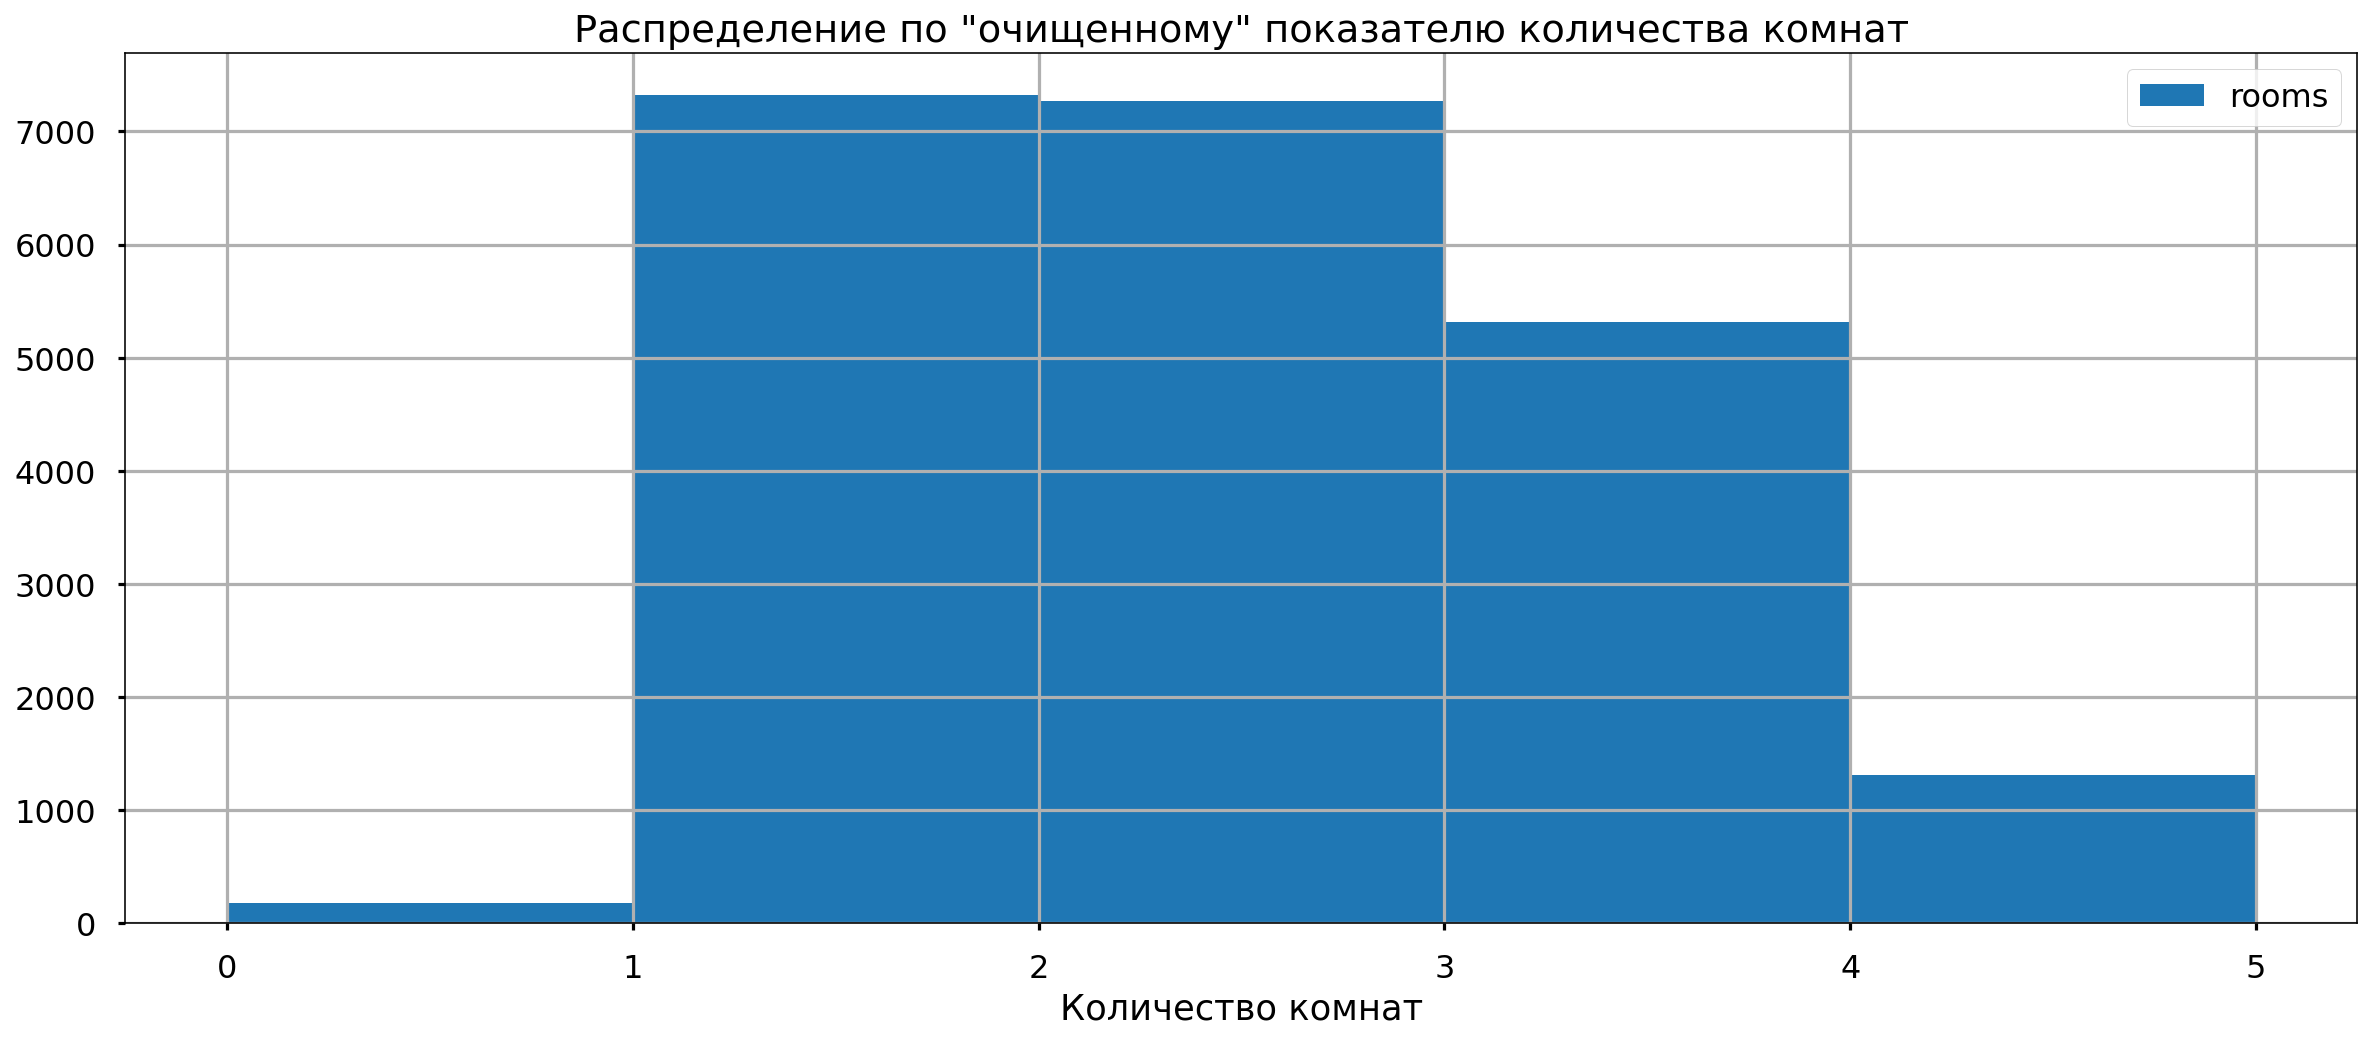

1    7323
2    7265
3    5318
4    1052
5     262
0     180
Name: rooms, dtype: int64


count    21400.000000
mean         2.024533
std          0.964681
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

In [48]:
# Удаляем из датафрейма нехарактерное количество комнат параметра 'rooms', 
data = filter_values(data, 'rooms', 6, -1)
# Проверяем, что аномалии удалены
build_hist(data.rooms, 'Количество комнат', 'Распределение по "очищенному" показателю количества комнат', bins=5)
print(data['rooms'].value_counts())
data['rooms'].describe()

Гистограмма отражает явное превосходство 1 и 2-ух комнатных квартир, общее число которых составляет ~68,45% от оставшихся объектов, а доля "трёшек" ~25,36%.
    
Далее исследую параметр высоты потолков объектов.

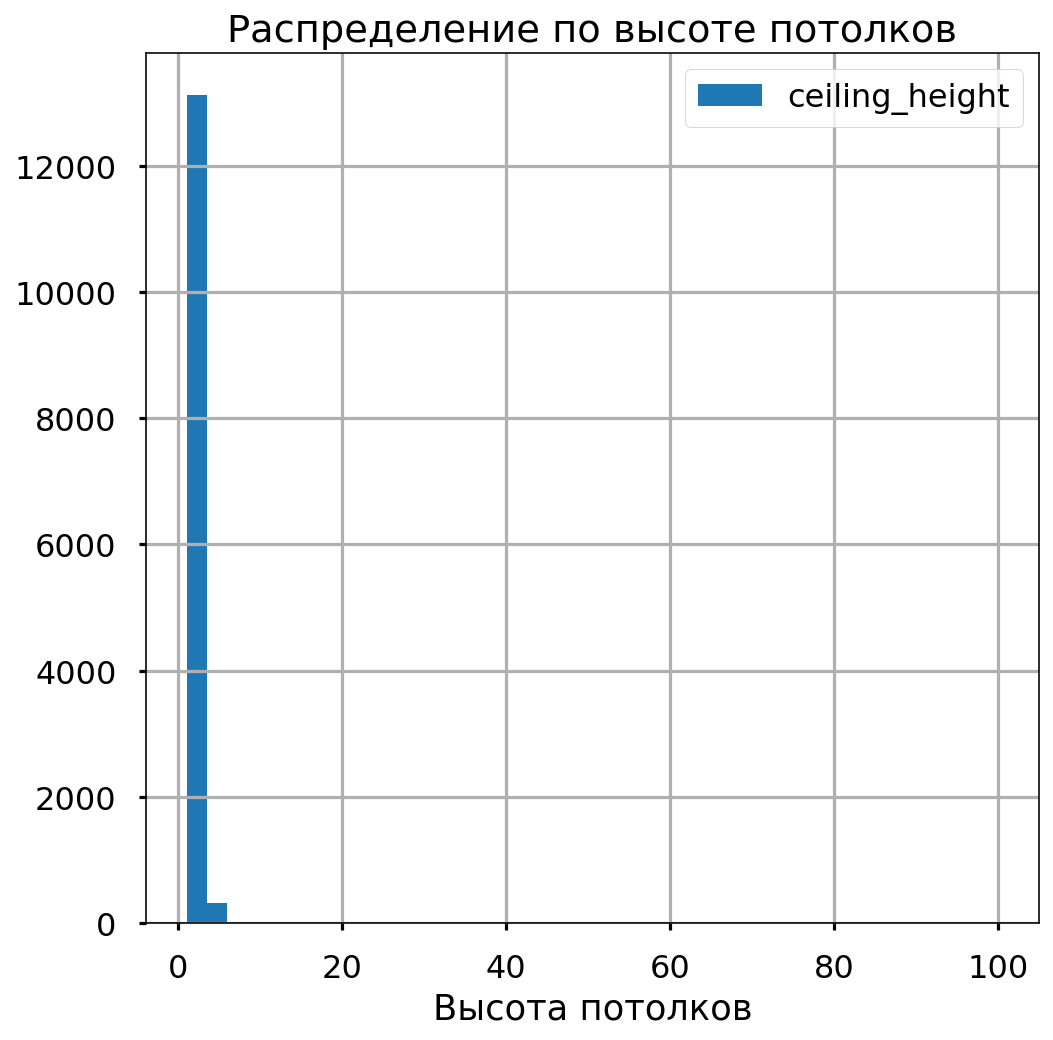

count    13468.000000
mean         2.764783
std          1.302999
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


7932

In [49]:
# Вывожу нюансы распределения 'ceiling_height', а также строю гистограмму по данным о количестве комнат
build_hist(data.ceiling_height, 'Высота потолков', 'Распределение по высоте потолков', figsize=(8, 8), bins=40)
print(data['ceiling_height'].describe())
data['ceiling_height'].isna().sum()

Максимальная высота потолков - 100, а минимальная - 1. И прежде чем заполнять пропуски в параметре высоты потолков следует исследовать объекты с аномально высокими  потолками.

In [50]:
# Вывожу объекты с вбросами по высоте потолка с сортировкой по возрастанию, для удобства анализа "переверну" таблицу
data[data['ceiling_height'] >= 4].sort_values(by='ceiling_height').T

11765                10228  \
total_images                              1                   14   
last_price                       12000000.0            6990000.0   
total_area                            147.9                 57.0   
first_day_exposition    2015-04-07 00:00:00  2017-09-13 00:00:00   
rooms                                     5                    2   
ceiling_height                          4.0                  4.0   
floors_total                            4.0                  4.0   
living_area                            89.6                 30.0   
floor                                     3                    1   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           17.2                 13.0   
balcony                                   0                    0   
locality_name                санктпетербург       санктпетербург   
airports_nearest                    20882.0              24899.0   
cityCenters_nearest                  1195.0               4785.0   
parks_around3000                        3.0                  0.0   
parks_nearest                         334.0                  NaN   
ponds_around3000                        3.0                  1.0   
ponds_nearest                         231.0                603.0   
days_exposition                         565                  240   
price_per_meter                     81135.9            122631.58   
day_of_week_exposition                    1                    2   
month_exposition                          4                    9   
year_exposition                        2015                 2017   
floor_type                           другой               первый   
cityCenters_nearest_km                  1.0                  5.0   

                                      4189                 5694   \
total_images                              7                   10   
last_price                        9200000.0            5500000.0   
total_area                             80.0                105.0   
first_day_exposition    2015-12-10 00:00:00  2017-10-25 00:00:00   
rooms                                     3                    2   
ceiling_height                          4.0                  4.0   
floors_total                            4.0                  9.0   
living_area                            52.3                 43.0   
floor                                     3                    1   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           10.4                 11.3   
balcony                                   0                    0   
locality_name                           NaN              гатчина   
airports_nearest                    21774.0                  NaN   
cityCenters_nearest                  3039.0                  NaN   
parks_around3000                        1.0                  NaN   
parks_nearest                         690.0                  NaN   
ponds_around3000                        1.0                  NaN   
ponds_nearest                         953.0                  NaN   
days_exposition                         223                    0   
price_per_meter                    115000.0             52380.95   
day_of_week_exposition                    3                    2   
month_exposition                         12                   10   
year_exposition                        2015                 2017   
floor_type                           другой               первый   
cityCenters_nearest_km                  3.0                  NaN   

                                      17979                10845  \
total_images            

>В датафрейме обнаружено 79 аномальных значения высоты потолков.

Предположительно значения типа 27 или 32 указаны с ошибками в целых и долях (скорее всего это 2,7 и 3,2 м). Для исправления таких ошибок воспользуюсь функцией `correct_ceiling_height`.

In [51]:
data['ceiling_height'] = data['ceiling_height'].apply(correct_ceiling_height)
print(data['ceiling_height'].describe())
data['ceiling_height'].isna().sum()

count    13468.000000
mean         2.719670
std          0.307623
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64


7932

> Теперь можно заполнить пропуски по высоте потолков медианными значениями во избежание сильного искажения результатов анализа.

In [52]:
# Заполняю пропуски медианным значением, чтобы минимально влиять на конечные результаты отбора 
data['ceiling_height'].fillna(2.65, inplace=True)
# После заполнения медианным значением, можно поискать аномалии
print(data['ceiling_height'].unique()) # Вывожу уникальные значения высоты потолков
search_anomalies(data, 'ceiling_height', 4, 2).T

[ 2.64  2.6   2.65  3.    2.8   2.5   2.7   2.75  3.1   2.76  3.5   2.9
  2.74  2.55  2.68  2.77  5.8   3.3   3.33  2.57  3.2   2.52  2.4   2.56
  2.71  2.54  2.51  2.58  3.18  2.67  2.73  2.72  2.53  3.4   2.85  2.83
  2.78  2.48  3.7   1.75  2.96  3.05  2.79  3.25  2.66  2.97  2.81 10.
  2.    3.32  4.    2.59  2.86 10.3   3.07  3.15  2.84  3.21  2.61  3.8
  3.08  3.42  2.88  3.95  3.6   3.12  3.88  4.06  3.31  2.82  2.95  8.3
  3.11  3.75  4.25  4.19  2.47  2.63  2.87  3.35  2.69  2.62  2.45  8.
  2.2   4.5   4.2   3.65  3.45  3.44  3.17  3.13  3.66  4.1   3.03  3.16
  3.26  3.47  3.04  3.54  3.27  3.78  3.23  2.92  3.67  3.06  3.34  3.02
  2.49  1.2  14.    3.55  3.63  2.3   4.7   3.38  1.    3.49  3.09  2.26
  2.46  4.37  3.98  3.83  3.22  4.8   3.84  2.91  2.93  3.53  3.14  3.01
  2.98  3.39  4.45  3.9   3.56  3.28  3.24  3.62  3.52  3.36  3.37  2.94
  4.3   4.15  3.46  3.48  5.5   4.4   3.68  2.25  2.89  3.85  3.59  3.57
  3.93  3.86  3.58]


22590                5712   \
total_images                             16                    5   
last_price                        6000000.0            1500000.0   
total_area                             55.0                 42.8   
first_day_exposition    2018-10-31 00:00:00  2017-08-14 00:00:00   
rooms                                     2                    2   
ceiling_height                          1.0                  1.2   
floors_total                           12.0                  2.0   
living_area                            32.4                 27.5   
floor                                     7                    1   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           10.0                  5.2   
balcony                                   0                    0   
locality_name                санктпетербург                  мга   
airports_nearest                    33053.0                  NaN   
cityCenters_nearest                 14217.0                  NaN   
parks_around3000                        2.0                  NaN   
parks_nearest                         293.0                  NaN   
ponds_around3000                        2.0                  NaN   
ponds_nearest                         289.0                  NaN   
days_exposition                          13                  248   
price_per_meter                   109090.91             35046.73   
day_of_week_exposition                    2                    0   
month_exposition                         10                    8   
year_exposition                        2018                 2017   
floor_type                           другой               первый   
cityCenters_nearest_km                 14.0                  NaN   

                                      16934                22960  \
total_images                              5                   17   
last_price                        4100000.0            2300000.0   
total_area                             40.0                 53.6   
first_day_exposition    2017-10-17 00:00:00  2018-10-18 00:00:00   
rooms                                     1                    2   
ceiling_height                         1.75                  2.0   
floors_total                           37.0                  2.0   
living_area                            17.4                 19.0   
floor                                     5                    1   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           8.34                 10.0   
balcony                                   0                    0   
locality_name                санктпетербург           всеволожск   
airports_nearest                    18732.0                  NaN   
cityCenters_nearest                 20444.0                  NaN   
parks_around3000                        0.0                  NaN   
parks_nearest                           NaN                  NaN   
ponds_around3000                        3.0                  NaN   
ponds_nearest                          80.0                  NaN   
days_exposition                          71                    0   
price_per_meter                    102500.0             42910.45   
day_of_week_exposition                    1                    3   
month_exposition                         10                   10   
year_exposition                        2017                 2018   
floor_type                           другой               первый   
cityCenters_nearest_km                 20.0                  NaN   

                                      16446                19098  \
total_images            

In [53]:
data = filter_values(data, 'ceiling_height', 4, 2)
search_anomalies(data, 'ceiling_height', 4, 2)

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_meter, day_of_week_exposition, month_exposition, year_exposition, floor_type, cityCenters_nearest_km]
Index: []

[0 rows x 28 columns]

> Аномалии по параметру высота потолков удалены, пропуски заполнены медианными значениями.   

При анализе влияния фактора на цену и скорость продажи, такие объекты следует исключать `высота потолка равна 2,65`

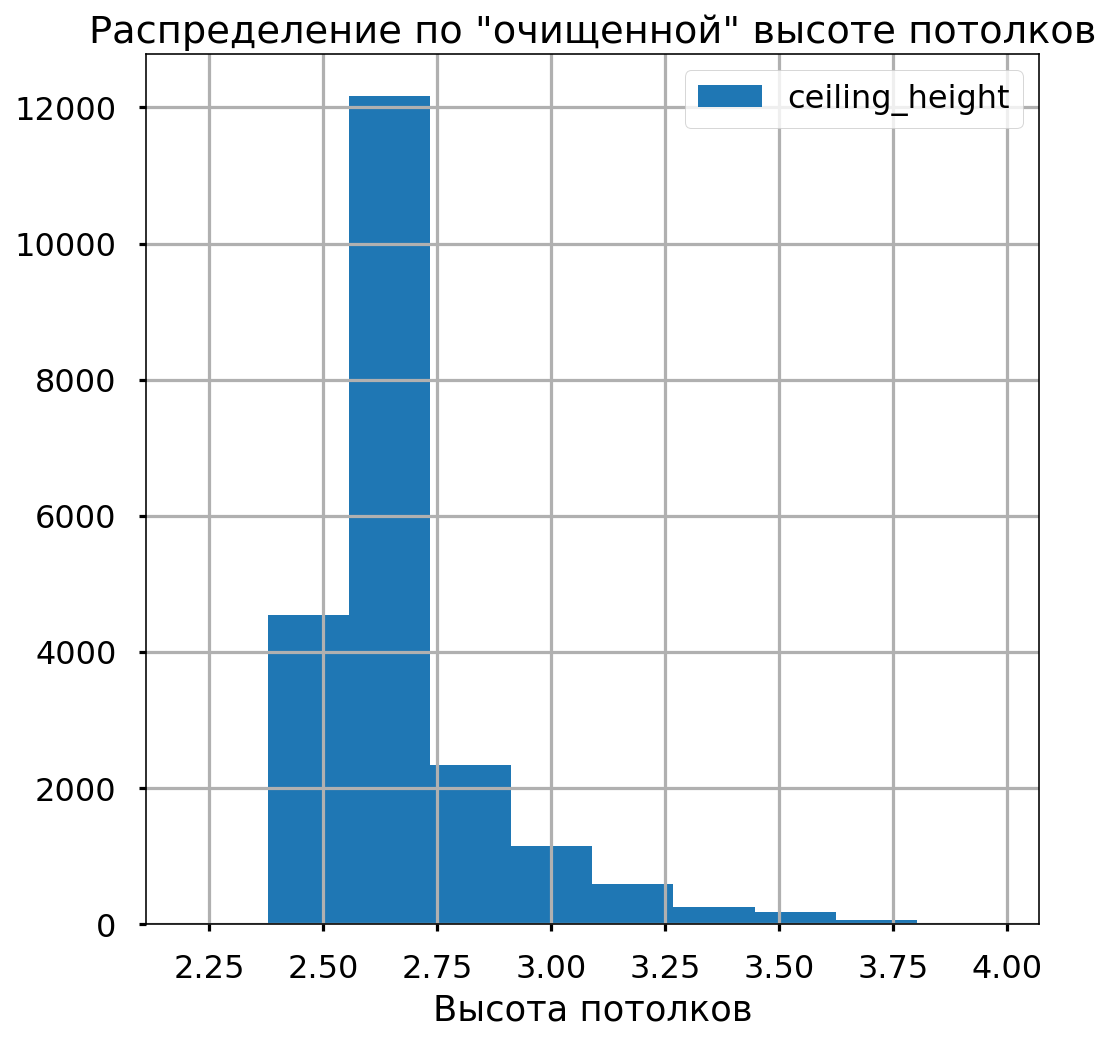

count    21322.000000
mean         2.688026
std          0.192946
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.980000
Name: ceiling_height, dtype: float64


0

In [54]:
build_hist(data.ceiling_height, 'Высота потолков', 'Распределение по "очищенной" высоте потолков', figsize=(8, 8), bins = 10)
print(data['ceiling_height'].describe())
data['ceiling_height'].isna().sum()

> После заполнения пропусков медианными значениями основные показатели распределения по высоте потолков  скорректировались.   
    
    
<span style='color:blue '> Важно обратить внимание на влияние параметра высоты потолков на скорость продажи и стоимость объекта.

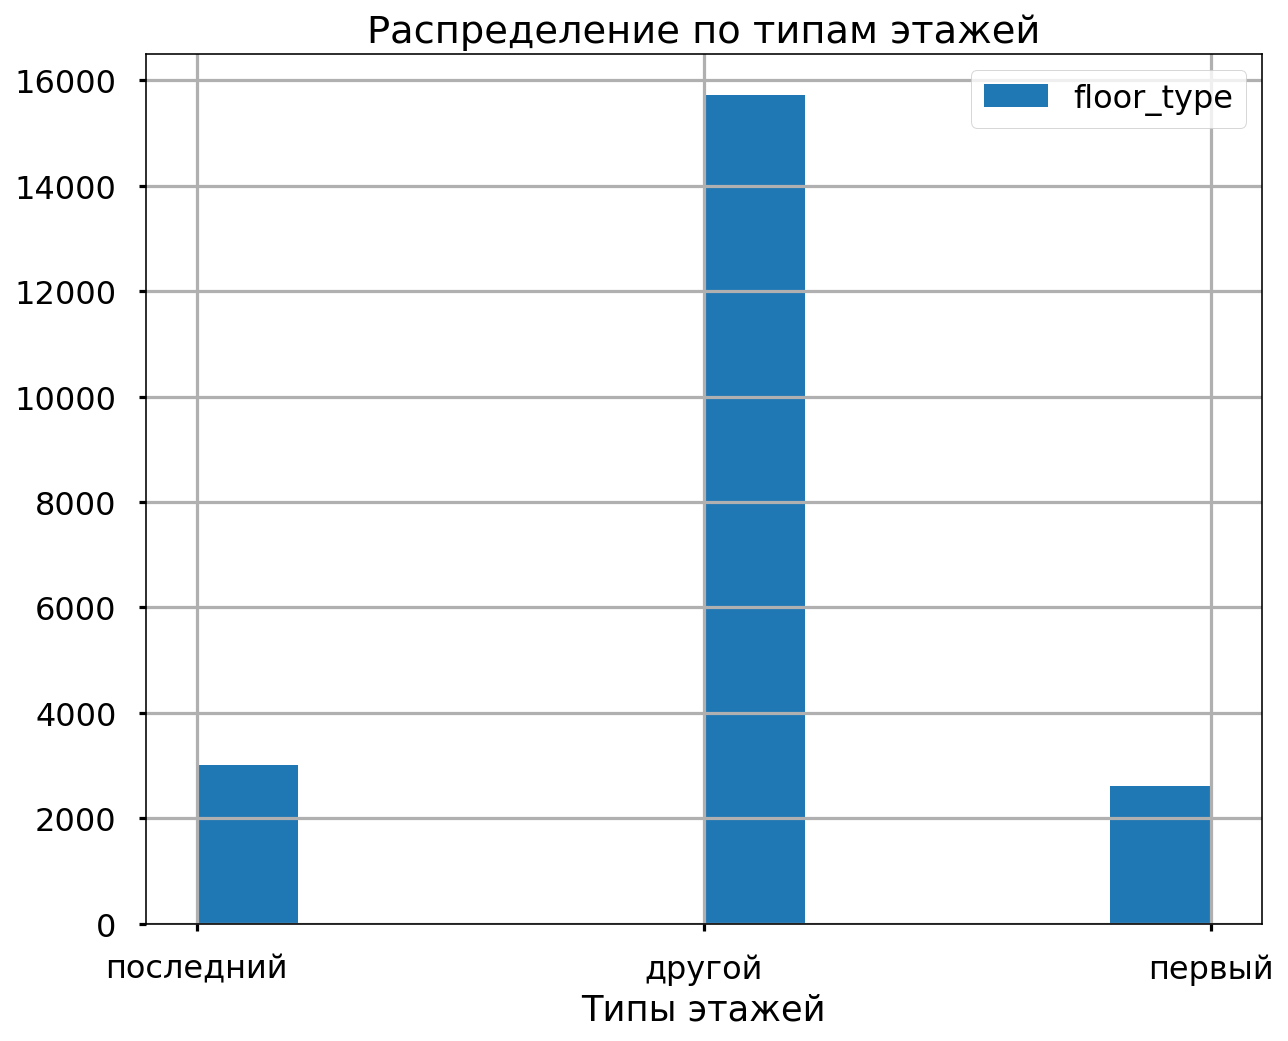

другой       15715
последний     3004
первый        2603
Name: floor_type, dtype: int64

In [55]:
# строю гистограмму по данным о типе этажа
data['floor_type'].hist(figsize=(10, 8), legend=True)
plt.xlabel('Типы этажей')
plt.title('Распределение по типам этажей')
plt.show()
data['floor_type'].value_counts()

График и вызов метода `value_counts()` отражают преобладание типа "другой".    
При этом доли последних и первых этажей составляют ~14% и ~12% соответственно.   
В дальнейшем можно отследить корреляцию типа этажа с ценой объекта и скоростью его продажи.

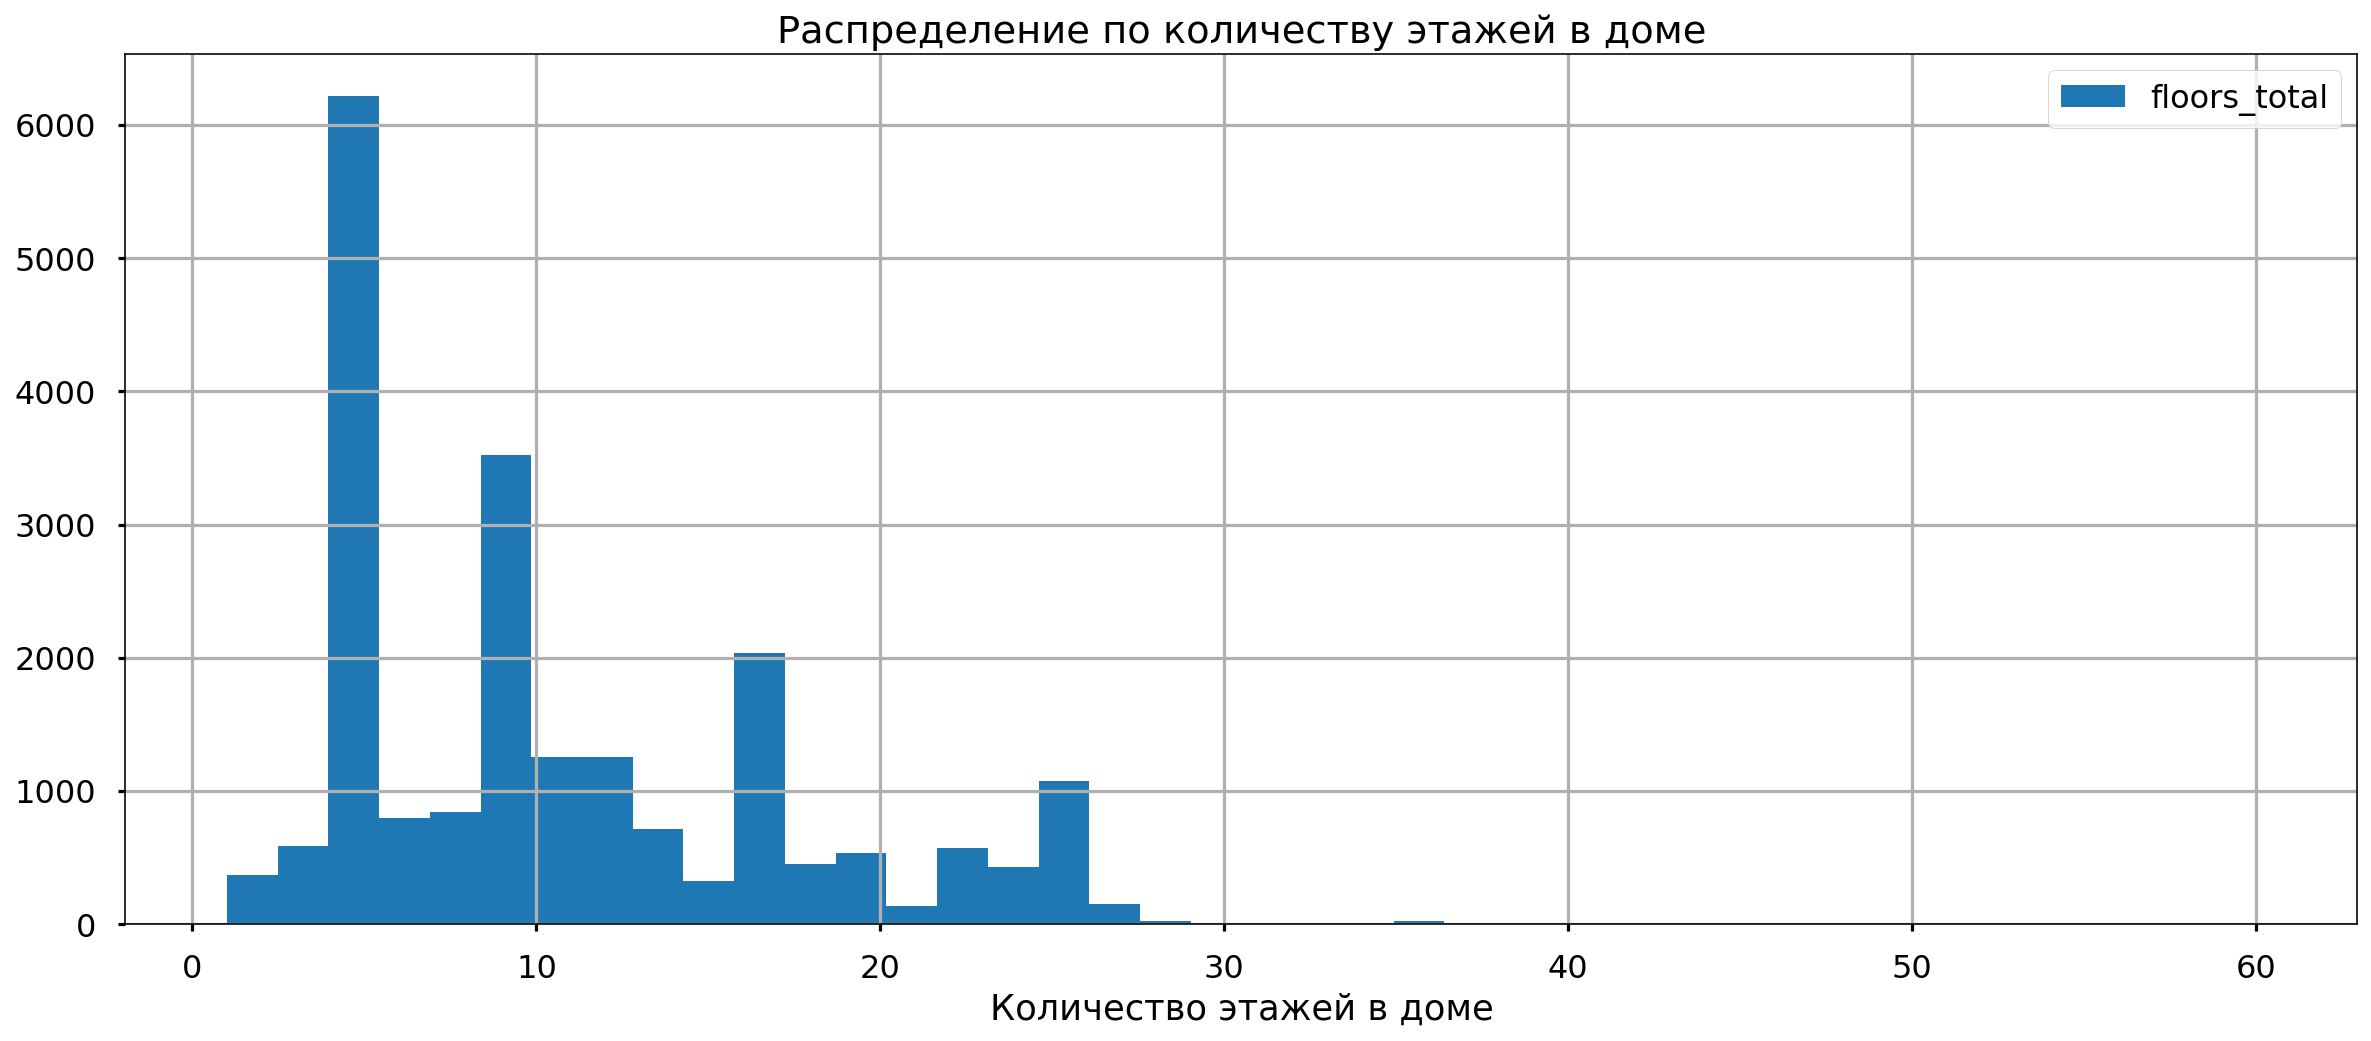

count    21322.000000
mean        10.714942
std          6.580459
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


0

In [56]:
# гистограмма по данным об общем количестве этажей в домах
build_hist(data.floors_total, 'Количество этажей в доме', 'Распределение по количеству этажей в доме')
print(data['floors_total'].describe())
data['floors_total'].isna().sum()

> Максимальная этажность объектов - 60, проверю сколько таких высоток.

In [57]:
# Ищу вбросы в количестве этажей домов, в которых находятся объекты
search_anomalies(data, 'floors_total', 28, -1).T

20876                806    \
total_images                             20                    3   
last_price                        8200000.0            7520000.0   
total_area                             80.7                 68.2   
first_day_exposition    2019-01-28 00:00:00  2017-12-13 00:00:00   
rooms                                     3                    2   
ceiling_height                          2.5                 2.65   
floors_total                           28.0                 28.0   
living_area                           39.85                 35.7   
floor                                    22                    5   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                          16.25                 10.7   
balcony                                   0                    0   
locality_name                     парголово       санктпетербург   
airports_nearest                    53426.0              48847.0   
cityCenters_nearest                 19603.0              16685.0   
parks_around3000                        0.0                  0.0   
parks_nearest                           NaN                  NaN   
ponds_around3000                        0.0                  0.0   
ponds_nearest                           NaN                  NaN   
days_exposition                           0                    0   
price_per_meter                    101610.9            110263.93   
day_of_week_exposition                    0                    2   
month_exposition                          1                   12   
year_exposition                        2019                 2017   
floor_type                           другой               другой   
cityCenters_nearest_km                 20.0                 17.0   

                                      14142                324    \
total_images                              8                    0   
last_price                        7400000.0            6090000.0   
total_area                             60.0                 62.0   
first_day_exposition    2017-11-10 00:00:00  2015-09-06 00:00:00   
rooms                                     2                    2   
ceiling_height                         2.65                 2.65   
floors_total                           28.0                 28.0   
living_area                            31.0                 30.0   
floor                                     4                   22   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                            9.0                 10.0   
balcony                                   1                    1   
locality_name                санктпетербург       санктпетербург   
airports_nearest                    19971.0              19971.0   
cityCenters_nearest                 21683.0              21683.0   
parks_around3000                        0.0                  0.0   
parks_nearest                           NaN                  NaN   
ponds_around3000                        1.0                  1.0   
ponds_nearest                         546.0                546.0   
days_exposition                          37                  323   
price_per_meter                   123333.33             98225.81   
day_of_week_exposition                    4                    6   
month_exposition                         11                    9   
year_exposition                        2017                 2015   
floor_type                           другой               другой   
cityCenters_nearest_km                 22.0                 22.0   

                                      23017                14868  \
total_images            

> Всего обнаружено 52 объекта в нехарактерно высоких домах.   
    Удаляю эти объекты из датафрейма, проверяю и строю гистограмму по оставшимся объектам.

In [58]:
data = filter_values(data, 'floors_total', 28, -1)
search_anomalies(data, 'floors_total', 28, -1)

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_meter, day_of_week_exposition, month_exposition, year_exposition, floor_type, cityCenters_nearest_km]
Index: []

[0 rows x 28 columns]

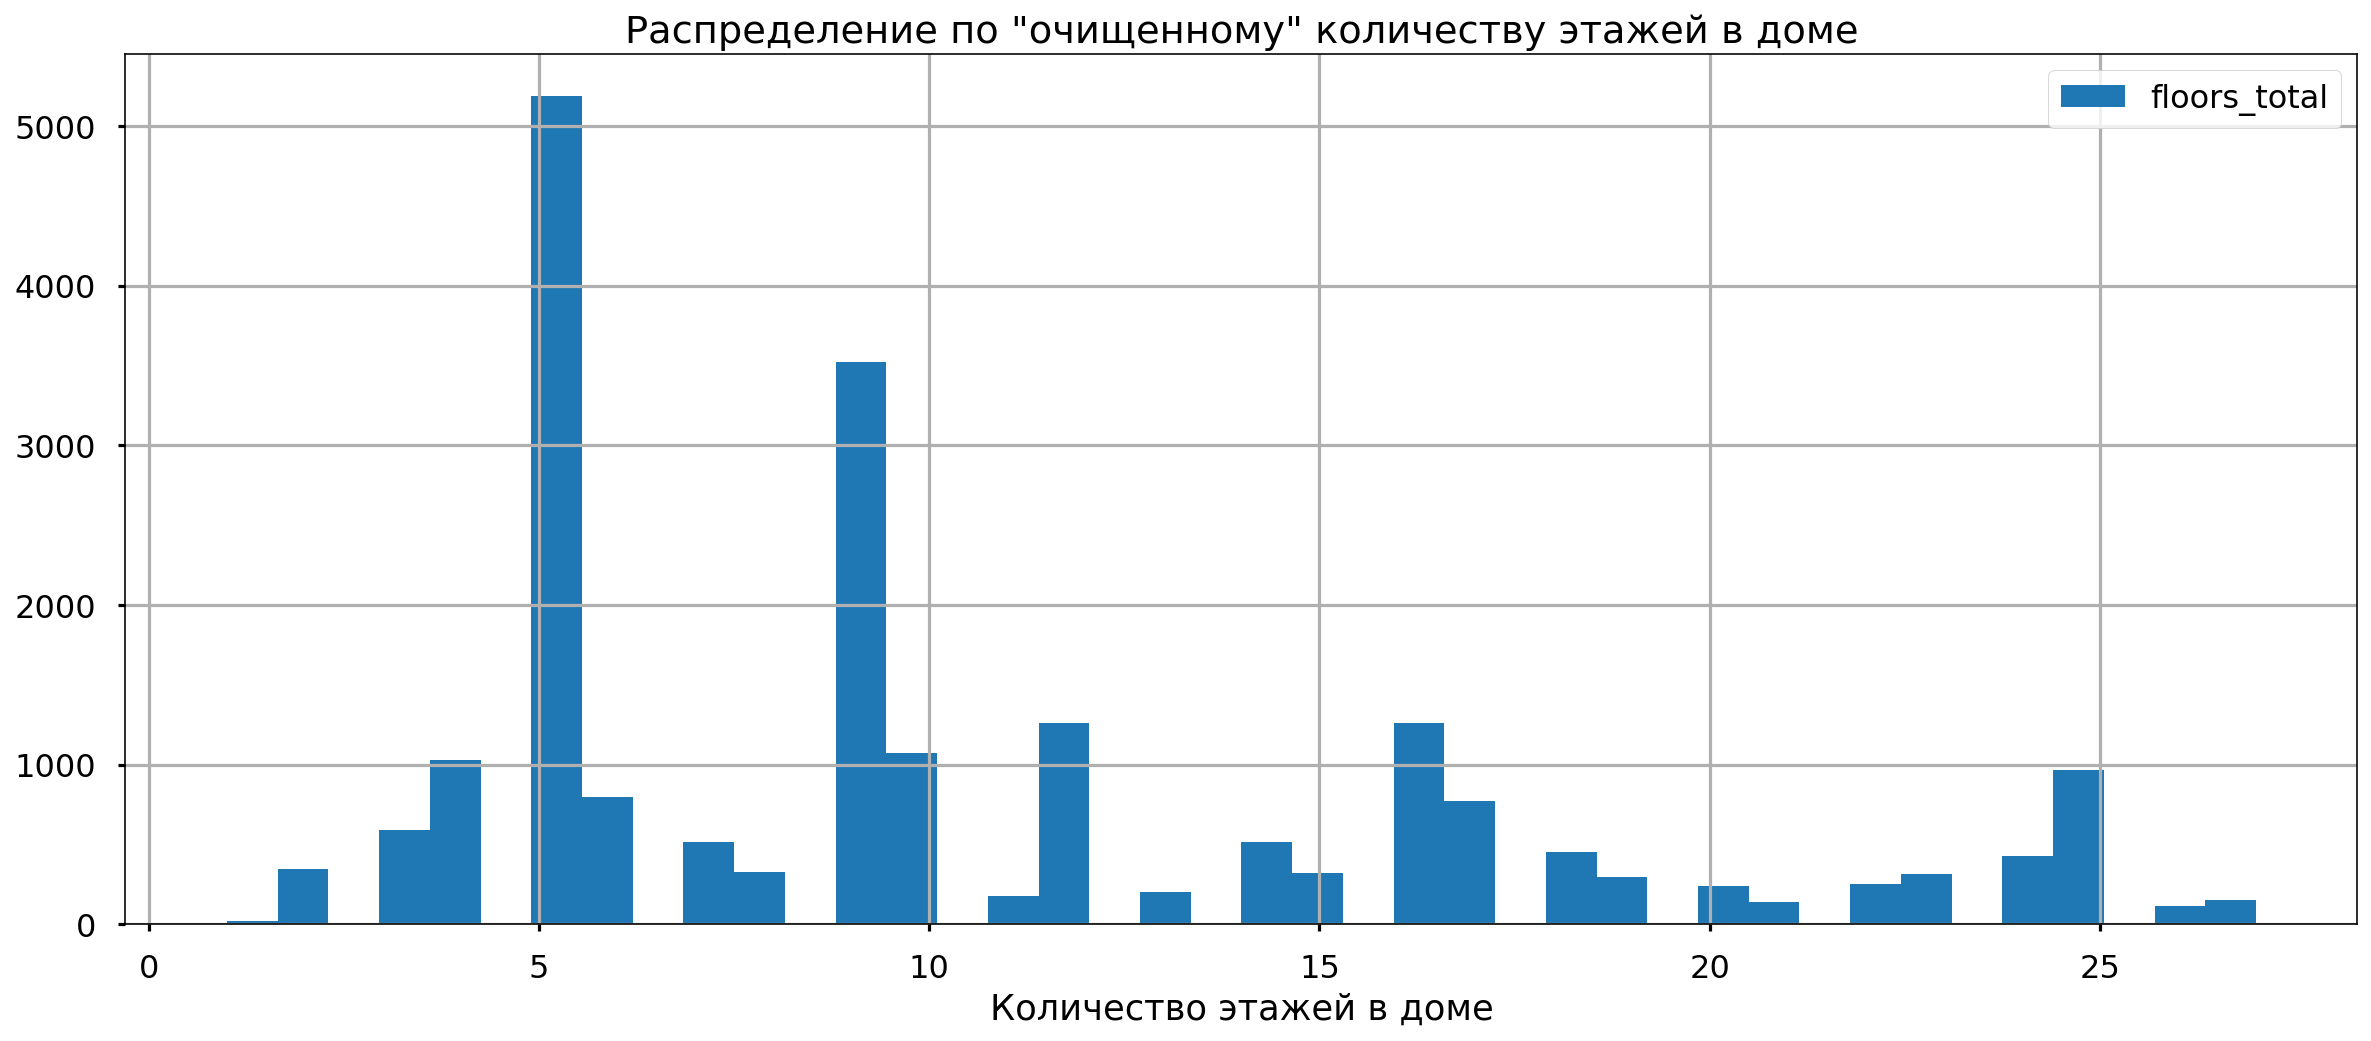

count    21271.000000
mean        10.661605
std          6.491201
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         27.000000
Name: floors_total, dtype: float64

In [59]:
# гистограмма по данным об общем количестве этажей в домах после удаления аномалий
build_hist(data.floors_total, 'Количество этажей в доме', 'Распределение по "очищенному" количеству этажей в доме')
data['floors_total'].describe()

> Больше всего объектов находятся на 5 и 9 этажах.   
    Также отмечу суммарно большое количествона на этажах выше 12, судя по гистограмме.  
Средняя этажность объектов при этом - 10.55, а медианное значение - 9. 
В дальнешем проанализирую корреляцию этого показателя с ценой и скоростью продажи.

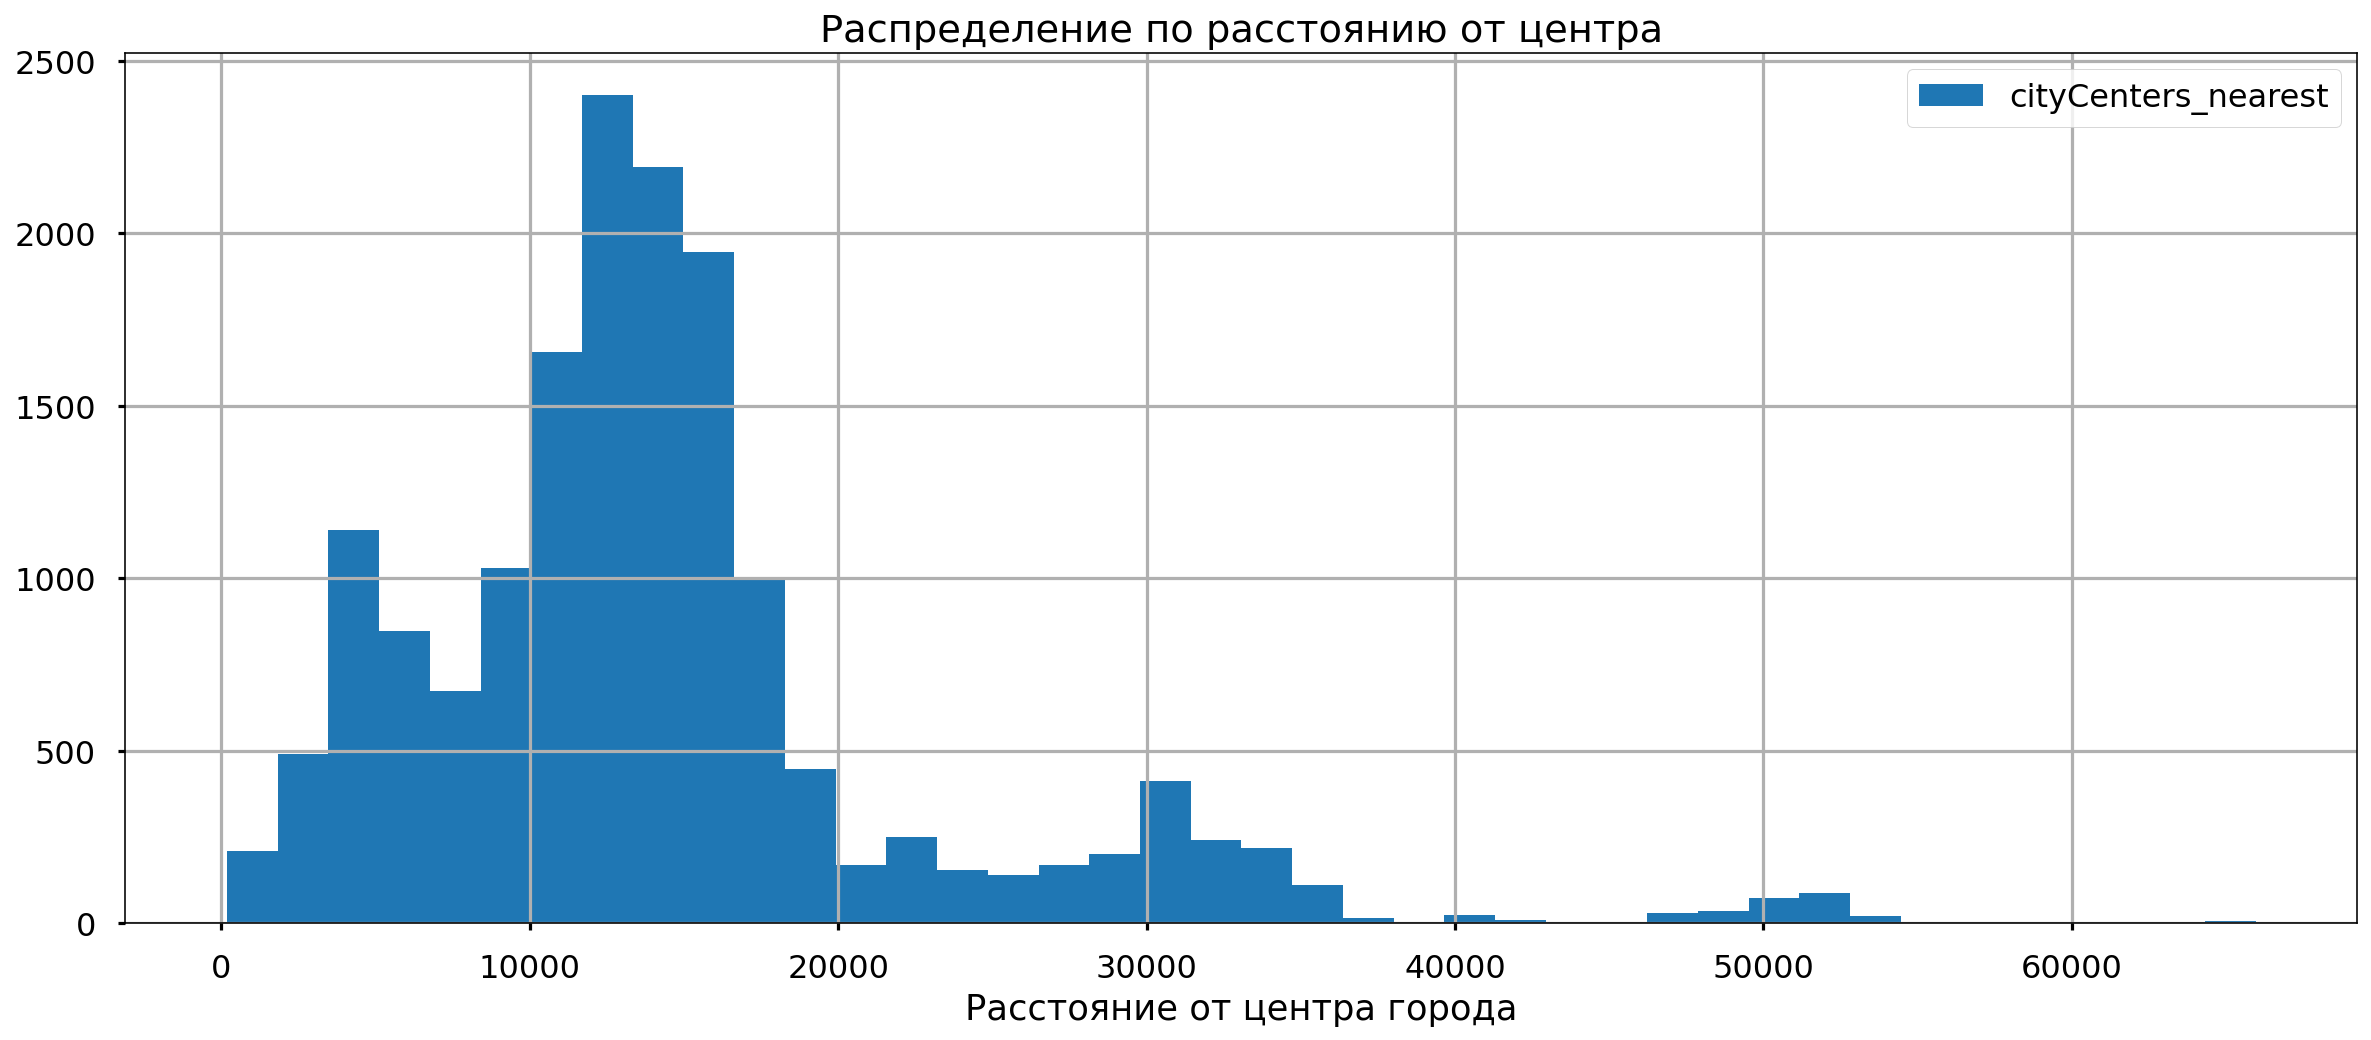

count    16414.000000
mean     14379.034056
std       8633.427388
min        181.000000
25%       9613.500000
50%      13188.000000
75%      16291.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


4857

In [60]:
# Вывожу нюансы распределения 'cityCenters_nearest', а также строю гистограмму по расстоянию до центра города
build_hist(data.cityCenters_nearest, 'Расстояние от центра города', 'Распределение по расстоянию от центра')
print(data['cityCenters_nearest'].describe())
data['cityCenters_nearest'].isna().sum()

In [61]:
# ищу аномалии в данных распределения по расстоянию от центра
search_anomalies(data, 'cityCenters_nearest', 55000, -1)

total_images  last_price  total_area first_day_exposition  rooms  \
939              17   3015000.0        31.2           2019-04-16      1   
11244             8   4250000.0        32.0           2018-02-04      1   
4441              6   2300000.0        31.0           2016-05-26      1   
23123             0   1800000.0        32.0           2018-07-17      1   
16569            13   3200000.0        52.8           2017-06-20      2   
2974             13   3200000.0        46.3           2018-03-31      2   
18884            15   3600000.0        57.6           2019-02-08      3   
5218             15   3650000.0        53.8           2018-09-24      3   
20746             1   3300000.0        43.5           2016-02-16      2   
577               7   4000000.0        59.0           2017-07-23      3   
5340             19   3600000.0        50.6           2019-03-19      2   
9640              8   4200000.0        51.4           2014-12-10      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
939              2.50           3.0         17.5      1         False  ...   
11244            2.65           2.0         20.0      2         False  ...   
4441             2.65           3.0         12.0      1         False  ...   
23123            2.65           2.0         17.0      1         False  ...   
16569            2.55           5.0         29.9      3         False  ...   
2974             2.50           3.0         29.2      2         False  ...   
18884            2.55           3.0         41.3      2         False  ...   
5218             2.50           4.0         36.9      3         False  ...   
20746            2.55           4.0         27.2      2         False  ...   
577              2.50           5.0         37.0      1         False  ...   
5340             2.50           5.0         29.9      4         False  ...   
9640             2.55           5.0         31.0      2         False  ...   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
939              NaN               1.0          347.0                0   
11244          148.0               1.0          671.0               24   
4441             NaN               0.0            NaN              232   
23123           17.0               0.0            NaN              147   
16569          223.0               0.0            NaN              240   
2974             NaN               0.0            NaN              205   
18884            NaN               0.0            NaN               13   
5218             NaN               0.0            NaN              121   
20746            NaN               0.0            NaN             1043   
577              NaN               0.0            NaN                0   
5340             NaN               0.0            NaN                0   
9640             NaN               0.0            NaN             1194   

      price_per_meter  day_of_week_exposition  month_exposition  \
939          96634.62                       1                 4   
11244       132812.50                       6                 2   
4441         74193.55                       3                 5   
23123        56250.00                       1                 7   
16569        60606.06                       1                 6   
2974         69114.47                       5                 3   
18884        62500.00                       4                 2   
5218         67843.87                       0                 9   
20746        75862.07                       1                 2   
577          67796.61                       6                 7   
5340         71146.25                       1                 3   
9640         81712.06                       2                12   

       year_exposition  floor_type  cityCenters_nearest_km  
939               2019      первый                    57.0  
11244             2018   последний                    59.0 

> Вызов метода `describe()` показывает минимальное значение 181 м., количество пропусков при этом 4871, их нужно заполнить нулями.   
<span style='color:blue '>При анализе влияния на цену и скорость продажи их можно исключить по уникальному значению `0` во избежание путаницы.

In [62]:
# заполняю пропуски и проверяю
data['cityCenters_nearest'].fillna(0, inplace=True)
print(data['cityCenters_nearest'].describe())
data['cityCenters_nearest'].isna().sum()

count    21271.000000
mean     11095.739034
std       9692.681286
min          0.000000
25%       2805.000000
50%      11490.000000
75%      15318.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


0

In [63]:
data = filter_values(data, 'cityCenters_nearest', 55000, -1)
search_anomalies(data, 'cityCenters_nearest', 55000, -1)

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_meter, day_of_week_exposition, month_exposition, year_exposition, floor_type, cityCenters_nearest_km]
Index: []

[0 rows x 28 columns]

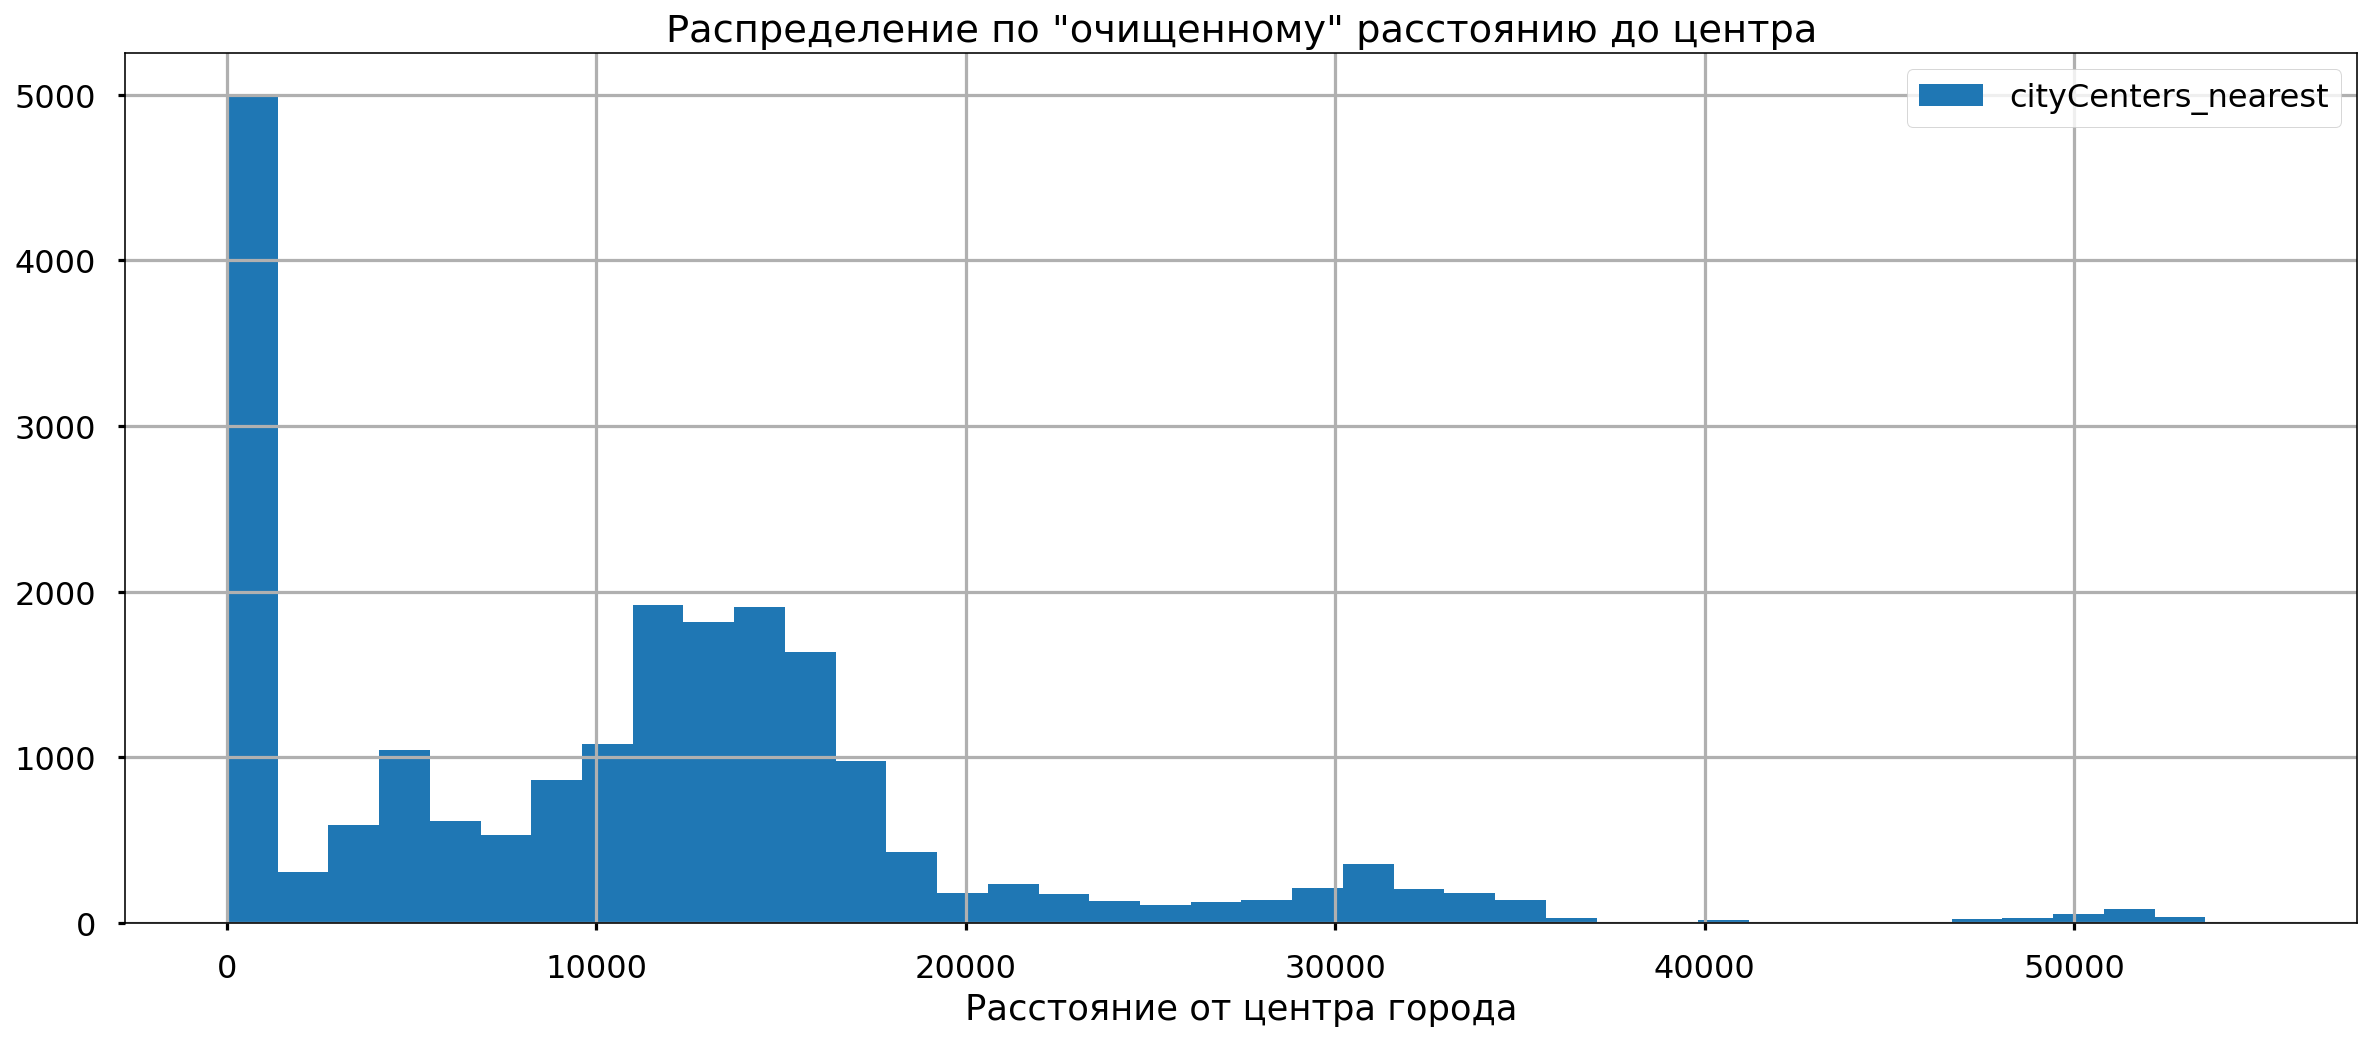

count    21259.000000
mean     11066.725528
std       9617.894496
min          0.000000
25%       2802.500000
50%      11487.000000
75%      15303.000000
max      54926.000000
Name: cityCenters_nearest, dtype: float64

In [64]:
# Вывожу нюансы распределения 'cityCenters_nearest', а также строю гистограмму по расстоянию до центра города
build_hist(data.cityCenters_nearest, 'Расстояние от центра города', 'Распределение по "очищенному" расстоянию до центра')
data['cityCenters_nearest'].describe()

> Примерная средняя удалённость большинства продаваемых объектов от центра около 11 км, однако не стоит забывать про нулевые значения, которые влияют на среднюю и медиану. 
    
Этот показатель с большой вероятностью влияет на цену объектов, поэтому нулевые значения отброшу при анализе влияния на цену и скорость продажи.

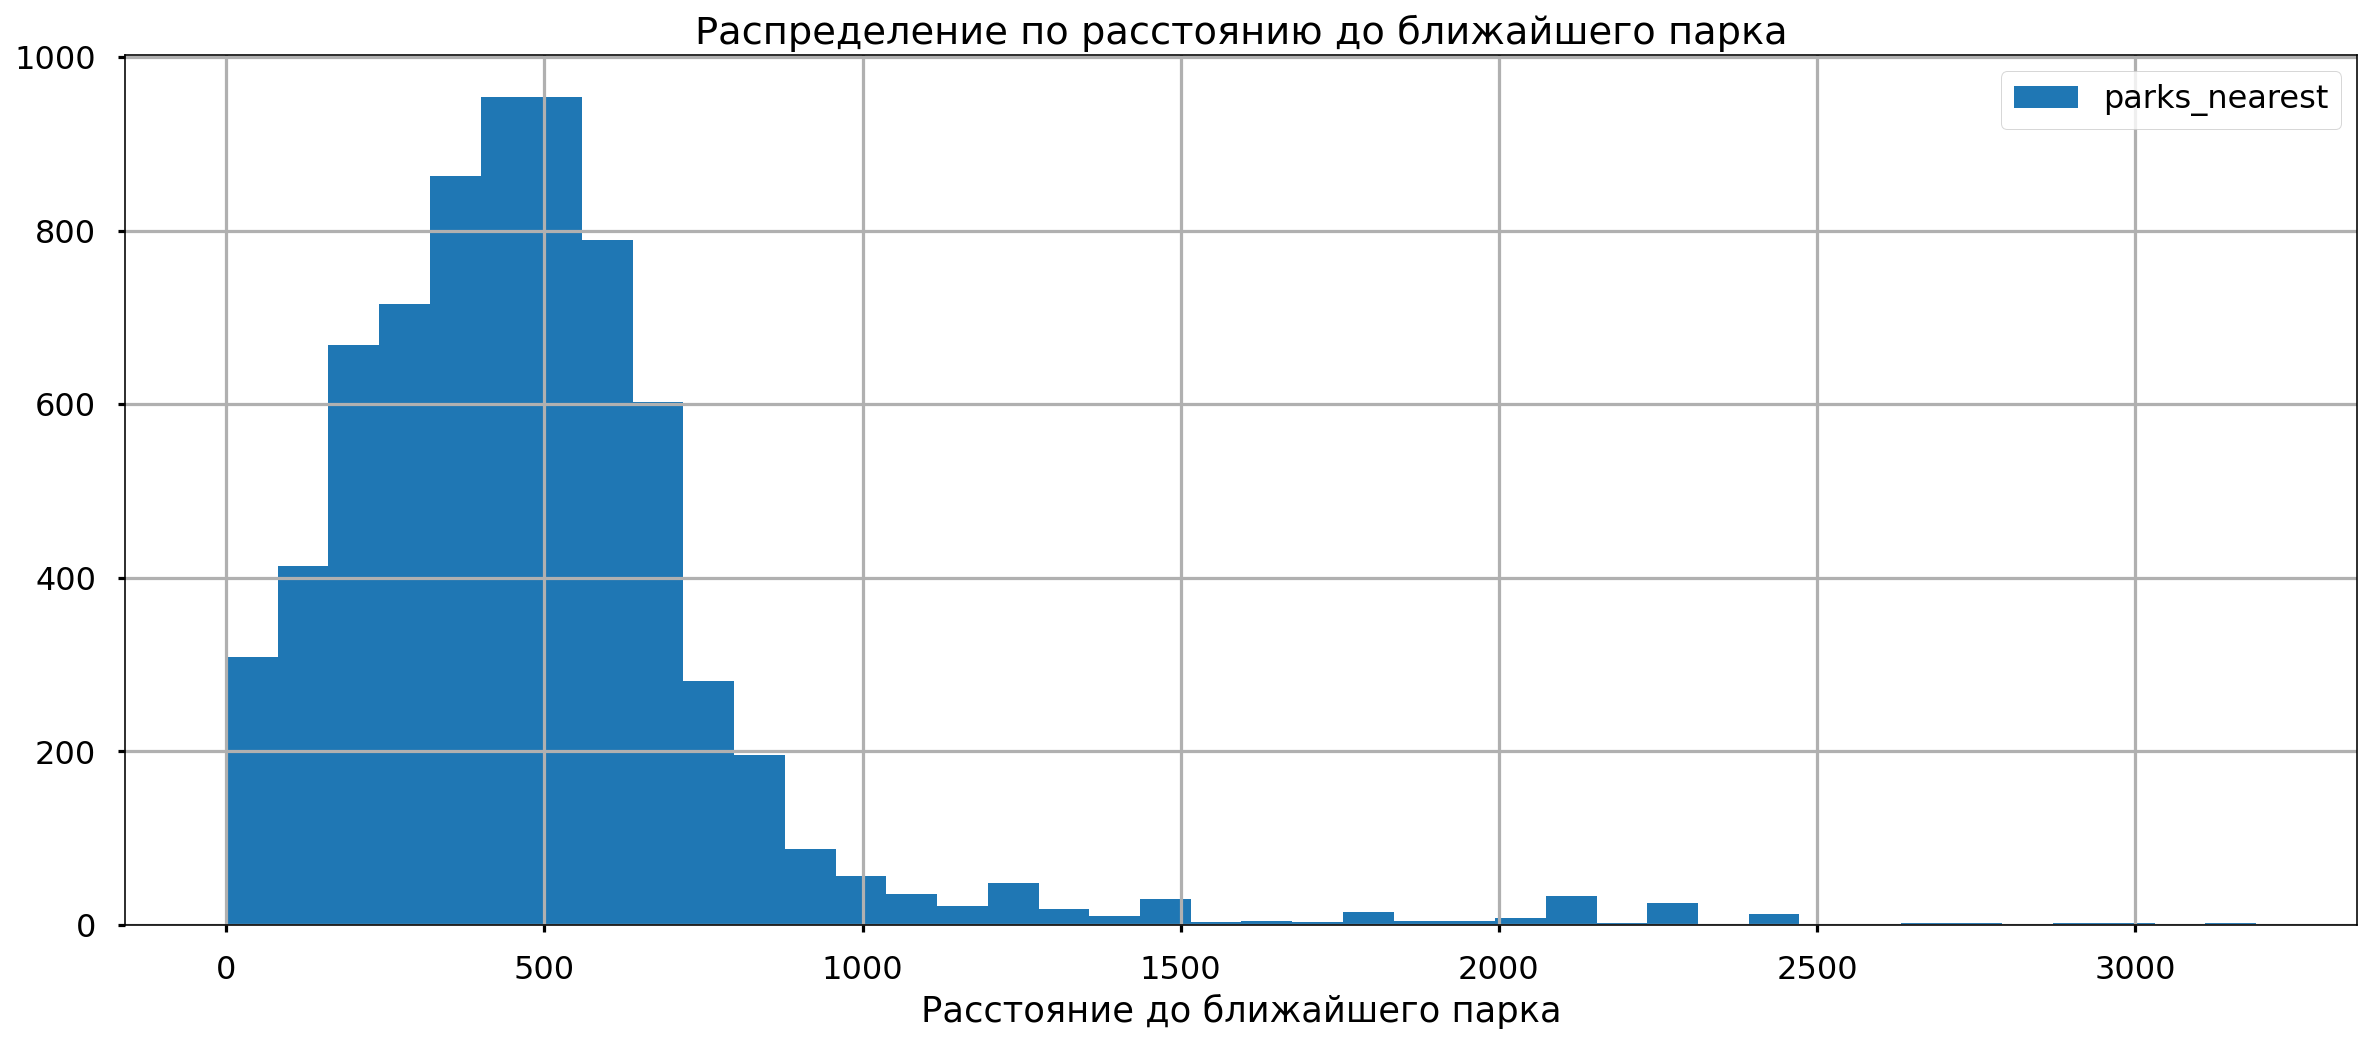

count    7194.000000
mean      490.258966
std       339.548021
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


14065

In [65]:
# Cрою гистограмму по расстоянию до центра города и вывожу нюансы распределения 'parks_nearest'
build_hist(data.parks_nearest, 'Расстояние до ближайшего парка', 'Распределение по расстоянию до ближайшего парка')
print(data['parks_nearest'].describe())
data['parks_nearest'].isna().sum()

>Гистограмма и последовательное применение методов `isna()` и `sum()` показывают, что параметр расстояния до ближайшего парка в бОльшей части объявлений не заполнен.   
    Возможно, парков нет вблизи, либо продавец не указал при заполнении вручную. Также отмечу, что минимальное значение `1` и для анализа я могу заполнить пропуски нулями и отфильтровать их по `нулю` при поиске корреляций.

In [66]:
data['parks_nearest'].fillna(0, inplace=True)
# После заполнения пропусков продолжу анализ параметра и поиск аномалий
data['parks_nearest'].isna().sum()

0

In [67]:
# ищу аномалии в данных распределения по расстоянию до ближайшего парка
search_anomalies(data, 'parks_nearest', 2500, -1)

total_images  last_price  total_area first_day_exposition  rooms  \
18685            11   6700000.0        65.6           2017-05-02      3   
18327            18   6100000.0        54.5           2018-06-24      2   
6625              7   5000000.0        36.6           2018-02-07      1   
1804             20  13800000.0       114.0           2018-10-29      3   
5923              6   6698000.0        60.0           2018-07-18      2   
7316              5   7100000.0        74.5           2016-04-19      3   
22003             9  14166000.0        78.7           2019-04-04      2   
3865             20  11900000.0        91.2           2018-10-04      3   
7855             16   5200000.0        44.9           2019-03-04      2   
1860             19   3500000.0        45.0           2016-12-05      2   
2659              9  19150000.0       104.9           2017-08-28      3   
23080            15   4650000.0        44.5           2018-02-20      2   
19208            17  14950000.0       187.0           2017-10-12      5   
1590              3   7500000.0        70.0           2017-07-11      2   
10959             9   3000000.0        31.1           2017-03-21      1   
19430             9   3900000.0        30.5           2018-02-22      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
18685            2.75           3.0         48.6      2         False  ...   
18327            2.65           3.0         32.6      3         False  ...   
6625             2.50          14.0         21.2      9         False  ...   
1804             3.40           5.0         51.0      2         False  ...   
5923             3.15           3.0         32.4      2         False  ...   
7316             3.00           4.0         49.0      3         False  ...   
22003            2.95           5.0         38.0      2         False  ...   
3865             3.10           4.0         62.0      3         False  ...   
7855             2.53           5.0         29.0      3         False  ...   
1860             2.65           5.0         29.1      3         False  ...   
2659             3.00           5.0         61.5      4         False  ...   
23080            2.65           5.0         25.2      2         False  ...   
19208            3.00           2.0         80.0      2         False  ...   
1590             2.65          18.0         37.0     13         False  ...   
10959            2.65           5.0         17.7      2         False  ...   
19430            2.60           5.0         16.5      1         False  ...   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
18685         2532.0               3.0          346.0              108   
18327         2555.0               3.0           73.0              108   
6625          2633.0               1.0          391.0              246   
1804          2665.0               3.0          282.0                0   
5923          2711.0               3.0          371.0               45   
7316          2747.0               3.0          420.0              119   
22003         2768.0               3.0          487.0                9   
3865          2847.0               3.0          370.0                0   
7855          2880.0               1.0          357.0                0   
1860          2888.0               1.0          409.0              473   
2659          2905.0               3.0          137.0               91   
23080         2984.0               1.0          284.0              152   
19208         3013.0               3.0          537.0               49   
1590          3064.0               1.0          264.0                4   
10959         3190.0               1.0          431.0              234   
19430         3190.0               1.0          431.0              176   

      price_per_meter  day_of_week_exposition  month_exposition  \
18685       102134.15                       1                 5   
18327      

В датафрейме всего 16 объектов с расстоянием до парка больше 2500 м. Удаление этих строк из датафрейма существенно не повлияет на исследование.

In [68]:
# исключаю аномалии по расстоянию до ближайшего парка и проверяю
data = filter_values(data, 'parks_nearest', 2500, -1)
search_anomalies(data, 'parks_nearest', 2500, -1)

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_meter, day_of_week_exposition, month_exposition, year_exposition, floor_type, cityCenters_nearest_km]
Index: []

[0 rows x 28 columns]

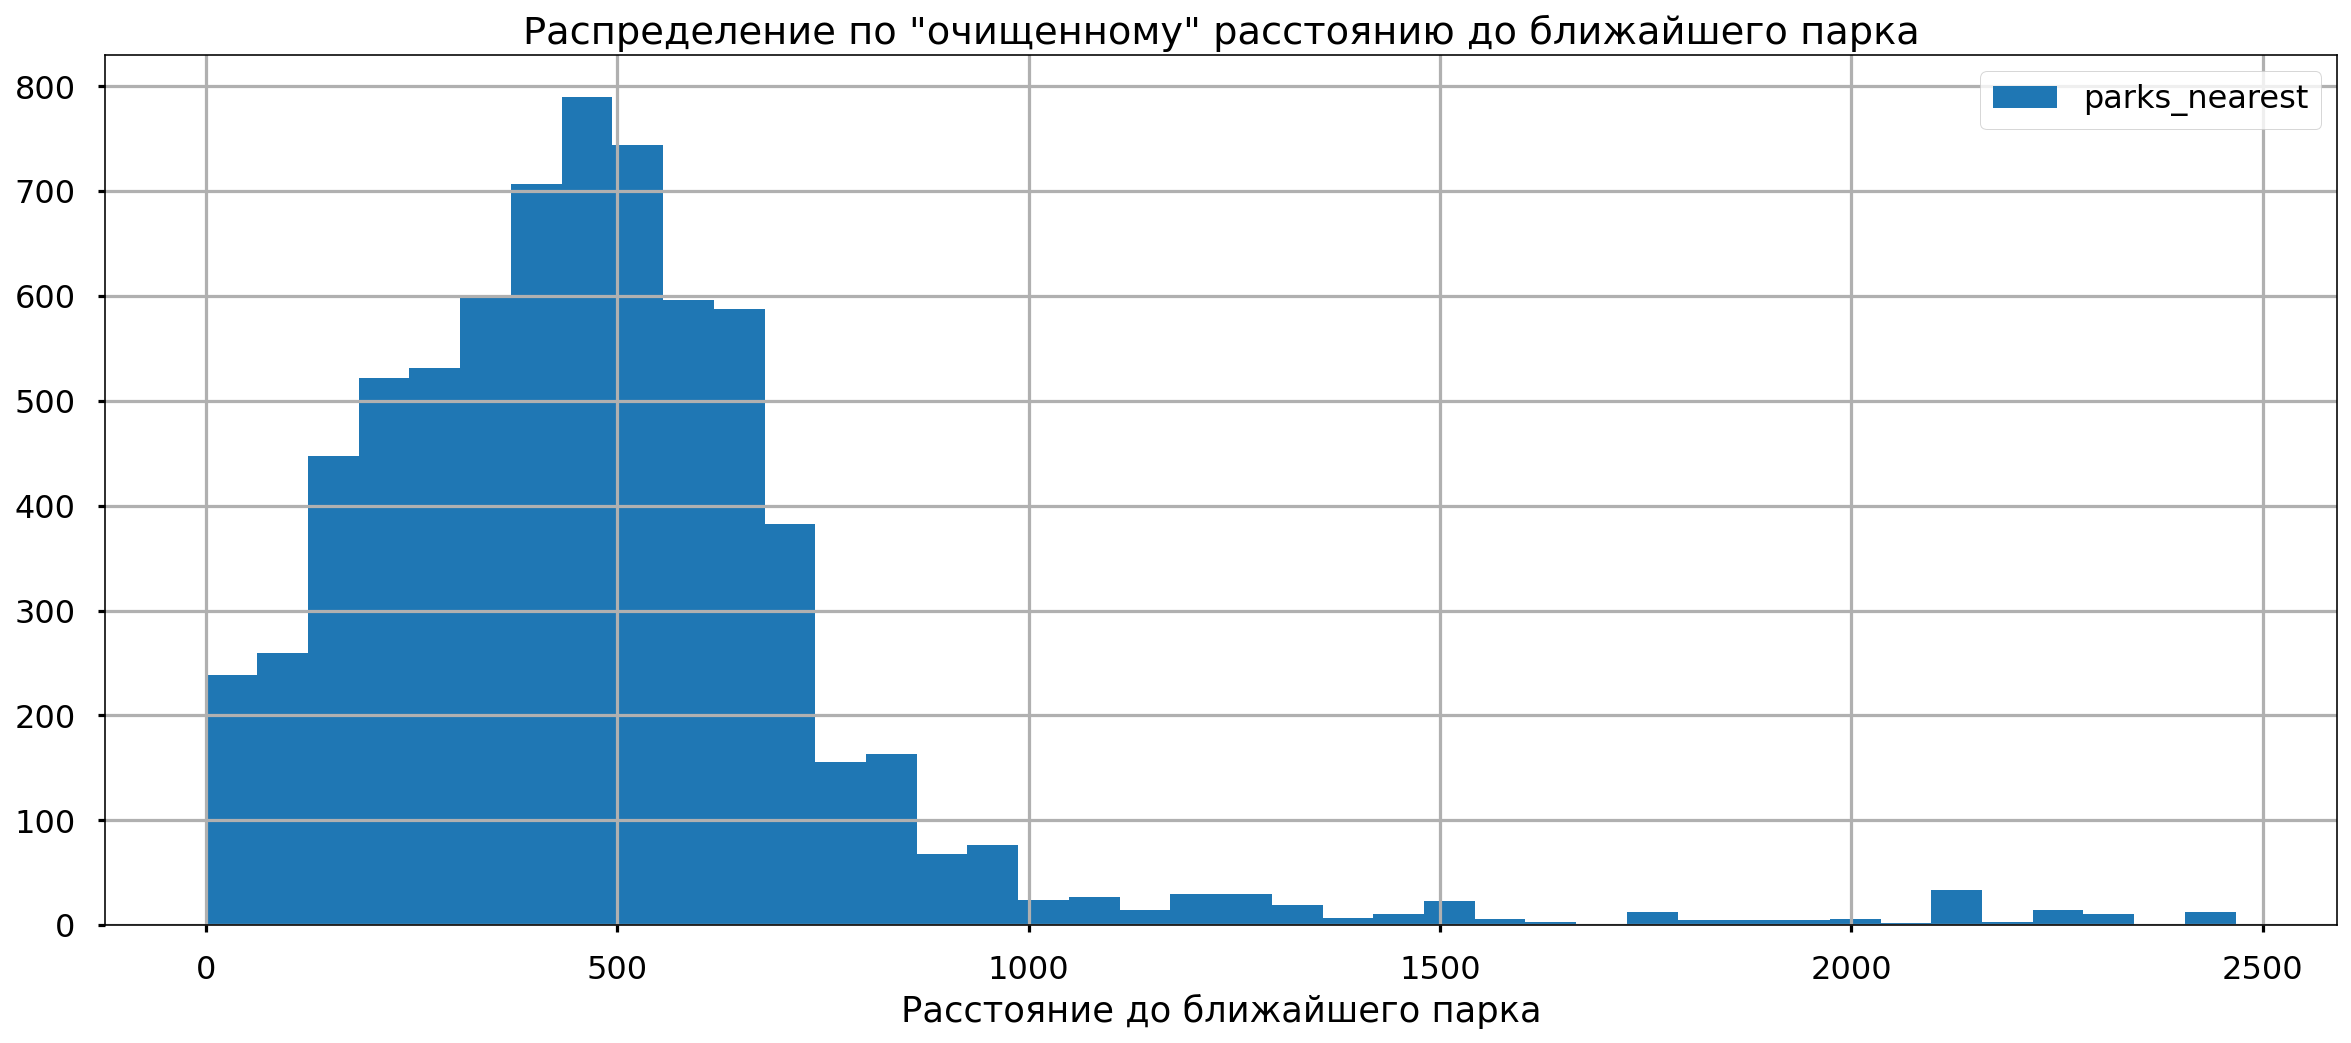

count    7178.000000
mean      485.002926
std       320.996323
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      2467.000000
Name: parks_nearest, dtype: float64

In [69]:
# Вывожу нюансы распределения 'parks_nearest', а также строю гистограмму по расстоянию до центра города
build_hist(data[data['parks_nearest'] != 0].parks_nearest, 'Расстояние до ближайшего парка', 'Распределение по "очищенному" расстоянию до ближайшего парка')
data.loc[data['parks_nearest'] != 0, 'parks_nearest'].describe()

У большей части объектов с заполненным параметром парк расположен в пределах 500 м, что может благоприятно влиять на скорость и цену продажи. Влияние параметра следует анализировать только в этой группе данных, исключая строки с незаполненным параметром.

***Вывод по исследованию основных параметров объектов.***  

***Изучая параметры датафрейма столкнулась с аномалиями, очевидными ошибками в данных.*** 

**Какие-то из параметров очистила от аномалий:**
- общая площадь 'total_area';
- жилая площадь 'living_area';
- площадь кухни 'kitchen_area';
- цена объекта 'last_price';
- количество комнат 'rooms';
- высота потолков 'ceiling_height'; 

**В некоторых остались пропуски:**
- высота потолков 'ceiling_height';
- общее количество этажей в доме 'floors_total';
- расстояние до ближайшего аэропорта 'airports_nearest';
- расстояние до центра города в метрах 'cityCenters_nearest';
- расстояние до ближайшего парка 'parks_nearest';
- расстояние до ближайшего пруда 'parks_nearest';
- расстояние до центра города в километрах 'cityCenters_nearest_km'.

Удалять аномалии из датафрейма важно во избежание искажения конечных результатов анализа и выводов. В датафрейме осталось 20 9050 строк. На основании этих очищенных данных буду проводить дальнейший анализ и формулировать выводы.  

**На следующем этапе изучаю влияние каждого из параметров на стоимость недвижимости и скорость продажи объекта.**

#### Исследование скорости продажи объектов.

Скорость продажи объектов отражает параметр 'days_exposition'.  
На первом этапе вывожу общую гистограмму по этому параметру.

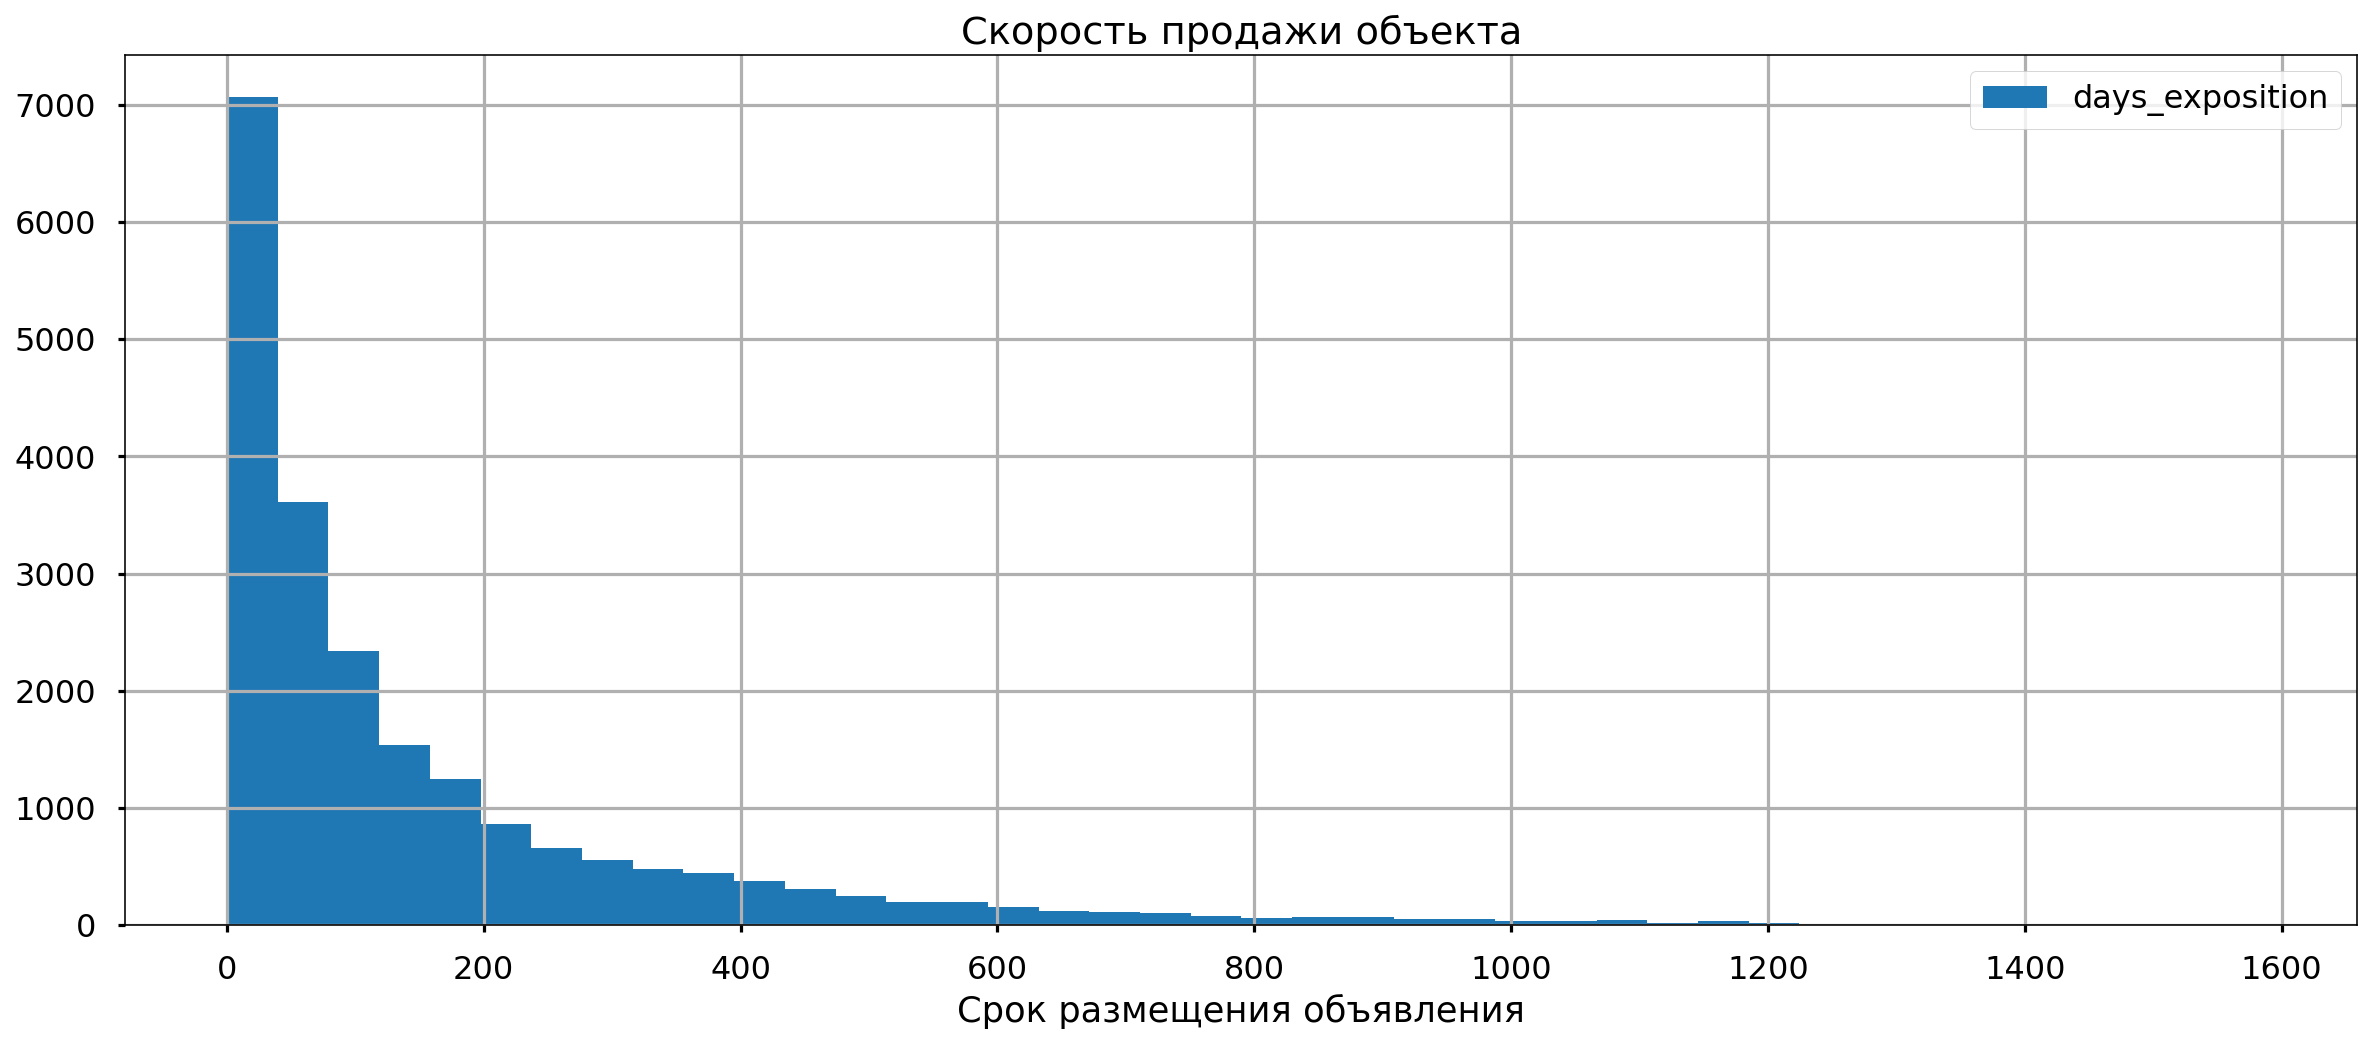

count    21243.000000
mean       158.705550
std        214.157675
min          0.000000
25%         22.000000
50%         77.000000
75%        203.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [70]:
# гистограмма распределения скорости продажи объекта `days_exposition`
build_hist(data.days_exposition, 'Срок размещения объявления', 'Скорость продажи объекта')
data['days_exposition'].describe()

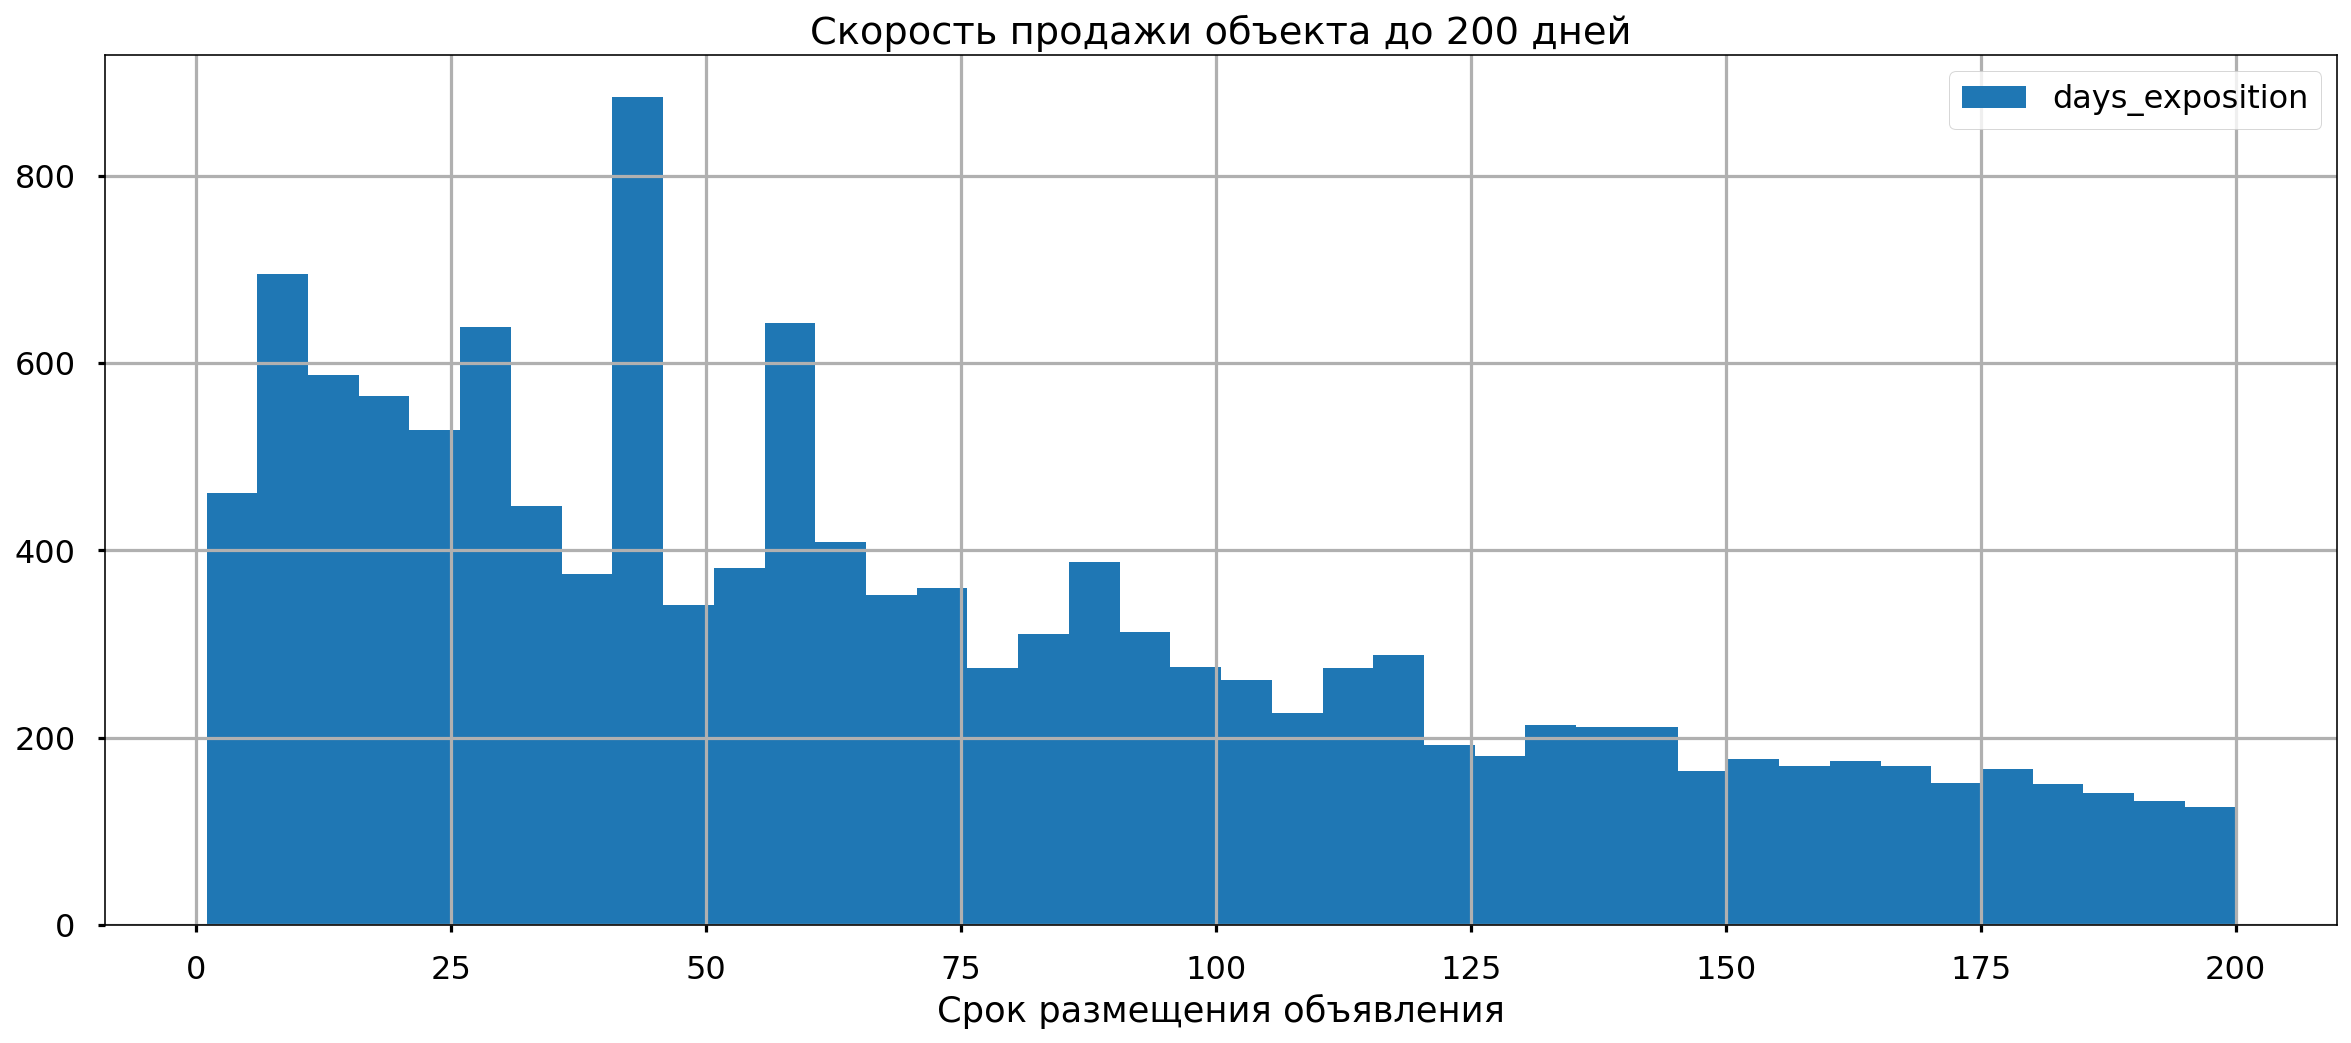

In [71]:
# Строю отдельную гистограмму по преобладающей скорости продаж (от 1 до 200 дней) - создаю переменную `sorted_days_exposition`, 
# а также строю тепловые графики корреляции - отдельно по зависимости от дня публикации и других параметров
sorted_days_exposition = data[
    (data['days_exposition'] > 0
    ) & (data['days_exposition'] <= 200)
].sort_values(by='days_exposition')


# Строю гистограмму по отсоритрованным срокам продаж    
build_hist(sorted_days_exposition.days_exposition, 'Срок размещения объявления', 'Скорость продажи объекта до 200 дней')

# Построю график зависимости скорости продажи от дня недели, месяца и года публикации
# Для определения факторов влияния на стоимость объекта построю тепловую диаграмму
corrMatrix = sorted_days_exposition.select_dtypes(
    include=np.number
).iloc[:, 16:21].corr()
    
    
# Выбираю стиль "тепловая карта"
corrMatrix.style.background_gradient(
    cmap='coolwarm')

In [72]:
sorted_days_exposition['days_exposition'].describe()

count    13015.000000
mean        73.657472
std         53.238210
min          1.000000
25%         29.000000
50%         60.000000
75%        111.000000
max        200.000000
Name: days_exposition, dtype: float64

Гистограмма показывает, что чаще всего недвижимость продается чуть больше чем за месяц, средний срок продажи объектов до 200 дней - 73 дня, медианный — 60 дней.   
    График корреляции показывает обратную зависимость скорости продажи от года (это очевидно, что чем больше год, тем дольше квартира продается, туда попадают все долгие продажи) и незначительную зависимость от дня недели публикации.   
    Отмечу, что низкая зависимость от времени публикации и параметра цены за квадратный метр
    

<span style='color:blue '>График корреляции показывает обратную зависимость скорости продажи от года (это очевидно, что чем больше год, тем дольше квартира продается, туда попадают все долгие продажи) и незначительную зависимость от дня недели публикации. Интереснее посмотреть зависимость скорости продажи от месяца публикации объявления.

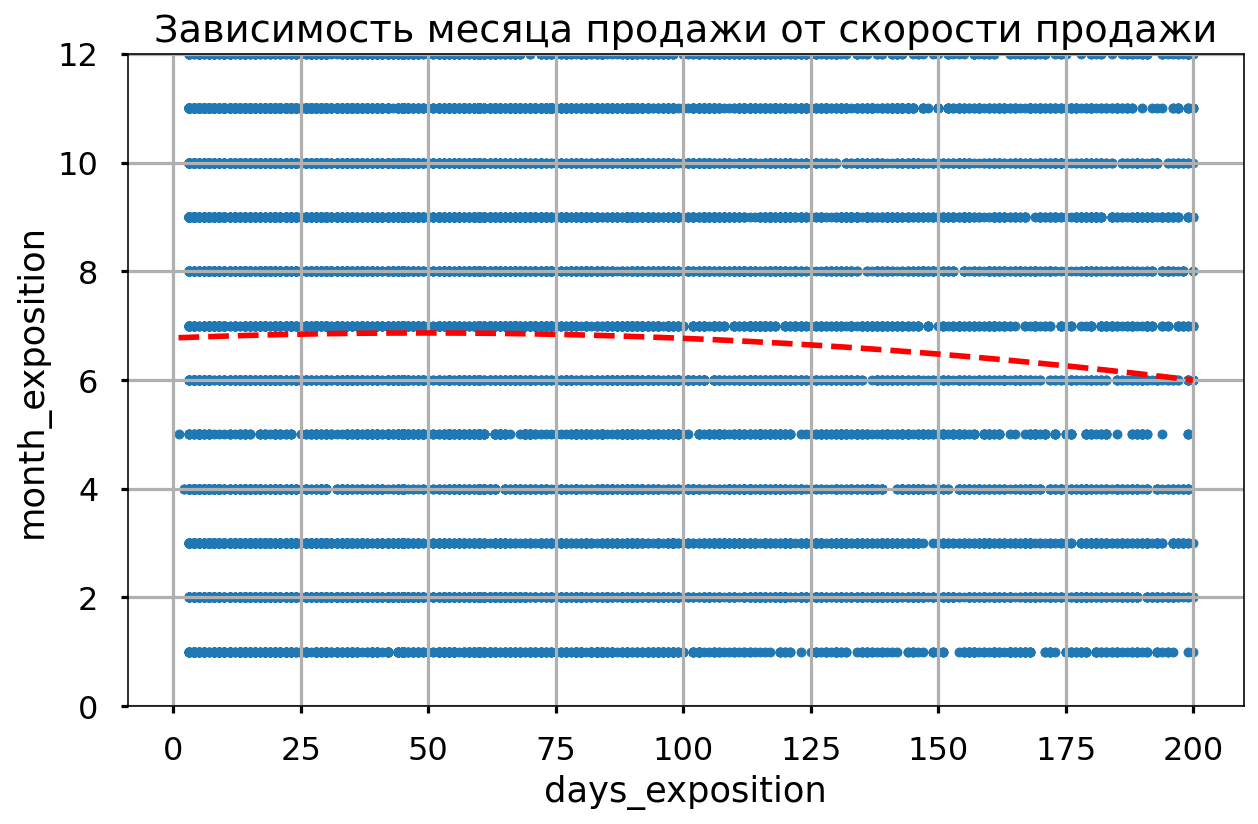

In [73]:
sorted_days_exposition.plot(
    x='days_exposition', y='month_exposition', kind='scatter', 
    title='Зависимость месяца продажи от скорости продажи', ylim=(0, 12), grid=True, figsize=(10, 6))

z = np.polyfit(sorted_days_exposition[
    'days_exposition'
], sorted_days_exposition[
    'month_exposition'], 2)


p = np.poly1d(z)
plt.plot(
    sorted_days_exposition[
        'days_exposition'], p(
        sorted_days_exposition[
            'days_exposition']),"r--")
plt.show()

> График не отражает никаких всплесков в зависимости от месяца, теперь можно посмотреть как влияют другие параметры объекта на скорость продажи.

In [74]:
# Построю график зависимости скорости продажи от других параметров объекта
# Для определения факторов влияния на стоимость объекта построю тепловую диаграмму
corrMatrix = sorted_days_exposition.select_dtypes(
    include=np.number
).iloc[
    :, 0:28
].corr()
# Выбираю стиль "тепловая карта"
corrMatrix.style.background_gradient(
    cmap='coolwarm')

Средний срок продажи объектов составляет около 160 дней, при этом медианное значение в данном случае является наиболее информативным показателем из-за очевидного влияния максимального показателя - 1580 дней. Это скорее аномалии.   
Воспользуюсь функцией поиска аномалий и проверю сколько таких объявлений.

In [75]:
# Ищу аномальные значения скорости продажи объектов
# "Переверну" датафрейм для удобства
data[
    (
        (data['days_exposition'] < 3) & (data['days_exposition'] != 0) # удаляю нули, потому что ранее заполнила ими пропуски
    ) 
                                   |(
                                       data['days_exposition'] > 1300)
].sort_values(by='days_exposition').T

1632                 13061  \
total_images                             19                   20   
last_price                        4000000.0            6100000.0   
total_area                             49.9                 51.4   
first_day_exposition    2019-05-01 00:00:00  2019-04-29 00:00:00   
rooms                                     2                    2   
ceiling_height                          2.5                  3.0   
floors_total                            9.0                  5.0   
living_area                            25.0                 31.7   
floor                                     1                    4   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           10.0                  6.9   
balcony                                   0                    1   
locality_name                санктпетербург       санктпетербург   
airports_nearest                    13567.0              10776.0   
cityCenters_nearest                 14384.0               9389.0   
parks_around3000                        1.0                  0.0   
parks_nearest                          20.0                  0.0   
ponds_around3000                        1.0                  0.0   
ponds_nearest                         681.0                  NaN   
days_exposition                           1                    2   
price_per_meter                    80160.32            118677.04   
day_of_week_exposition                    2                    0   
month_exposition                          5                    4   
year_exposition                        2019                 2019   
floor_type                           первый               другой   
cityCenters_nearest_km                 14.0                  9.0   

                                      16053                4789   \
total_images                              4                   15   
last_price                        4070000.0            4850000.0   
total_area                             45.1                 93.0   
first_day_exposition    2019-04-30 00:00:00  2015-03-04 00:00:00   
rooms                                     2                    3   
ceiling_height                         2.65                 2.65   
floors_total                            5.0                  6.0   
living_area                            22.7                 51.0   
floor                                     3                    5   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                            6.6                 15.3   
balcony                                   0                    0   
locality_name                санктпетербург             тельмана   
airports_nearest                    40859.0                  NaN   
cityCenters_nearest                 11668.0                  0.0   
parks_around3000                        2.0                  NaN   
parks_nearest                         485.0                  0.0   
ponds_around3000                        0.0                  NaN   
ponds_nearest                           NaN                  NaN   
days_exposition                           2                 1305   
price_per_meter                     90243.9             52150.54   
day_of_week_exposition                    1                    2   
month_exposition                          4                    3   
year_exposition                        2019                 2015   
floor_type                           другой               другой   
cityCenters_nearest_km                 12.0                  NaN   

                                      19284                4240   \
total_images            

Предполагая, что показатели продажи в Санкт-Петербурге могут отличаться от пригорода, выделю в отдельную переменную 10 населённых пунктов с наибольшим количеством объявлений.

Всего у 49 объявлений аномально быстрые и долгие продажи. Причем быстрые продажи можно исключить сразу – их всего 3. 
Долгие продажи сгруппируем по локациям и проверим на наличие общих признаков.

In [76]:
# Удаляю аномально быстро снятые объявления из среза
data = data[(
    data['days_exposition'] > 2
) | (
    data['days_exposition'] == 0
)]

# Вывожу основные численные показатели параметра
print(data['days_exposition'].describe())

# Проверяю пропуски
print(data['days_exposition'].isna().sum())

# Создаю переменную с аномально долгими продажами для дальнейшего анализа возможных причин
data_more_days_exposition = data[
    data[
        'days_exposition'
    ] > 1300
]

# проверяю датафрейм на наличие аномалий (кроме 0)
data[
    (
        (data['days_exposition'] < 3
        ) & (
            data['days_exposition'] != 0) # удаляю нули, потому что ранее заполнила ими пропуски
    ) 
                                   |(
                                       data['days_exposition'] > 1300)
].sort_values(by='days_exposition').T

count    21240.000000
mean       158.727731
std        214.164666
min          0.000000
25%         22.000000
50%         77.000000
75%        203.000000
max       1580.000000
Name: days_exposition, dtype: float64
0


4789                 19284  \
total_images                             15                    3   
last_price                        4850000.0            3490000.0   
total_area                             93.0                 43.0   
first_day_exposition    2015-03-04 00:00:00  2015-05-22 00:00:00   
rooms                                     3                    2   
ceiling_height                         2.65                  2.5   
floors_total                            6.0                  5.0   
living_area                            51.0                 28.0   
floor                                     5                    2   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                           15.3                  5.0   
balcony                                   0                    1   
locality_name                      тельмана            кронштадт   
airports_nearest                        NaN              69259.0   
cityCenters_nearest                     0.0              50985.0   
parks_around3000                        NaN                  3.0   
parks_nearest                           0.0                283.0   
ponds_around3000                        NaN                  3.0   
ponds_nearest                           NaN                160.0   
days_exposition                        1305                 1309   
price_per_meter                    52150.54             81162.79   
day_of_week_exposition                    2                    4   
month_exposition                          3                    5   
year_exposition                        2015                 2015   
floor_type                           другой               другой   
cityCenters_nearest_km                  NaN                 51.0   

                                      4240                 13599  \
total_images                             10                    2   
last_price                        5950000.0            3715100.0   
total_area                             64.9                 38.3   
first_day_exposition    2015-05-16 00:00:00  2015-09-20 00:00:00   
rooms                                     3                    1   
ceiling_height                          2.5                  2.6   
floors_total                            9.0                 15.0   
living_area                            45.3                15.65   
floor                                     8                    2   
is_apartment                          False                False   
studio                                False                False   
open_plan                             False                False   
kitchen_area                            6.3                12.37   
balcony                                   0                    0   
locality_name                санктпетербург              кудрово   
airports_nearest                    30108.0                  NaN   
cityCenters_nearest                  7480.0                  0.0   
parks_around3000                        0.0                  NaN   
parks_nearest                           0.0                  0.0   
ponds_around3000                        1.0                  NaN   
ponds_nearest                         399.0                  NaN   
days_exposition                        1312                 1313   
price_per_meter                    91679.51              97000.0   
day_of_week_exposition                    5                    6   
month_exposition                          5                    9   
year_exposition                        2015                 2015   
floor_type                           другой               другой   
cityCenters_nearest_km                  7.0                  NaN   

                                      7930                 4889   \
total_images            

In [77]:
# воспользуемся функцией для формирования сводной таблицы
display_pivot_table(data_more_days_exposition, "days_exposition" ,"locality_name", "rooms", "ceiling_height") 

all_numbers  sum_values  average_value
locality_name   rooms ceiling_height                                        
всеволожск      2     2.50                      1        1413    1413.000000
кронштадт       2     2.50                      1        1309    1309.000000
кудрово         1     2.60                      1        1313    1313.000000
лисий нос       1     3.00                      1        1375    1375.000000
лодейное поле   2     2.65                      1        1396    1396.000000
новое девяткино 2     2.50                      1        1580    1580.000000
павловск        3     3.00                      1        1485    1485.000000
парголово       1     2.85                      1        1452    1452.000000
пушкин          1     2.65                      1        1512    1512.000000
                2     2.75                      1        1361    1361.000000
                3     2.65                      1        1441    1441.000000
санктпетербург  1     2.55                      1        1362    1362.000000
                      2.60                      1        1336    1336.000000
                      2.65                      1        1314    1314.000000
                      2.80                      1        1346    1346.000000
                2     2.65                      7        9963    1423.285714
                      2.70                      1        1325    1325.000000
                      2.73                      1        1406    1406.000000
                      2.75                      1        1355    1355.000000
                      3.00                      3        4204    1401.333333
                      3.17                      1        1434    1434.000000
                      3.20                      1        1322    1322.000000
                3     2.50                      1        1312    1312.000000
                      2.70                      1        1332    1332.000000
                      2.77                      1        1341    1341.000000
                      2.85                      1        1553    1553.000000
                      3.00                      1        1349    1349.000000
                      3.10                      2        2751    1375.500000
                      3.40                      1        1363    1363.000000
                4     2.63                      1        1477    1477.000000
                      3.00                      2        3009    1504.500000
                      3.10                      1        1430    1430.000000
                5     3.00                      1        1318    1318.000000
                      3.40                      1        1395    1395.000000
тельмана        3     2.65                      1        1305    1305.000000
шлиссельбург    3     2.65                      1        1314    1314.000000

Предполагая, что на "долгую" продажу могли влиять локация, комнатность или высота потолков я построила сводную таблицу. Однако, убедившись в отстуствии значимых совпадений у выбранных объектов, удаляю их из датафрейма.  

Теперь построю сводную по количеству комнат всего датафрейма, предварительно удалив из него слишком долгие продажи.

In [78]:
# удаляю из датафрейма слишком долгие продажи
data = data[
    data[
        'days_exposition'
    ] <= 1300
]
print(
    data[
        'days_exposition'
    ].describe(
    )
)


# Применяю функцию display_pivot_table ко всему датафрейму с группировкой по комнатности
display_pivot_table(data, "days_exposition", "rooms")

count    21194.000000
mean       156.040578
std        206.443501
min          0.000000
25%         22.000000
50%         77.000000
75%        201.000000
max       1299.000000
Name: days_exposition, dtype: float64


all_numbers  sum_values  average_value
rooms                                        
0              178       18879     106.061798
1             7275     1053491     144.809759
2             7182     1079719     150.336814
3             5259      892407     169.691386
4             1044      206851     198.133142
5              256       55777     217.878906

Исходя из среднего показателя, дольше всего объявления о продаже были опубликованы у 5-ти и 4-ёх комнатных квартир — 218 и 197 соответственно.   

Проанализируем предполагаемую скорость продажи этих групп в зависимости от локации – сначала только по Санкт-Петербургу, а затем по остальным населенным пунктам.

all_numbers  sum_values  average_value
rooms                                        
0               99       10521     106.272727
1             4458      631040     141.552266
2             4677      685157     146.494975
3             3750      643755     171.668000
4              854      172024     201.433255
5              229       51768     226.061135

all_numbers  sum_values  average_value
rooms                                        
0               79        8358     105.797468
1             2817      422451     149.964856
2             2505      394562     157.509780
3             1509      248652     164.779324
4              190       34827     183.300000
5               27        4009     148.481481

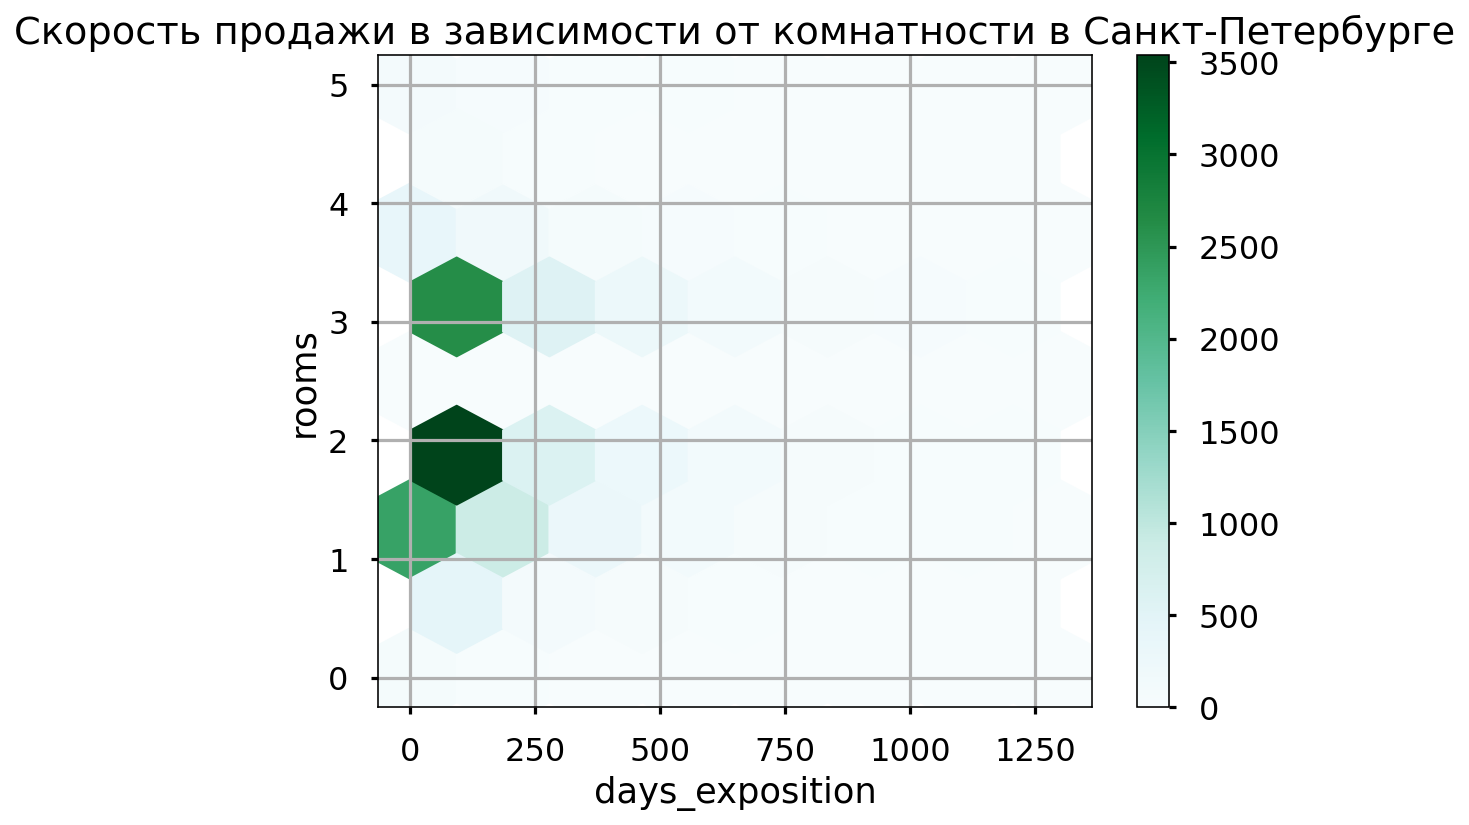

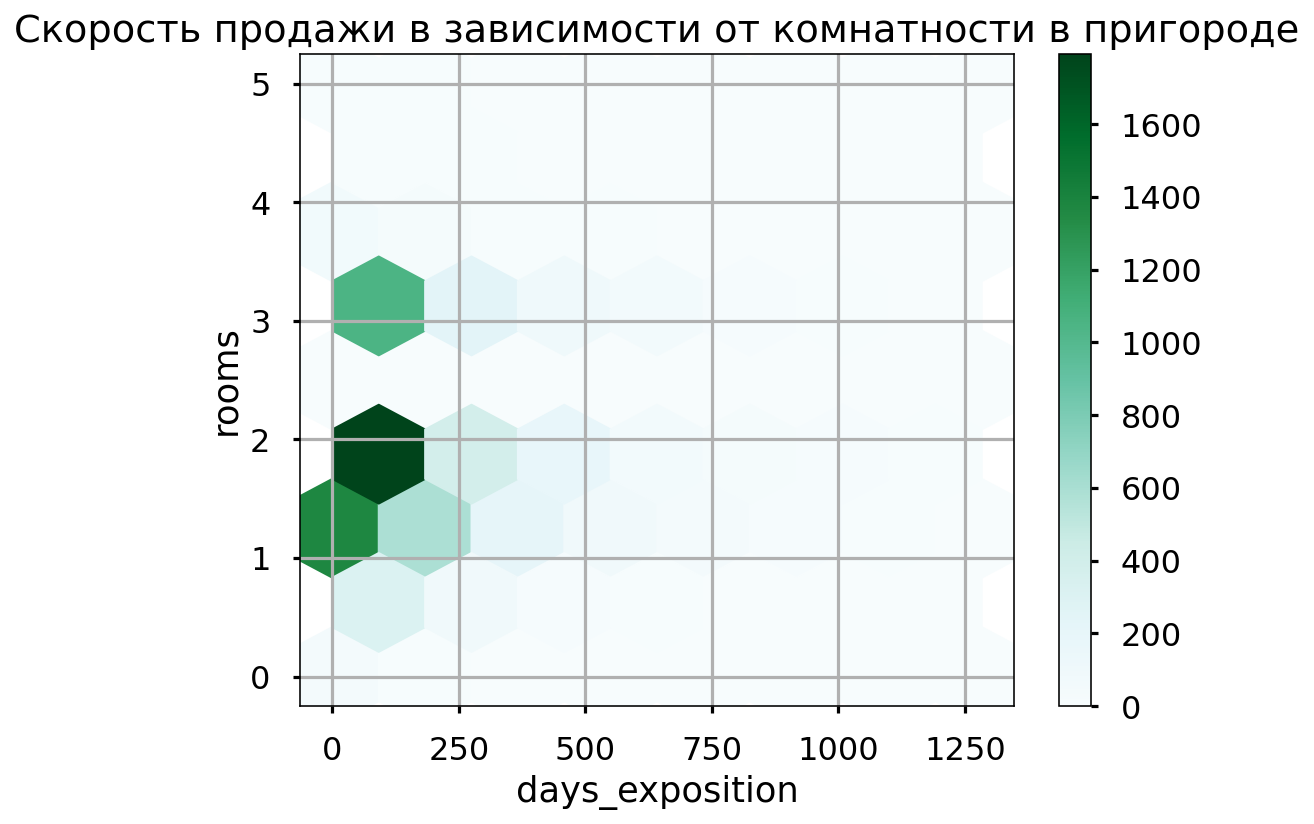

156.04057752194018

In [79]:
# Создаю перменные сводные таблицы с объектами Санкт-Петербурга и пригорода
pivot_days_exposition_spb = display_pivot_table(
    data[
        data[
        'locality_name'] == 'санктпетербург'
        ] , "days_exposition", "rooms")

pivot_days_exposition_other = display_pivot_table(
    data[
        data[
            'locality_name'] != 'санктпетербург'
    ] , "days_exposition", "rooms")

# Отразим это на графиках

data[data['locality_name'] == 'санктпетербург'].plot(
    x='days_exposition', y='rooms', kind='hexbin', gridsize=7, figsize=(
        8, 6), sharex=False, grid=True)
plt.title('Скорость продажи в зависимости от комнатности в Санкт-Петербурге', loc = 'center') # название графика

data[data['locality_name'] != 'санктпетербург'].plot(
    x='days_exposition', y='rooms', kind='hexbin', gridsize=7, figsize=(
        8, 6), sharex=False, grid=True)
plt.title('Скорость продажи в зависимости от комнатности в пригороде', loc = 'center') # название графика

plt.show()
data['days_exposition'].mean()

***Вывод по исследованию скорости продажи объектов***

Средняя скорость продажи ***всех объектов*** составляет 156 дней, однако этот показатель отличается в зависимости от локации и количества комнат.  
В обоих случаях средняя скорость продажи студий самая низкая, однако их количество небольшое. Из значимого количества быстрее продаются однокомнатные квартиры ниже других вариантов.   
Обращаю внимание, что в Питере квартиры продаются быстрее, чем в пригороде.  

Средняя скорость продажи по Питеру: 
- "двушек" всего на ~3% выше, чем "однушек" (при этом количество "двушек больше на ~9%);
- "трёшки" при этом продаются на ~22% дольше "однушек"(количество "трёшек" меньше на ~3%).

Средняя скорость продажи по пригороду: 
- "двушек" на ~5% выше, чем "однушек" (при этом количество "двушек меньше на ~7%);
- "трёшки" при этом продаются на 10% дольше "однушек"(но их количество меньше на ~40%).

#### Исследование факторов, влияющих на стоимость объектов.

На этом этапе определяю корреляцию цены от различных факторов.  
Для этого используется метод `corr()` и матрицу диаграмм рассеяния.

In [80]:
# Для определения факторов влияния на стоимость объекта построю тепловую диаграмму
corrMatrix = data.select_dtypes(include=np.number).iloc[:, 1:21].corr()
corrMatrix.style.background_gradient(cmap='coolwarm')

Из тепловой карты вижу ожидаемую преобладающую зависимость параметров площади объектов.  
    
Помимо площади на стоимость влияют: количество комнат, высота потолков (но помним о заполнении медианами пропусков), наличие парков рядом и их удалённость.  
Обратная зависимость в гораздо меньшем масштабе видна по показателю удалённости от центра, аэропорта и  наличию водоемов рядом (помним, что показатель следует исследовать отдельно, исключая нули).  
    
> Исследую сначала параметры зависимости с исключениями (высота потолков, парки рядом), а затем построю отдельно тепловые карты зависимости по всем параметрам для Санкт-Петербурга и пригорода.

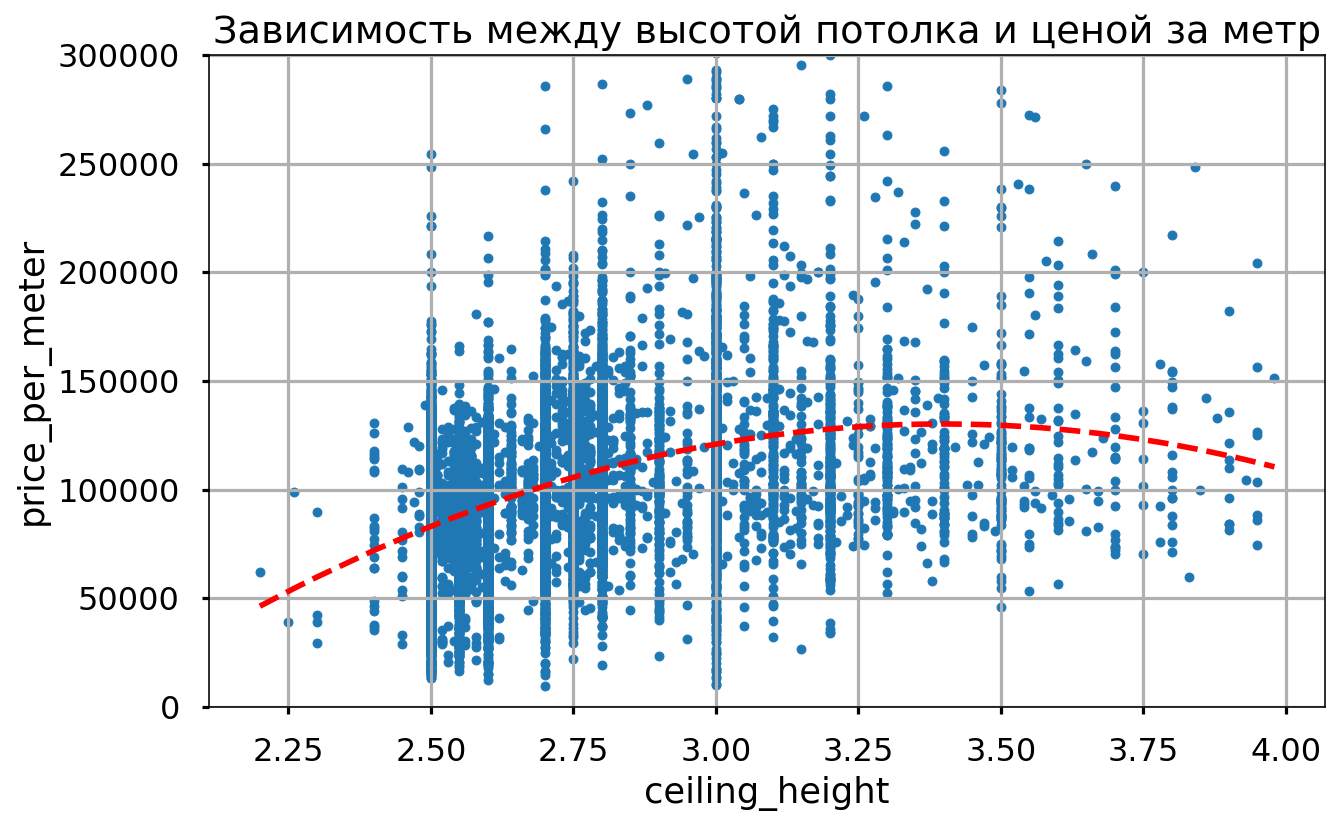

In [81]:
# Помню про заполнение пропусков медианным значением (2,65) и отбрасываю их перед началом анализа
sorted_ceiling_height= data[
    data[
        'ceiling_height'] != 2.65
].sort_values(by='ceiling_height')

sorted_ceiling_height.plot(
    x='ceiling_height', y='price_per_meter', kind='scatter', 
    title='Зависимость между высотой потолка и ценой за метр', ylim=(0, 300000), grid=True, figsize=(10, 6))

z = np.polyfit(sorted_ceiling_height['ceiling_height'], sorted_ceiling_height['price_per_meter'], 2)
p = np.poly1d(z)
plt.plot(sorted_ceiling_height['ceiling_height'], p(sorted_ceiling_height['ceiling_height']),"r--")
plt.show()

График зависимости отражает значительное влияние высоты потолков при экстремально низких нестандартных значениях  (до 2,5 м). Основная масса продаваемых объектов имеет более стандартную высоту потолков и зависимость цены за метр от этого показателя неочевидная.

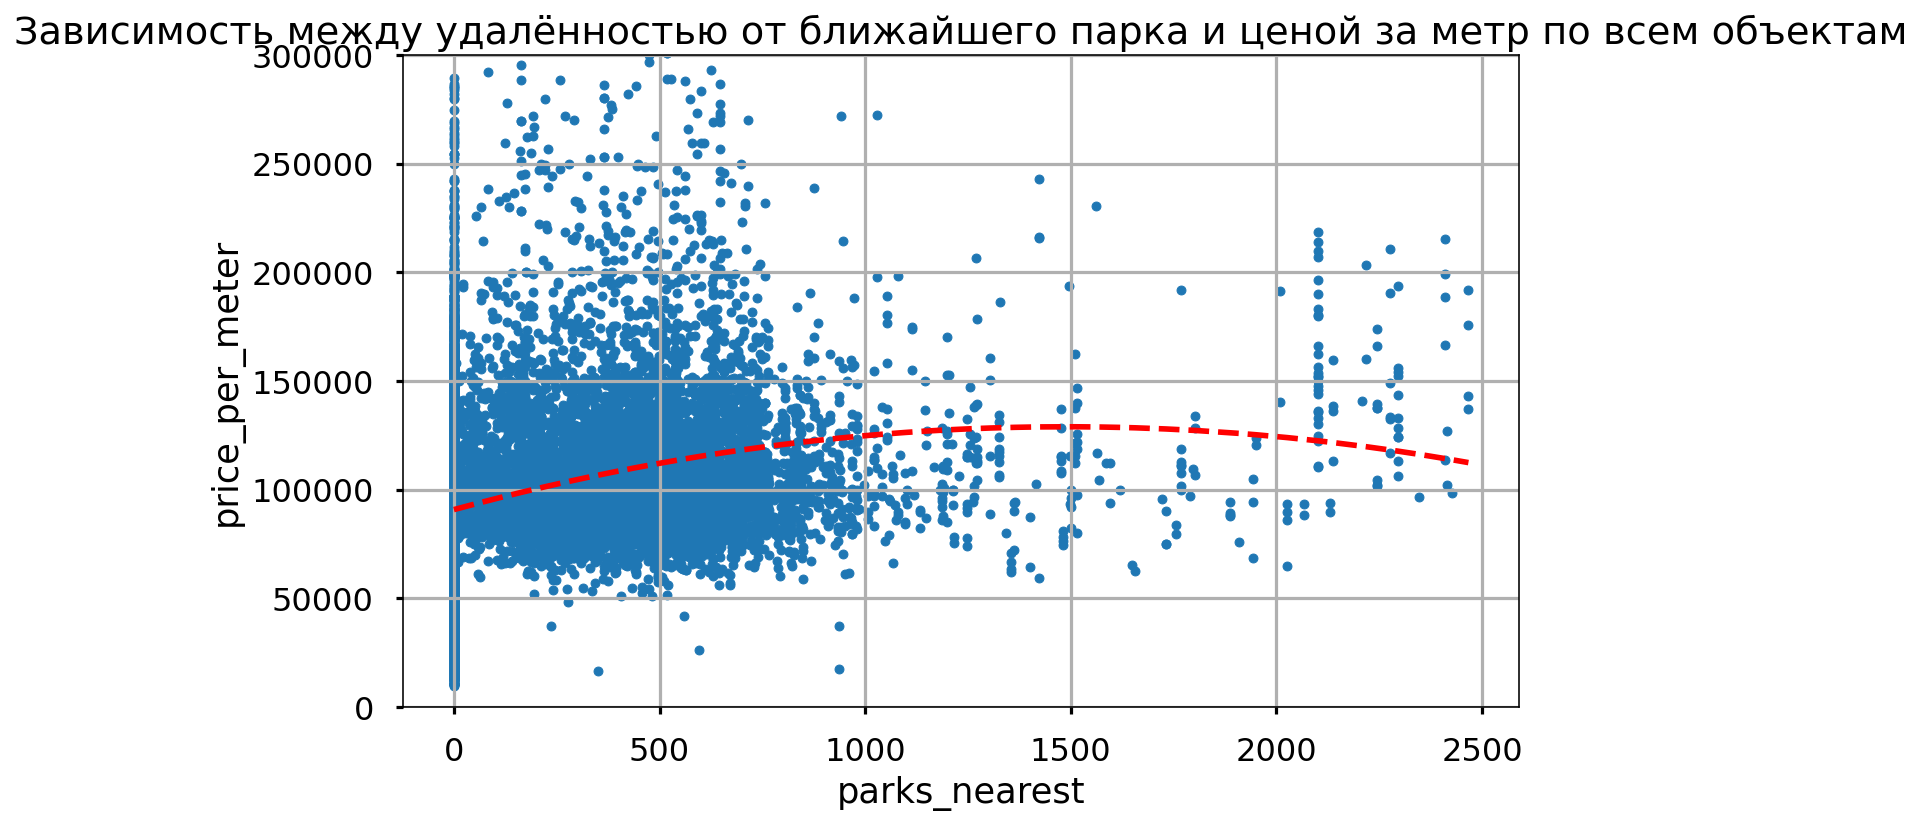

In [82]:
data.plot(
    x='parks_nearest', y='price_per_meter', kind='scatter', 
    title='Зависимость между удалённостью от ближайшего парка и ценой за метр по всем объектам', ylim=(0, 300000), grid=True, figsize=(10, 6))

z = np.polyfit(data['parks_nearest'], data['price_per_meter'], 2)
p = np.poly1d(z)
plt.plot(data['parks_nearest'], p(data['parks_nearest']),"r--")
plt.show()

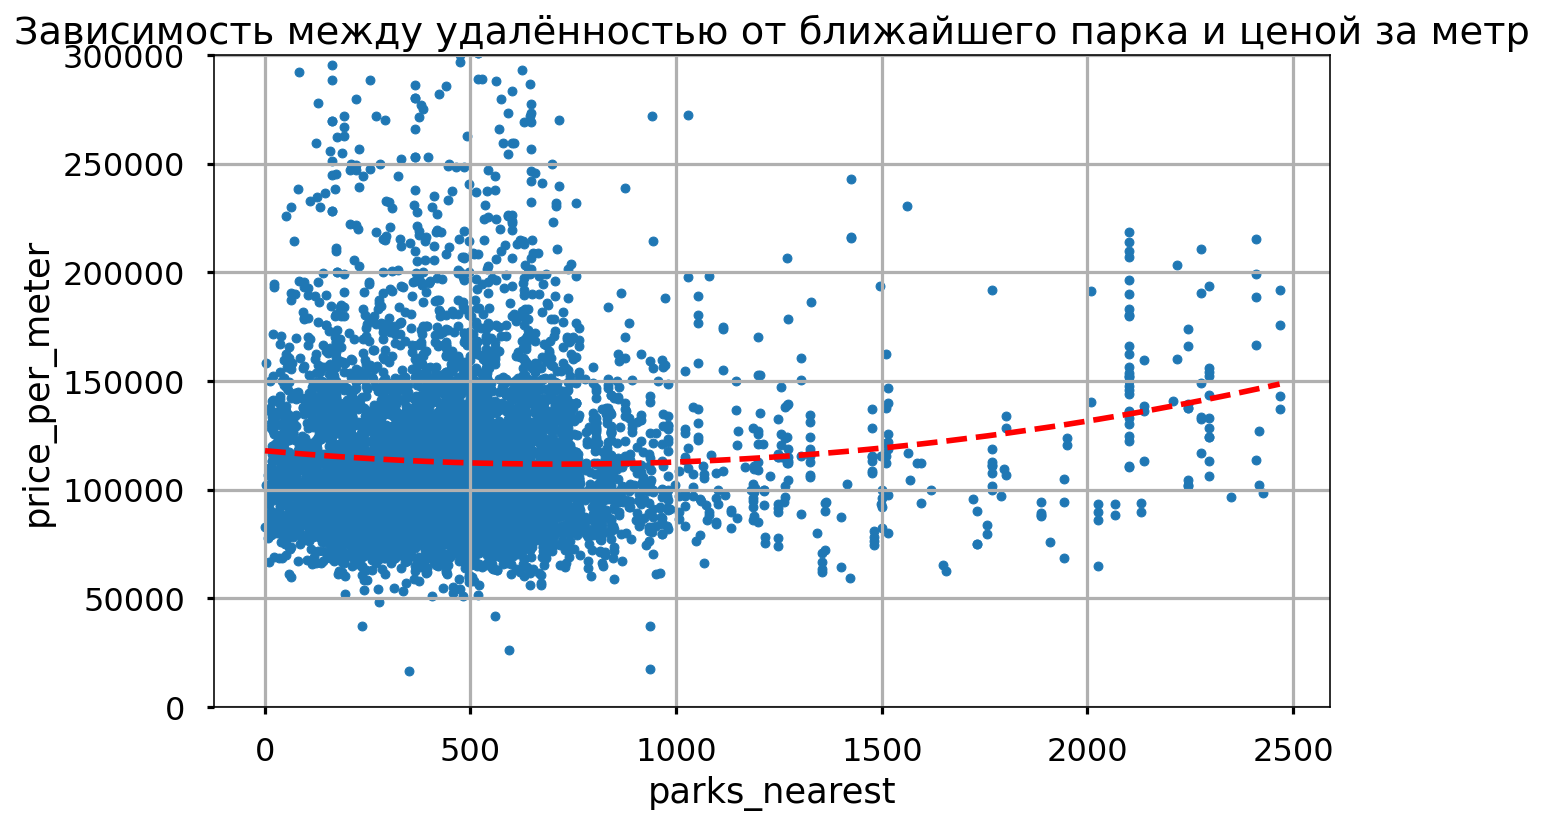

In [83]:
# Помню про заполнение пропусков нулямии и строю два графика, чтобы отследить разницу.
sorted_parks_nearest = data[
    data[
        'parks_nearest'] > 0
].sort_values(by='parks_nearest')

sorted_parks_nearest.plot(
    x='parks_nearest', y='price_per_meter', kind='scatter', 
    title='Зависимость между удалённостью от ближайшего парка и ценой за метр', ylim=(0, 300000), grid=True, figsize=(10, 6))

z = np.polyfit(sorted_parks_nearest['parks_nearest'], sorted_parks_nearest['price_per_meter'], 2)
p = np.poly1d(z)
plt.plot(sorted_parks_nearest['parks_nearest'], p(sorted_parks_nearest['parks_nearest']),"r--")
plt.show()

Из сравнения 2-ух графиков видно, что цена за метр в объектах с `0` (незаполненные значения) ниже, чем у тех, где указано расстояние до парка.   
    При этом расстояние до парка, судя по графику не так важно.

In [84]:
# Для определения факторов влияния на стоимость объекта построю тепловую диаграмму по локациям
corrMatrix = data[data['locality_name'] == 'санктпетербург'].select_dtypes(include=np.number).iloc[:, 1:17].corr()
corrMatrix.style.background_gradient(cmap='coolwarm')

In [85]:
corrMatrix = data[data['locality_name'] != 'санктпетербург'].select_dtypes(include=np.number).iloc[:, 1:17].corr()
corrMatrix.style.background_gradient(cmap='coolwarm')

***Вывод по исследованию факторов, влияющих на стоимость объектов.***   

Влияние факторов на цену несколько отличаются в пригороде и в Санкт-Петербурге.  

В Санкт-Петербурге значительнее влияние на цену:
- общей жилой площади при том что общая площадь влияет на цену сильнее в пригороде; 
- количество комнат и высота потолков влияют почти одинаково и заметно выше других признаков;
- ненулевое значение для цены имеют также наличие парков и прудов поблизости;
- обратное существенное влияние параметр удалённости от центра города и этажность.

В пригороде Санкт-Петербург при этом:
- количество комнат имеет бОльший вес, чем высота потолков;
- наличие парков и прудов повышают цены объектов сильнее чем в Санкт-Петербурге;
- зато удалённость от аэропортов и центра города не так важны для формирования цены объекта.

В дальнейшем исследую стоимость объектов отдельно по населённым пунктам и по Санкт-Петербургу.

#### Исследование средней цены квадратного метра в зависимости от населённого пункта.

In [86]:
# Разделим данные по локациям
data_piter = data[data.locality_name.isin(data.locality_name.value_counts().index[:1])] 
# топ-10 населенных пунктов по к-ву объявлений
data_top_10 = data[data.locality_name.isin(data.locality_name.value_counts().index[1:11])]

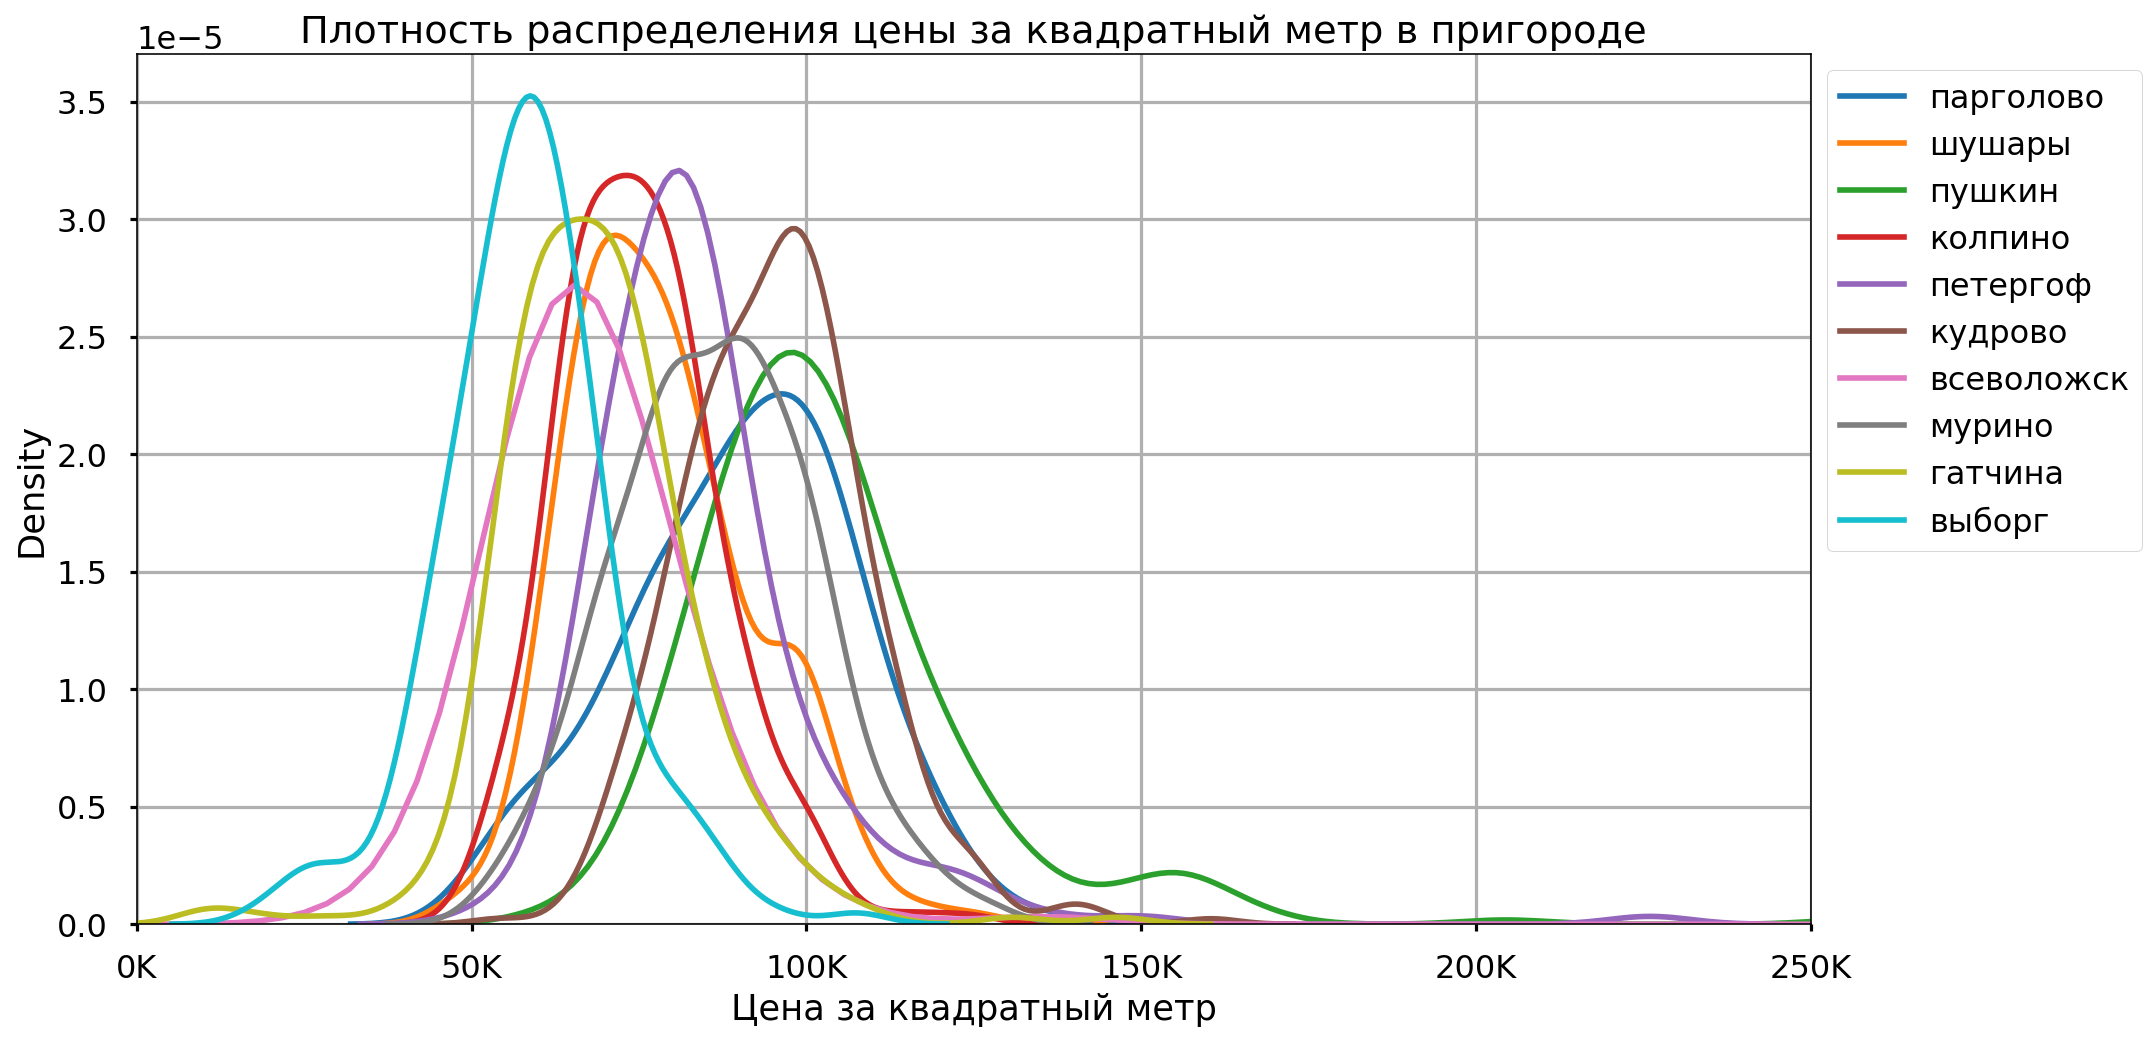

In [87]:
fig, ax = plt.subplots(figsize=(15, 8)) 

# Density plot цены в каждом населенном пункте
for locality in data_top_10.locality_name.unique():
    sns.kdeplot(data_top_10[data_top_10 .locality_name == locality].price_per_meter, label = locality)
    
plt.grid(True) # сетка
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1)) # положение легенды
plt.title('Плотность распределения цены за квадратный метр в пригороде', loc = 'center') # название графика
plt.xlabel('Цена за квадратный метр') # подпись оси x
plt.xlim((0,250000)) # ограничение значений оси X
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{}'.format(int(x/1000)) + 'K')) # форматирование подписей на оси X
plt.savefig('locality_comparison.png', bbox_inches = 'tight') # сохранение графика для презентации
plt.show()

In [88]:
# Рассчитаю среднюю стоимость квадратного метра в этих населённых пунктах
data_top_10.groupby('locality_name')['price_per_meter'].mean().sort_values()

locality_name
выборг         58267.420851
гатчина        68683.193368
всеволожск     68916.518723
колпино        75249.775443
шушары         78778.103259
петергоф       84480.969848
мурино         86564.167578
парголово      90312.550714
кудрово        95646.152005
пушкин        103273.613443
Name: price_per_meter, dtype: float64

***Вывод по исследованию цены за метр в зависимости от населённого пункта.***   

На графике видно заметное отличие в цене за квадратный метр между Всеволжском (средняя цена - 67 754 тыс.руб.) и г.Пушкин (средняя цена - 103 613 тыс.руб.)

По данным википедии:


- Вы́борг — город в России, административный центр Выборгского муниципального района Ленинградской области. Образует Выборгское городское поселение как единственный населённый пункт в его составе. Город расположен на берегу Выборгского залива, находящегося в северо-восточной части Финского залива. 
- Га́тчина — административный центр Ленинградской области. Находится в юго-западной части области, в 42 км от центра Санкт-Петербурга.
- Все́воложск — город в Ленинградской области России. Численность населения — 78 849 чел.

- ...
- Ку́дрово — город в Заневском городском поселении Всеволожского района Ленинградской области. Благодаря расположению вплотную к восточной границе Санкт-Петербурга, внутри Кольцевой автодороги, в 2 км от станции метрополитена «Улица Дыбенко», является одним из самых ближних пригородов Санкт-Петербурга.
- Сестроре́цк — город в России, внутригородское муниципальное образование в составе Курортного района города федерального значения Санкт-Петербурга. Приморский климатический бальнеогрязевый курорт со своей минеральной водой и лечебными грязями на северном берегу Финского залива Балтийского моря.
- Пушкин — крупный туристический, научный, учебный и военно-промышленный центр. 


#### Исследование средней цены квадратного метра в зависимости от близости к центру города.

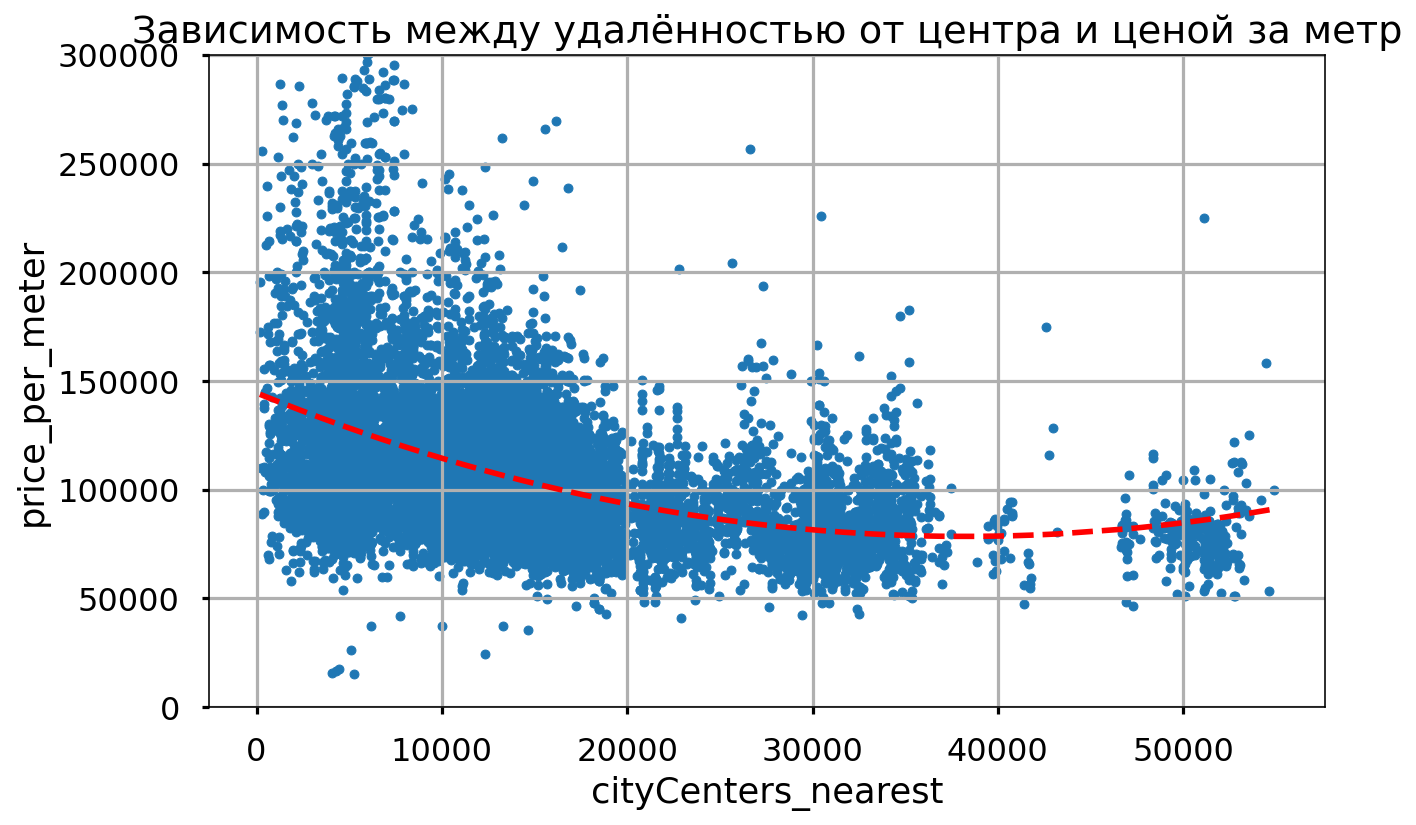

In [89]:
# Помню про заполнение пропусков нулямии и отбрасываю нулевые значения перед началом анализа
sorted_cityCenters_nearest = data[
    data['cityCenters_nearest'] > 0
].sort_values(
    by='cityCenters_nearest'
)
# Задаю параметры графика зависимости цены за метр и удалённости от центра, 
# где красная линия отражает динамику цены по мере удаления от центра
sorted_cityCenters_nearest.plot(
    x='cityCenters_nearest', y='price_per_meter', kind='scatter', 
    title='Зависимость между удалённостью от центра и ценой за метр', ylim=(0, 300000), grid=True, figsize=(10, 6))

z = np.polyfit(
    sorted_cityCenters_nearest[
        'cityCenters_nearest'
    ], sorted_cityCenters_nearest[
        'price_per_meter'], 2
)
p = np.poly1d(z)
plt.plot(
    sorted_cityCenters_nearest[
        'cityCenters_nearest'
    ], p(
        sorted_cityCenters_nearest[
            'cityCenters_nearest'
        ]),"r--")
plt.show()

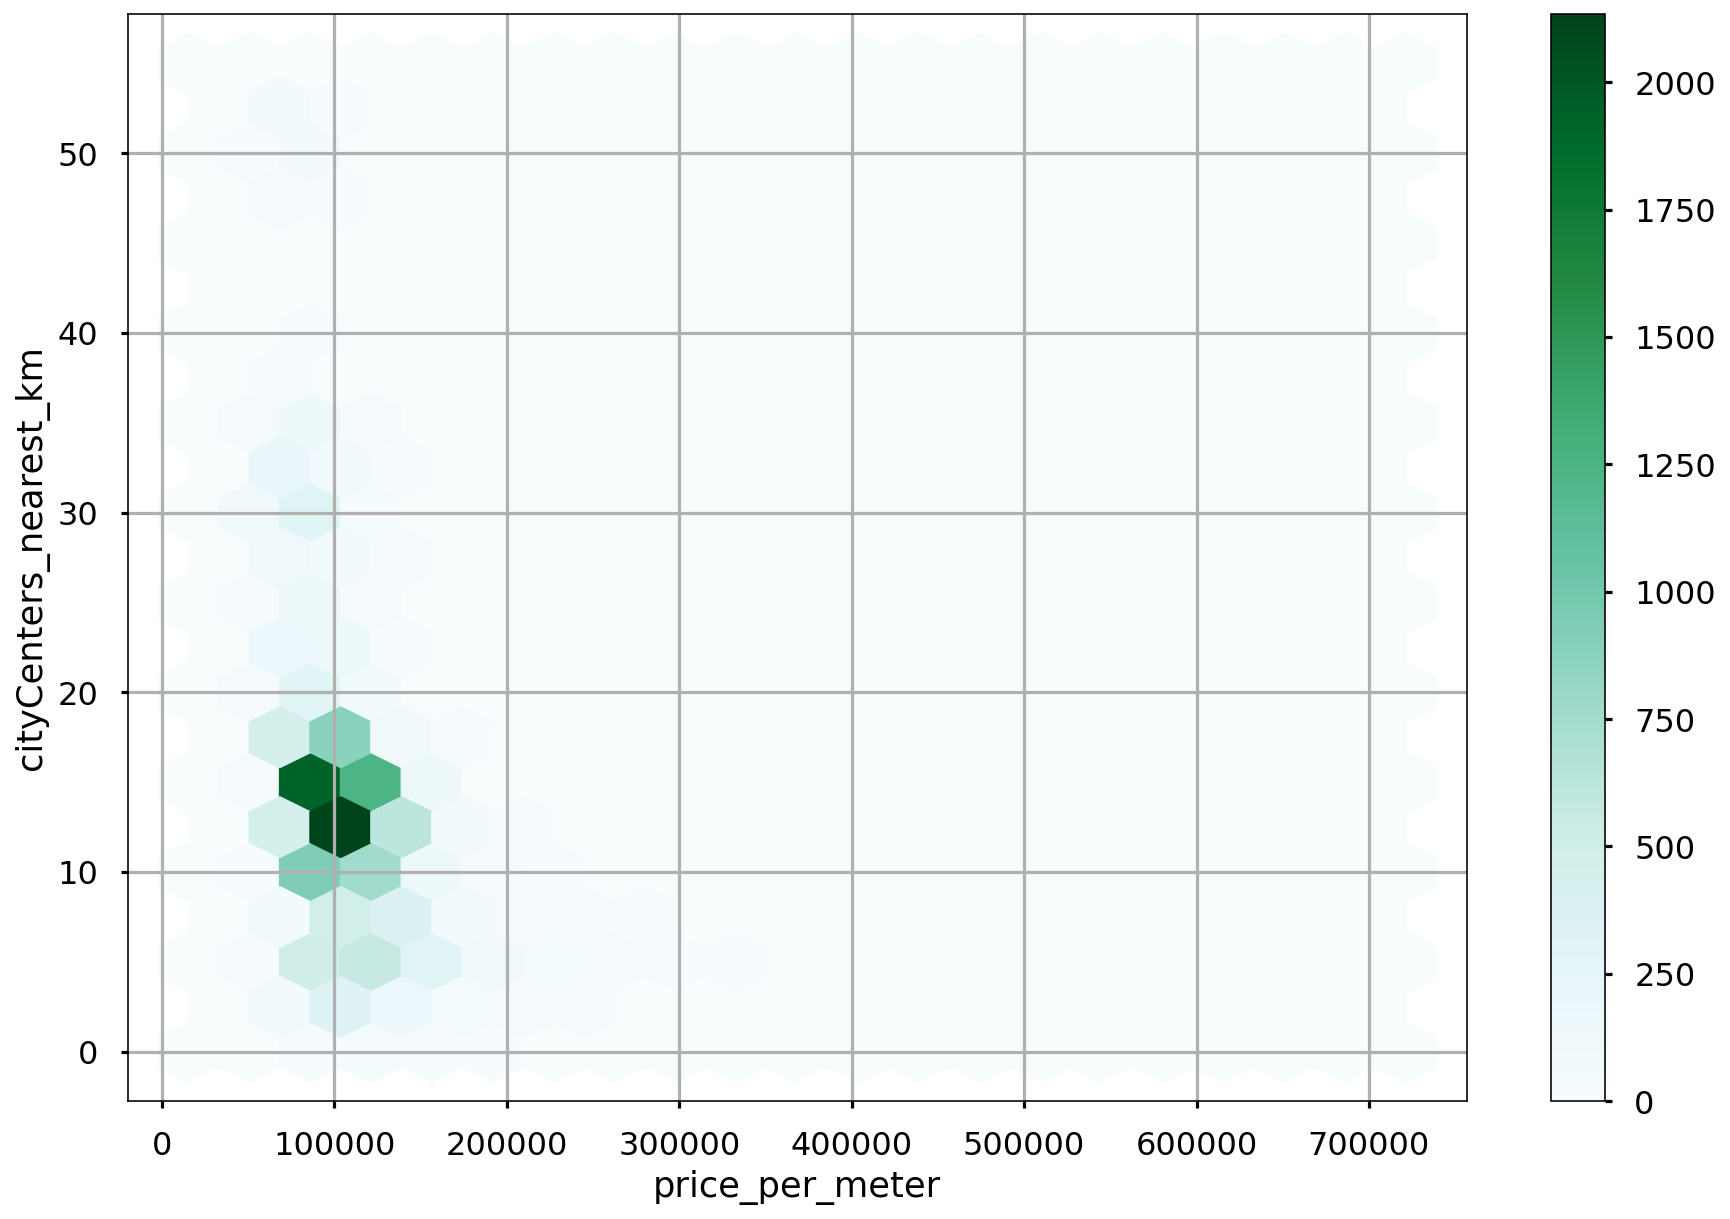

In [90]:
# Вывожу график зависимости цены кв.метра в Санкт-петербурге от удалённости от центра
sorted_cityCenters_nearest.plot(x='price_per_meter', y='cityCenters_nearest_km', kind='hexbin', gridsize=20, figsize=(15, 10), sharex=False, grid=True)
plt.show()

In [91]:
price_per_km = sorted_cityCenters_nearest.pivot_table(index='cityCenters_nearest_km', values='price_per_meter', aggfunc=['count', 'mean'])
price_per_km

count            mean
                       price_per_meter price_per_meter
cityCenters_nearest_km                                
0.0                                 15   183407.900000
1.0                                148   136810.903986
2.0                                248   137028.214677
3.0                                297   118158.288148
4.0                                607   126664.716112
5.0                                768   133617.231419
6.0                                495   139770.122141
7.0                                356   140673.385000
8.0                                546   122853.137381
9.0                                536   112568.018060
10.0                               648   111556.527963
11.0                              1083   107940.451976
12.0                              1501   107393.884497
13.0                              1363   107932.319105
14.0                              1200   103875.141733
15.0                              1455   104222.920687
16.0                              1161   100297.711705
17.0                               815    96733.684356
18.0                               354    93202.781780
19.0                               332    97086.089157
20.0                                78    86225.909103
21.0                               135    84986.517407
22.0                               183    87016.285683
23.0                               107    90644.163178
24.0                               110    78708.903727
25.0                                63    93003.399524
26.0                                97    96397.670928
27.0                                99   102496.377980
28.0                                98    80225.856429
29.0                               118    76554.213220
30.0                               200    84154.399100
31.0                               273    81079.372381
32.0                               131    77914.069771
33.0                               130    85791.652538
34.0                               169    87740.088284
35.0                                91    93075.462637
36.0                                34    86315.203824
37.0                                13    76585.682308
39.0                                 3    75655.710000
40.0                                16    76711.547500
41.0                                 9    79708.318889
42.0                                 6    62479.371667
43.0                                 4   125001.052500
47.0                                28    77740.822500
48.0                                 9    93893.944444
49.0                                26    79980.813077
50.0                                48    76114.706458
51.0                                49    84696.398163
52.0                                56    74227.327321
53.0                                26    85604.120769
54.0                                 4   116596.600000
55.0                                 2    76651.860000

***Вывод по исследованию средней цены квадратного метра, в зависимости от удалённости от центра.***   

Влияние фактора удалённости от центра Санкт-Петербурга была отмечена выше.  
Однако, такое влияние неоднозначно – самый дорогой объект находится в 27 км от центра, а далее цена неравномерно снижается по мере удаления. 

### Общий вывод

Мною проведено исследование данных сервиса Яндекс Недвижимость – архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.  

В процессе анализа была изучена полученная информация, выполнена предобработка данных, добавлены столбцы с необходимыми значениями для дальнейшего анализа, проведён исследовательский анализ данных.  

Основные параметры были очищены от редких и нехарактерных значений, выведены средние сопоставимые параметры по количеству объектов.

На скорость продажи объектов в большей степени влияют количество комнат - быстрее всего в Санкт-Петербурге продаются 2-ух  комнатные квартиры. В пригороде лидером скорости продаж являются "однушки".

Выявлено, что на стоимость объектов в пригороде и Санкт-Петербурге в разной степени влияют такие параметры как площадь объектов, высота потолков, количество комнат, наличие парков и прудов рядом.   
Выявлено также прямое влияние удаленности от центра города в Санкт-Петербурге, однако такое влияние не всегда однозначно и прямолинейно.  

При необходимости более глубокого изучения можно изучить также влияние каждого из параметров в зависимости от локации, цены и других интересующих показателей.